V6.2 -> Pendadaran

https://drive.google.com/file/d/1oCSxnC0QyPkAjiXsq5vr83VMbedWjyBe/view?usp=sharing

# Import Dependency


In [1]:
import tensorflow
import sys
%load_ext tensorboard

import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import pandas as pd
import numpy as np
from numpy import ndarray
import matplotlib
import math
import json

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import json
from datetime import datetime

from google.colab import drive
import os.path
from os import path
drive.mount('/content/drive')


print("Python: ", sys.version)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("keras: ", tensorflow.keras.__version__)
print("tensorflow: ", tensorflow.__version__)

ModuleNotFoundError: No module named 'tensorflow'

## Parameter 

In [ ]:
VERSION = 'v6.2'

# colab Folder
DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/'

# Dataset
DATA_TRAIN_PATH = DRIVE_PATH+'dataset_ip/normal/blt2_04nov-24nov.csv' #normal
DATA_TEST_PATH = DRIVE_PATH+'dataset_ip/anomaly_1-10/' #anotmaly
DATA_TEST_PREFIX = 'blt2_30nov-04des'

ENCODING = "ISO-8859-1" # csv encoding
DATE_COL_NAME = 'date'
TIMESTAMP = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

LOG_EXPORT_PATH = DRIVE_PATH+'LSTM/log/'+VERSION+'/'
if path.exists(LOG_EXPORT_PATH) == False:
  !mkdir LOG_EXPORT_PATH
  os.mkdir(LOG_EXPORT_PATH)

PLOT_EXPORT_PATH = DRIVE_PATH+'LSTM/plot/'+VERSION+'/'
if path.exists(PLOT_EXPORT_PATH) == False:
  !mkdir PLOT_EXPORT_PATH
  os.mkdir(PLOT_EXPORT_PATH)

# scaler
SCALER = MinMaxScaler(feature_range = (0,1))
PLOT_VISIBLE = True
PLOT_SIZE = (12, 6)
PLOT_SAVE = True
TEST_SPACE = 10

RESULT_DATA = []*8 #temporary result data
RESULT_THRESHOLD = []*8 #temporary result threshold

sensors = [
    "date", #0
    "Excitation Field Current", #1
    "Excitation Field Voltage", #2
    "Power Factor", #3
    "Reactive Power", #4
    "Generator Gross Capacity", #5
]

seasonals = [
    "Trend",
    "Seasonal",
    "Residual"
]
test_types = ['extreme','variance','shift','trend']

## Fungsi - Fungsi

### Fungsi Reshape Data

In [ ]:
def Reshape(df_input, prefix=''):
  
  # change to datetime format
  df_input['date'] = pd.to_datetime(df_input['date'])
  
  # sort datetime
  df_input.sort_values(by='date', ascending=True, inplace=True)

  # make datetime as index
  df_input.set_index('date', drop=True, inplace=True)

  # resample to avoid missing data or timeseries (convert to zeros). Also can be used to  reduce data
  df_input = df_input.resample('1min').sum() # (1) .sum() make no value in lookup become 0. (2) 1min = 1 minute

  #if zeros means missing data change into NAN, 
  df_input[df_input.columns] = df_input[df_input.columns].replace(0, np.nan)
  
  #check NaN
  nan_counts = [df_input[col].isnull().sum() for col in df_input.columns]

  # Fill NaN Using Interpolate
  if sum(nan_counts) > 0:
    df_input.interpolate(method='spline', order=3, limit=max(nan_counts), limit_direction='both', inplace=True)

  if PLOT_VISIBLE:
    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure(figsize=(24,12))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle('color', [cm(1.*i/len(df_input.columns)) for i in range(len(df_input.columns))])
    for col_name in df_input.columns:
        ax.plot(df_input[col_name])
    plt.legend(df_input.columns, ncol=int(math.ceil(len(df_input.columns)/10)),  bbox_to_anchor=(1, 1))
    plt.title('Original '+prefix+'Data')
    plt.savefig(PLOT_EXPORT_PATH + prefix + 'Data Original.jpg')  
    plt.show()

  return df_input

### Fungsi MinMaxScaller

In [ ]:
def FitScaler(df_input):
  scaler = MinMaxScaler(feature_range = (0,1))
  df_scaled = scaler.fit_transform(df_input.values.reshape(-1,1))
  
  # if PLOT_VISIBLE:
    # cm = plt.get_cmap('gist_rainbow')
    # fig = plt.figure(figsize=(24, 12))
    # ax = fig.add_subplot(111)
    # ax.set_prop_cycle('color', [cm(1.*i/len(df_scaled.columns)) for i in range(len(df_scaled.columns))])
    # for col_name in df_scaled.columns:
    #     ax.plot(df_scaled[col_name])
    # plt.legend(df_scaled.columns, ncol=int(math.ceil(len(df_scaled.columns)/10)),  bbox_to_anchor=(1, 1))
    # plt.title('Scaled '+ str(prefix)+'Data')
    # plt.savefig(PLOT_EXPORT_PATH + str(prefix) + 'Data Scaled.jpg')
    # plt.show()

  return df_scaled, scaler

### Fungsi Split Seasonal Decompose

In [ ]:
def SplitSeasonalDecompose(df_input, prefix=''):
  df_split = seasonal_decompose(df_input, period=1440, model="additive", extrapolate_trend='freq') 
  #model menggunakan "additive" (pertambahan) karena terdapat nilai 0. "multiplicative" (Perkalian)  tidak bisa jika terdapat value 0
  #1440 dari menit perhari

  if PLOT_VISIBLE:
    plt.figure(figsize=(24,3))
    plt.plot(df_split.trend)
    plt.title(prefix + '_Trend')
    plt.savefig(PLOT_EXPORT_PATH +prefix + '_Trend.jpg')
    plt.show()

    plt.figure(figsize=(24,3))
    plt.plot(df_split.seasonal)
    plt.title(prefix + '_Seasonal')
    plt.savefig(PLOT_EXPORT_PATH +prefix + '_Seasonal.jpg')
    plt.show()

    plt.figure(figsize=(24,3))
    plt.plot(df_split.resid)
    plt.title(prefix + '_Residual')
    plt.savefig(PLOT_EXPORT_PATH +prefix + '_Residual.jpg')
    plt.show()
    
  return df_split.trend, df_split.seasonal, df_split.resid

### Fungsi Inverse Scaler

In [ ]:
def InverseScaler(df_input,scaler):
  df_inverse = scaler.inverse_transform(df_input)
  return df_inverse

### Fungsi Fit LSTM

In [ ]:
# fit an LSTM network to training data
def FitLstm(df_train, df_validation, n_unit, n_batch, n_epoch, n_time_steps, prefix=''):
  model = Sequential()
  model.add(LSTM(n_unit, input_shape=(n_time_steps,1), return_sequences=True))
  model.add(Dense(1, activation='sigmoid'))
  # model.add(Dense(1))
  model.compile(optimizer='adam', loss=METRIC)
  model.summary()

  model_log = model.fit(x=df_train, y=df_train,
            batch_size = n_batch,
            epochs = n_epoch,
            verbose=1,
            validation_data = (df_validation, df_validation),
            shuffle=False
            )
            
  json.dump(model_log.history, open(LOG_EXPORT_PATH+prefix, 'w'))
  model.save(LOG_EXPORT_PATH + 'Model ' + prefix + '.h5')
  
  plt.plot(model_log.history['loss'], marker='.',label='train')
  plt.plot(model_log.history['val_loss'], marker='.',label='validation')
  plt.title('Train vs validation_'+prefix)
  plt.legend()
  plt.savefig(PLOT_EXPORT_PATH + 'Train vs validation_'+prefix + '.jpg')
  plt.show()

  print('Model saved to: "',LOG_EXPORT_PATH + 'Model ' + prefix + '.h5"')

  return model, model_log

In [ ]:
# fit an LSTM network to training data
def FitLstm2(df_train, df_validation, n_unit, n_batch, n_epoch, n_time_steps, prefix=''):
  model = Sequential()
  model.add(LSTM(n_unit, input_shape=(n_time_steps,1), return_sequences=True))
  model.add(LSTM(n_unit, input_shape=(n_time_steps,1), return_sequences=True))
  model.compile(optimizer='adam', loss=METRIC)
  model.summary()

  model_log = model.fit(x=df_train, y=df_train,
            batch_size = n_batch,
            epochs = n_epoch,
            verbose=1,
            validation_data = (df_validation, df_validation),
            shuffle=False
            )
            
  json.dump(model_log.history, open(LOG_EXPORT_PATH+prefix, 'w'))
  model.save(LOG_EXPORT_PATH + 'Model ' + prefix + '.h5')
  
  plt.plot(model_log.history['loss'], marker='.',label='train')
  plt.plot(model_log.history['val_loss'], marker='.',label='validation')
  plt.title('Model train vs validation loss '+prefix)
  plt.legend()
  plt.savefig(PLOT_EXPORT_PATH + 'Model train vs validation loss '+prefix + '.jpg')
  plt.show()

  print('Model saved to: "',LOG_EXPORT_PATH + 'Model ' + prefix + '.h5"')

  return model, model_log

In [ ]:
# fit an LSTM network to training data
def FitLstm3(df_train, df_validation, n_unit, n_batch, n_epoch, n_time_steps, prefix=''):
  model = Sequential()
  model.add(LSTM(n_unit, input_shape=(n_time_steps,1), return_sequences=True))
  model.compile(optimizer='adam', loss=METRIC)
  model.summary()

  model_log = model.fit(x=df_train, y=df_train,
            batch_size = n_batch,
            epochs = n_epoch,
            verbose=1,
            validation_data = (df_validation, df_validation),
            shuffle=False
            )
            
  json.dump(model_log.history, open(LOG_EXPORT_PATH+prefix, 'w'))
  model.save(LOG_EXPORT_PATH + 'Model ' + prefix + '.h5')
  
  plt.plot(model_log.history['loss'], marker='.',label='train')
  plt.plot(model_log.history['val_loss'], marker='.',label='validation')
  plt.title('Model train vs validation loss '+prefix)
  plt.legend()
  plt.savefig(PLOT_EXPORT_PATH + 'Model train vs validation loss '+prefix + '.jpg')
  plt.show()
  
  print('Model saved to: "',LOG_EXPORT_PATH + 'Model ' + prefix + '.h5"')

  return model, model_log

### Fungsi Calculate Metric

In [ ]:
def CalculateMetic(combined_test_result):
  sintetic_anomaly_location = test_param[test_type]['timestamps']

  index=0
  true_positive = 0
  anomaly_predicted = 0
  for anomaly in combined_test_result['anomaly']:
    if anomaly == 1:
      # print(index)
      for start, end in sintetic_anomaly_location:
        
        # cek pada sekitar area apakah ada anomali
        for sintetis_anomaly in range(start-TEST_SPACE, end+TEST_SPACE):
          if (index == sintetis_anomaly):
            # print('>>>>>',sintetis_anomaly)
            true_positive+=1
      anomaly_predicted+=1
    index+=1

  false_positive = anomaly_predicted - true_positive
  print('Anomaly Predicted: ',anomaly_predicted) #save
  print('True Positif: ',true_positive) #save
  print('False Positif: ',false_positive)
  print('Precision: ',(true_positive/(true_positive+false_positive)))
  
  return anomaly_predicted,true_positive

# Import dan Olah Data

## Import Train Data

Training Dataset Path:  /content/drive/MyDrive/Colab Notebooks/dataset_ip/normal/blt2_04nov-24nov.csv


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


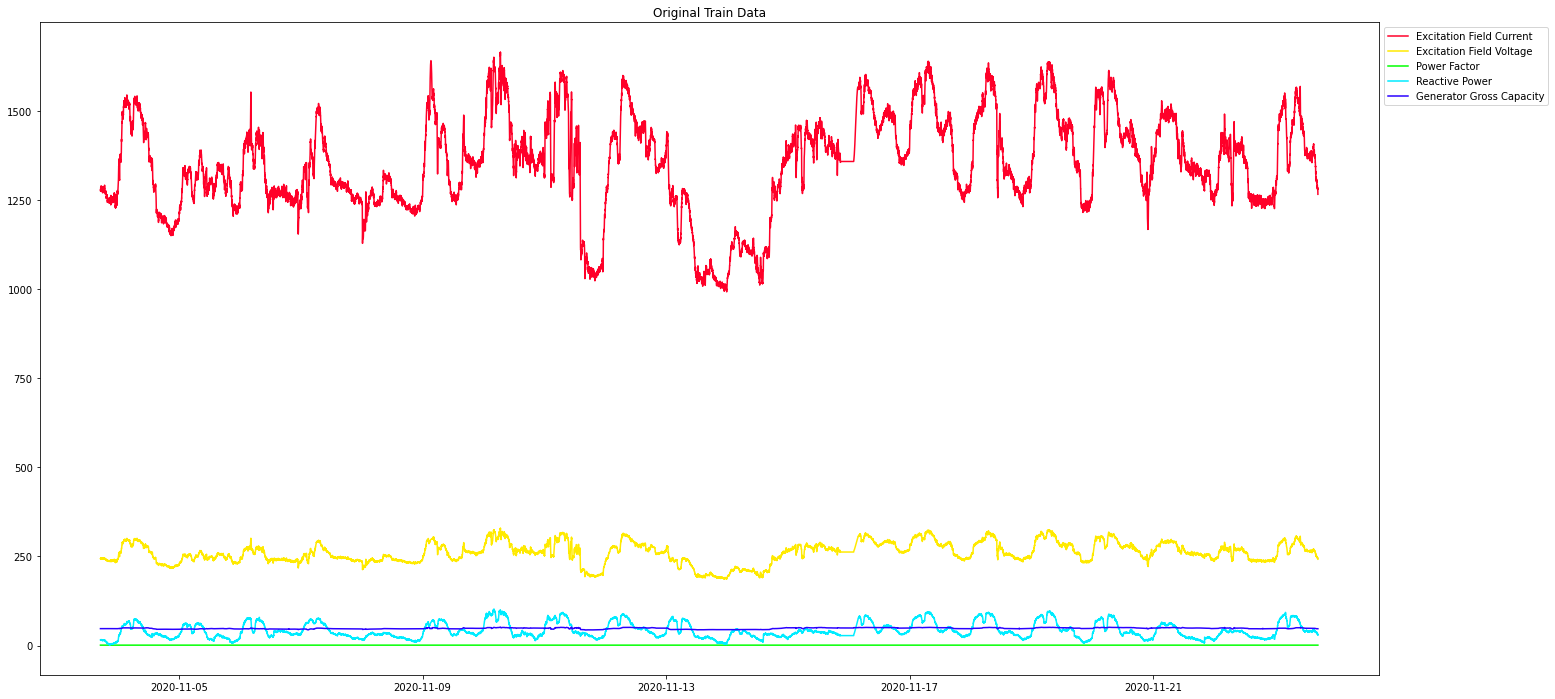

Excitation Field Current  Excitation Field Voltage  \
date                                                                      
2020-11-03 17:01:00               1279.181641                243.693634   
2020-11-03 17:02:00               1275.686279                243.129669   
2020-11-03 17:03:00               1276.679077                242.692551   

                     Power Factor  Reactive Power  Generator Gross Capacity  
date                                                                         
2020-11-03 17:01:00      1.007328       15.343759                 47.349918  
2020-11-03 17:02:00      1.007541       14.585219                 47.351555  
2020-11-03 17:03:00      1.006973       14.489356                 47.353813

In [ ]:
print("Training Dataset Path: ", DATA_TRAIN_PATH)
df_train_original = pd.read_csv(DATA_TRAIN_PATH, header=0, sep=';')
df_train_original = df_train_original.loc[:, df_train_original.columns.intersection(sensors)]
#Reshape data
df_train_reshape = Reshape(df_train_original,'Train ')
df_train_reshape.head(3)

## Describe Data

In [ ]:
for sensor in sensors:
  if sensor != DATE_COL_NAME:
    print(df_train_reshape[sensor].describe())

count    28800.000000
mean      1353.346540
std        136.836558
min        992.836365
25%       1264.899628
50%       1357.852234
75%       1450.042297
max       1665.812622
Name: Excitation Field Current, dtype: float64
count    28800.000000
mean       260.669964
std         29.292006
min        186.417099
25%        241.006180
50%        261.194824
75%        281.658905
max        329.333404
Name: Excitation Field Voltage, dtype: float64
count    28800.000000
mean         1.006719
std          0.002904
min          0.998446
25%          1.004498
50%          1.006237
75%          1.009033
max          1.016542
Name: Power Factor, dtype: float64
count    28800.000000
mean        42.442664
std         21.672493
min          1.814182
25%         26.366840
50%         36.910116
75%         58.291722
max        101.817894
Name: Reactive Power, dtype: float64
count    28800.000000
mean        48.044968
std          1.850996
min         43.584324
25%         46.810988
50%         48.19882

# Batch Training =============

In [ ]:
n_repeat = 1

METRIC = 'mean_absolute_error'
training_summary = []

n_epochs = {
    'Trend':[100],
    'Seasonal': [100],
    'Residual':[100],
}

n_batchs = {
    'Trend':[32],
    'Seasonal':[32],
    'Residual':[64],
}
n_units = {
    'Trend':[64],
    'Seasonal':[32],
    'Residual':[16],
}

n_timesteps = {
    'Trend':[1440],
    'Seasonal':[1440],
    'Residual':[1440],
}

Training Sensor:  Excitation Field Current
Start:  2023-01-12 15:36:02.827026


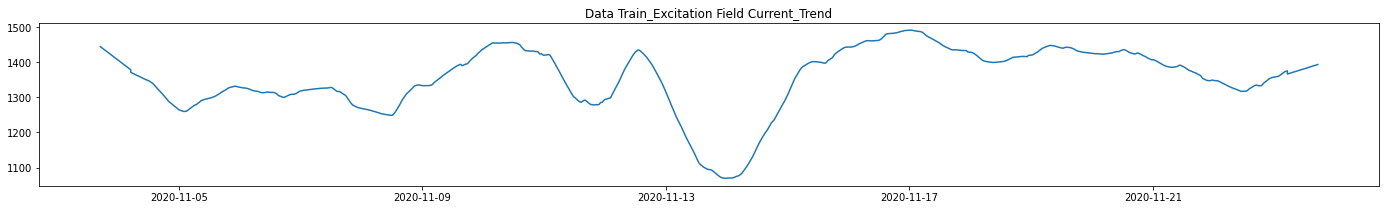

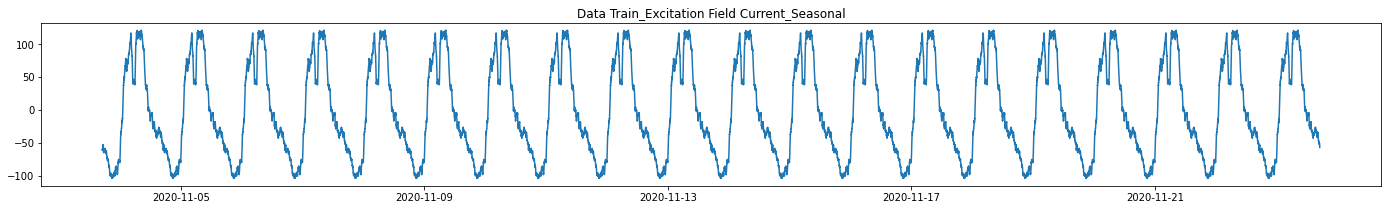

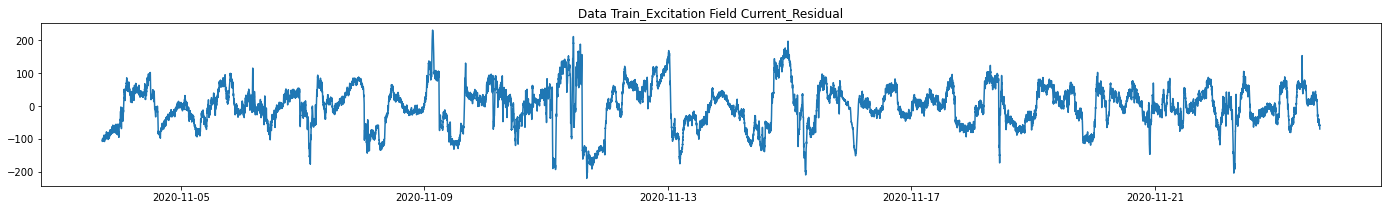

Training:  Excitation Field Current_Trend
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_1 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


657/675 [============================>.] - ETA: 0s - loss: 0.1455

675/675 [==============================] - 4s 3ms/step - loss: 0.1426 - val_loss: 0.0618
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1081 - val_loss: 0.0519
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0704 - val_loss: 0.0411
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0409 - val_loss: 0.0264
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0258 - val_loss: 0.0164
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0199 - val_loss: 0.0148
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0165 - val_loss: 0.0149
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0157 - val_loss: 0.0195
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0168 - val_loss: 0.0197
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0173 - val_loss: 0.0208
E

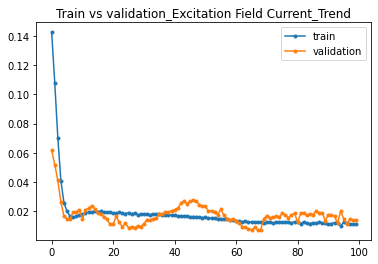

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Excitation Field Current_Trend.h5"
Training:  Excitation Field Current_Seasonal
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_2 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


672/675 [============================>.] - ETA: 0s - loss: 0.1486

675/675 [==============================] - 4s 3ms/step - loss: 0.1479 - val_loss: 0.0647
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1223 - val_loss: 0.0557
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0900 - val_loss: 0.0470
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0536 - val_loss: 0.0467
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0323 - val_loss: 0.0217
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0232 - val_loss: 0.0143
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0180 - val_loss: 0.0089
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 0.0129
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0176 - val_loss: 0.0152
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0190 - val_loss: 0.0149
E

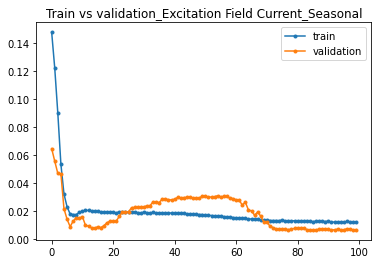

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Excitation Field Current_Seasonal.h5"
Training:  Excitation Field Current_Residual
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1440, 16)          1152      
                                                                 
 dense_3 (Dense)             (None, 1440, 1)           17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


337/338 [============================>.] - ETA: 0s - loss: 0.1750

338/338 [==============================] - 3s 4ms/step - loss: 0.1749 - val_loss: 0.0756
Epoch 2/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1588 - val_loss: 0.0639
Epoch 3/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1497 - val_loss: 0.0608
Epoch 4/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1392 - val_loss: 0.0560
Epoch 5/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1215 - val_loss: 0.0505
Epoch 6/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0975 - val_loss: 0.0481
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0719 - val_loss: 0.0369
Epoch 8/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0477 - val_loss: 0.0389
Epoch 9/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0305 - val_loss: 0.0486
Epoch 10/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0247 - val_loss: 0.0320
E

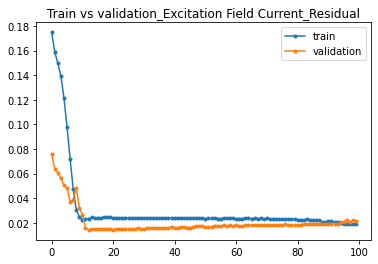

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Excitation Field Current_Residual.h5"
End:  2023-01-12 15:44:33.440788
Training Sensor:  Excitation Field Voltage
Start:  2023-01-12 15:44:33.440895


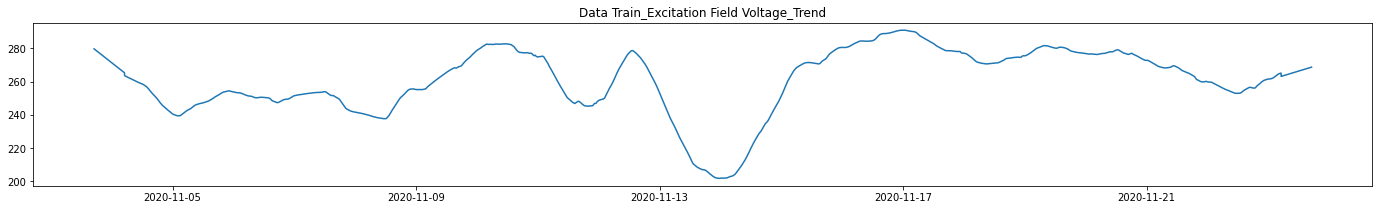

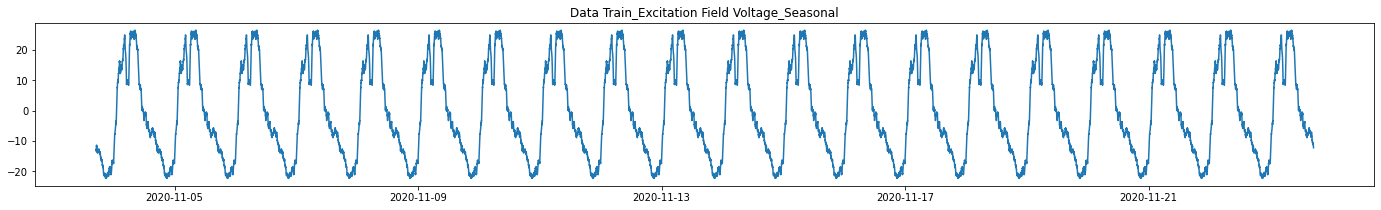

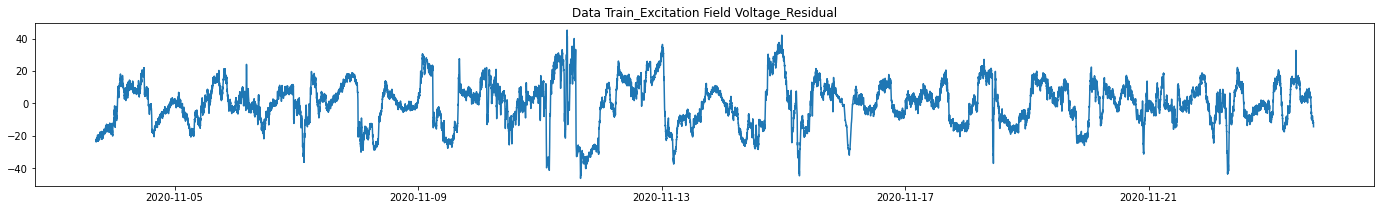

Training:  Excitation Field Voltage_Trend
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_4 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


675/675 [==============================] - ETA: 0s - loss: 0.1405

675/675 [==============================] - 4s 4ms/step - loss: 0.1405 - val_loss: 0.0630
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1028 - val_loss: 0.0519
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0634 - val_loss: 0.0366
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0357 - val_loss: 0.0222
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0230 - val_loss: 0.0159
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0187 - val_loss: 0.0192
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0157 - val_loss: 0.0189
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0156 - val_loss: 0.0220
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0167 - val_loss: 0.0211
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0168 - val_loss: 0.0169
E

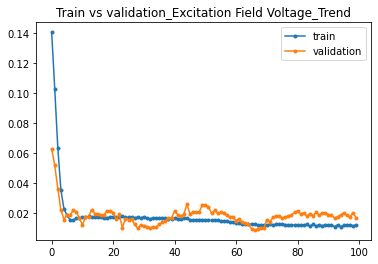

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Excitation Field Voltage_Trend.h5"
Training:  Excitation Field Voltage_Seasonal
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_5 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


669/675 [============================>.] - ETA: 0s - loss: 0.1433

675/675 [==============================] - 4s 3ms/step - loss: 0.1421 - val_loss: 0.0641
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1131 - val_loss: 0.0532
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0740 - val_loss: 0.0482
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0415 - val_loss: 0.0270
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0265 - val_loss: 0.0159
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0198 - val_loss: 0.0094
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0162 - val_loss: 0.0192
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0164 - val_loss: 0.0230
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0185 - val_loss: 0.0267
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0203 - val_loss: 0.0256
E

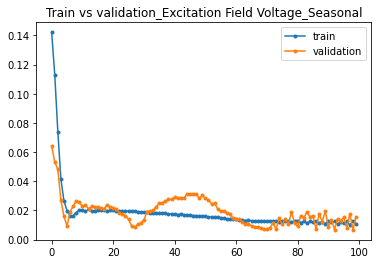

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Excitation Field Voltage_Seasonal.h5"
Training:  Excitation Field Voltage_Residual
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1440, 16)          1152      
                                                                 
 dense_6 (Dense)             (None, 1440, 1)           17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


323/338 [===========================>..] - ETA: 0s - loss: 0.1805

338/338 [==============================] - 3s 5ms/step - loss: 0.1766 - val_loss: 0.0815
Epoch 2/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1635 - val_loss: 0.0670
Epoch 3/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1537 - val_loss: 0.0628
Epoch 4/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1395 - val_loss: 0.0575
Epoch 5/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1214 - val_loss: 0.0518
Epoch 6/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0941 - val_loss: 0.0493
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0681 - val_loss: 0.0367
Epoch 8/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0446 - val_loss: 0.0412
Epoch 9/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0299 - val_loss: 0.0513
Epoch 10/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0252 - val_loss: 0.0273
E

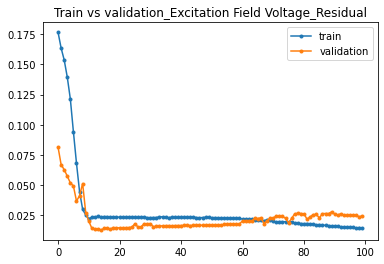

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Excitation Field Voltage_Residual.h5"
End:  2023-01-12 15:53:37.323810
Training Sensor:  Power Factor
Start:  2023-01-12 15:53:37.323923


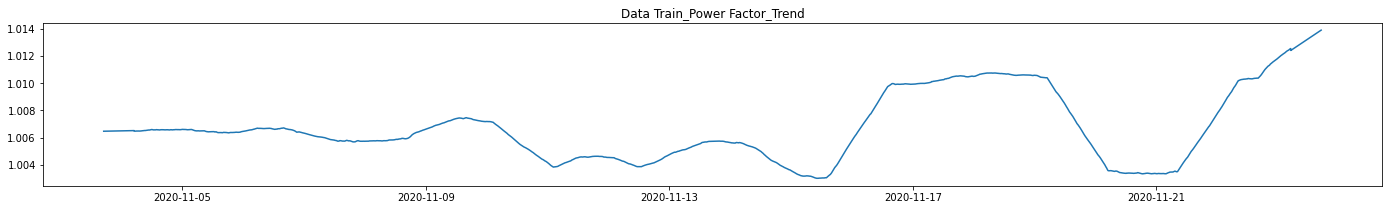

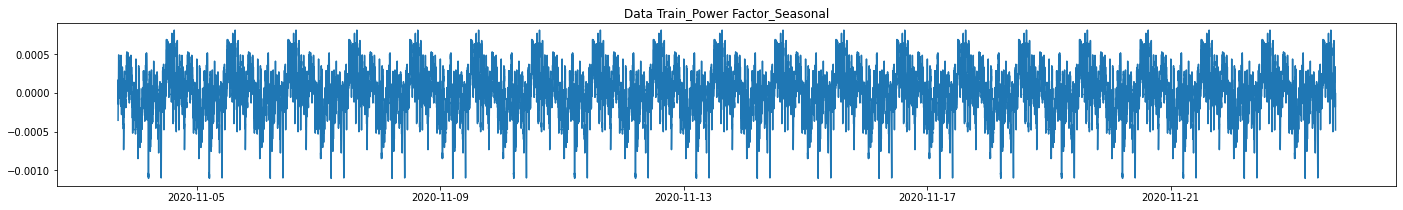

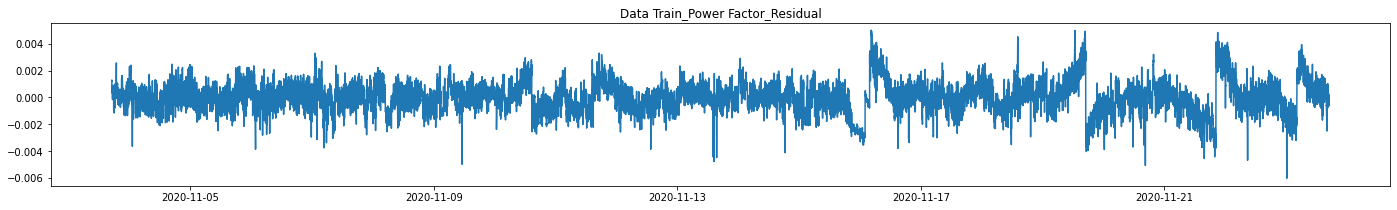

Training:  Power Factor_Trend
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_7 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


662/675 [============================>.] - ETA: 0s - loss: 0.1348

675/675 [==============================] - 4s 4ms/step - loss: 0.1380 - val_loss: 0.2566
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0859 - val_loss: 0.1537
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0430 - val_loss: 0.0796
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0192 - val_loss: 0.0393
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0110 - val_loss: 0.0293
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0096 - val_loss: 0.0289
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0097 - val_loss: 0.0289
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0092 - val_loss: 0.0292
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0092 - val_loss: 0.0296
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0092 - val_loss: 0.0298
E

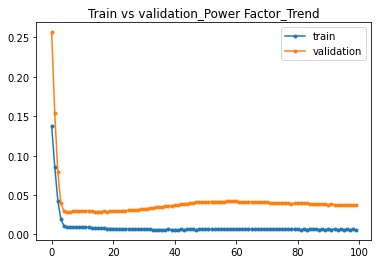

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Power Factor_Trend.h5"
Training:  Power Factor_Seasonal
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_8 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


674/675 [============================>.] - ETA: 0s - loss: 0.1475

675/675 [==============================] - 4s 3ms/step - loss: 0.1477 - val_loss: 0.2716
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0970 - val_loss: 0.1666
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0500 - val_loss: 0.0929
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0236 - val_loss: 0.0493
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0134 - val_loss: 0.0314
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0106 - val_loss: 0.0304
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0105 - val_loss: 0.0314
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0107 - val_loss: 0.0308
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0106 - val_loss: 0.0306
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0104 - val_loss: 0.0304
E

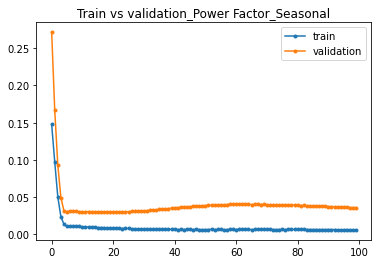

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Power Factor_Seasonal.h5"
Training:  Power Factor_Residual
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1440, 16)          1152      
                                                                 
 dense_9 (Dense)             (None, 1440, 1)           17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


320/338 [===========================>..] - ETA: 0s - loss: 0.1841

338/338 [==============================] - 4s 5ms/step - loss: 0.1981 - val_loss: 0.3219
Epoch 2/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1369 - val_loss: 0.3077
Epoch 3/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1279 - val_loss: 0.2760
Epoch 4/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1115 - val_loss: 0.2297
Epoch 5/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0878 - val_loss: 0.1547
Epoch 6/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0539 - val_loss: 0.0794
Epoch 7/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0280 - val_loss: 0.0457
Epoch 8/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0344
Epoch 9/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0149 - val_loss: 0.0330
Epoch 10/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0327
E

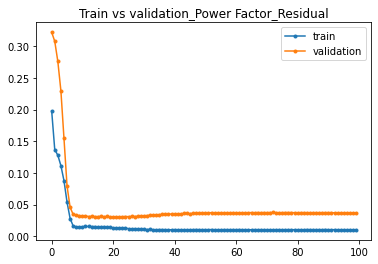

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Power Factor_Residual.h5"
End:  2023-01-12 16:03:53.884210
Training Sensor:  Reactive Power
Start:  2023-01-12 16:03:53.884311


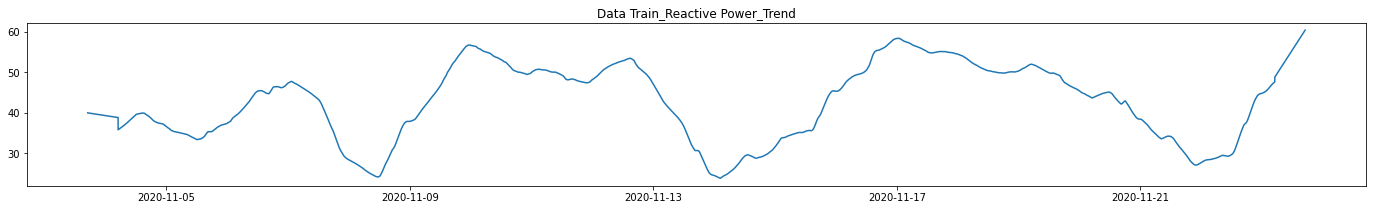

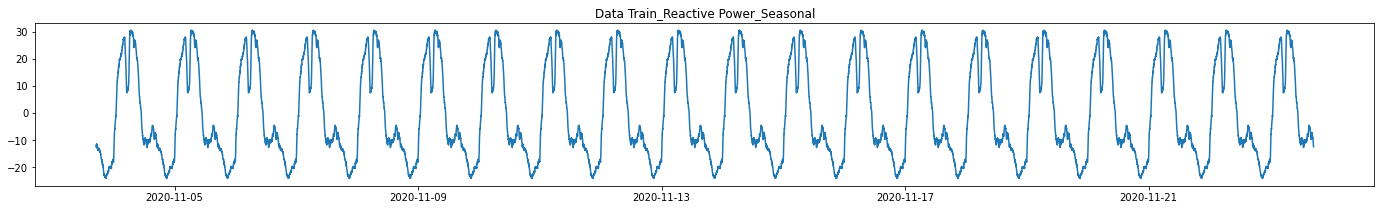

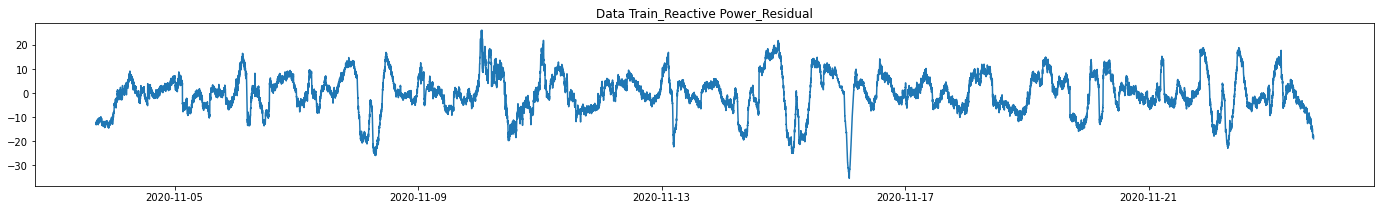

Training:  Reactive Power_Trend
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_10 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


660/675 [============================>.] - ETA: 0s - loss: 0.1758

675/675 [==============================] - 4s 4ms/step - loss: 0.1731 - val_loss: 0.1864
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0942 - val_loss: 0.0951
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0441 - val_loss: 0.0609
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0286 - val_loss: 0.0444
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0225 - val_loss: 0.0385
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0205 - val_loss: 0.0328
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0173 - val_loss: 0.0269
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0156 - val_loss: 0.0178
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0134 - val_loss: 0.0131
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0127 - val_loss: 0.0168
E

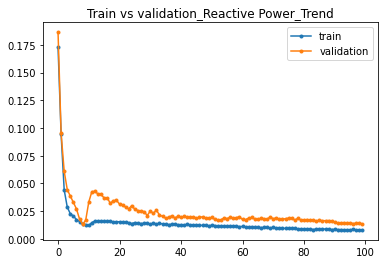

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Reactive Power_Trend.h5"
Training:  Reactive Power_Seasonal
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_11 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


666/675 [============================>.] - ETA: 0s - loss: 0.1823

675/675 [==============================] - 4s 4ms/step - loss: 0.1806 - val_loss: 0.2008
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1129 - val_loss: 0.0919
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0458 - val_loss: 0.0541
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0289 - val_loss: 0.0360
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0221 - val_loss: 0.0240
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 0.0153
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0142 - val_loss: 0.0167
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0133 - val_loss: 0.0235
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0153 - val_loss: 0.0307
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0164 - val_loss: 0.0332
E

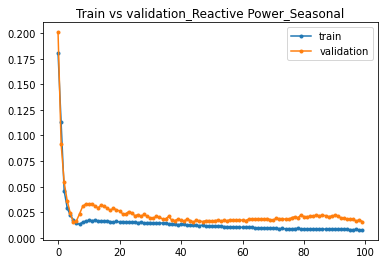

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Reactive Power_Seasonal.h5"
Training:  Reactive Power_Residual
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1440, 16)          1152      
                                                                 
 dense_12 (Dense)            (None, 1440, 1)           17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


326/338 [===========================>..] - ETA: 0s - loss: 0.2115

338/338 [==============================] - 4s 5ms/step - loss: 0.2082 - val_loss: 0.1735
Epoch 2/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1749 - val_loss: 0.1754
Epoch 3/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1443 - val_loss: 0.1443
Epoch 4/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0914 - val_loss: 0.0854
Epoch 5/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0421 - val_loss: 0.0387
Epoch 6/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0270 - val_loss: 0.0216
Epoch 7/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0229
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0217 - val_loss: 0.0239
Epoch 9/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0214 - val_loss: 0.0257
Epoch 10/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0216 - val_loss: 0.0247
E

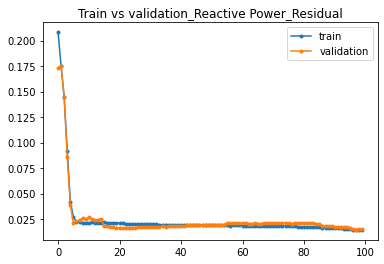

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Reactive Power_Residual.h5"
End:  2023-01-12 16:12:54.217796
Training Sensor:  Generator Gross Capacity
Start:  2023-01-12 16:12:54.217901


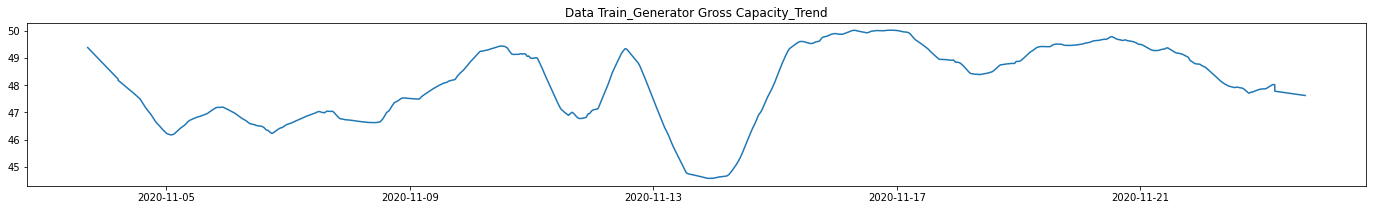

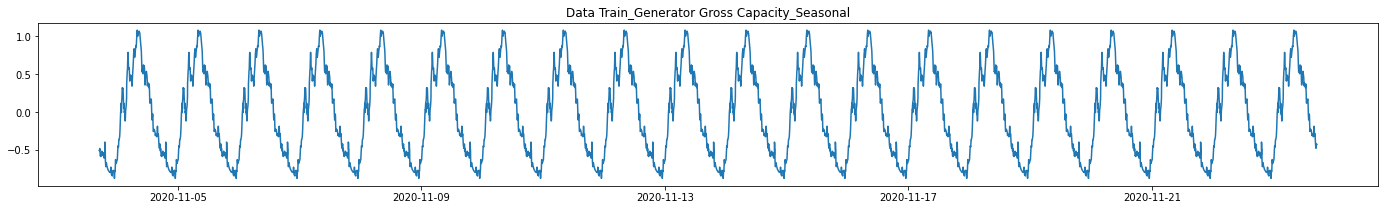

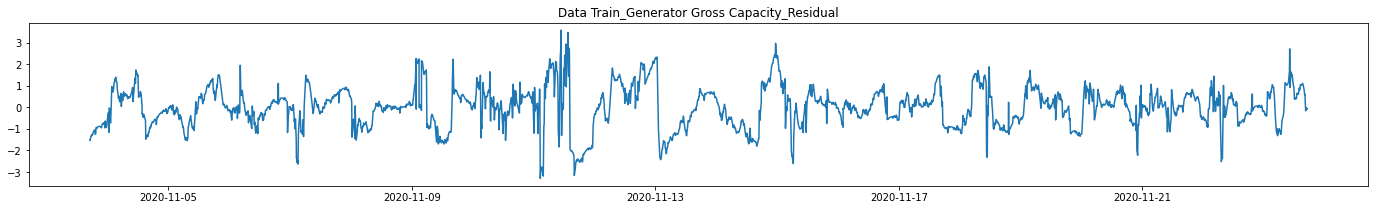

Training:  Generator Gross Capacity_Trend
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_13 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


661/675 [============================>.] - ETA: 0s - loss: 0.1742

675/675 [==============================] - 4s 4ms/step - loss: 0.1716 - val_loss: 0.0897
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1117 - val_loss: 0.0539
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0545 - val_loss: 0.0344
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0301 - val_loss: 0.0244
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0222 - val_loss: 0.0350
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0200 - val_loss: 0.0215
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0232 - val_loss: 0.0221
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0252 - val_loss: 0.0299
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0243 - val_loss: 0.0268
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0241 - val_loss: 0.0303
E

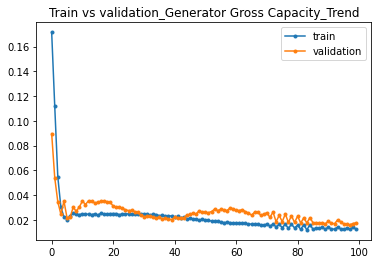

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Generator Gross Capacity_Trend.h5"
Training:  Generator Gross Capacity_Seasonal
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_14 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


674/675 [============================>.] - ETA: 0s - loss: 0.1718

675/675 [==============================] - 4s 4ms/step - loss: 0.1716 - val_loss: 0.0884
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1130 - val_loss: 0.0549
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0558 - val_loss: 0.0326
Epoch 4/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0314 - val_loss: 0.0252
Epoch 5/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0199 - val_loss: 0.0221
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0244 - val_loss: 0.0242
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0245 - val_loss: 0.0287
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0246 - val_loss: 0.0295
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0243 - val_loss: 0.0300
E

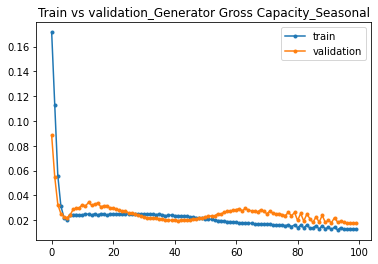

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Generator Gross Capacity_Seasonal.h5"
Training:  Generator Gross Capacity_Residual
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1440, 16)          1152      
                                                                 
 dense_15 (Dense)            (None, 1440, 1)           17        
                                                                 
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


325/338 [===========================>..] - ETA: 0s - loss: 0.2136

338/338 [==============================] - 4s 6ms/step - loss: 0.2084 - val_loss: 0.1377
Epoch 2/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1786 - val_loss: 0.0887
Epoch 3/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1530 - val_loss: 0.0712
Epoch 4/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1158 - val_loss: 0.0525
Epoch 5/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0658 - val_loss: 0.0353
Epoch 6/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0385 - val_loss: 0.0280
Epoch 7/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0283 - val_loss: 0.0237
Epoch 8/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0261 - val_loss: 0.0205
Epoch 9/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0266 - val_loss: 0.0213
Epoch 10/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0267 - val_loss: 0.0217
E

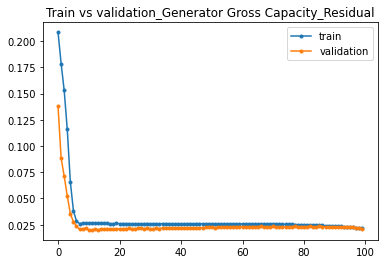

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Model Generator Gross Capacity_Residual.h5"
End:  2023-01-12 16:24:09.721767
Export to: /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.2/Training_summary(2023-01-12_15:28:29).xlsx


In [ ]:
for sensor in sensors:
  if sensor != DATE_COL_NAME:
    print('\n| ========================================================================================== |')
    print('| Training Sensor: ',sensor)
    print('| > Sensor Start Time: ',datetime.now(),'\n')

    df_train = df_train_reshape[sensor].copy()
    # Split Seasonal
    df_train_trend, df_train_seasonal, df_train_residual = SplitSeasonalDecompose(df_train,'Data Train_'+sensor)
    # MinMaxScaled
    df_train_trend_scaled, transform_train_trend = FitScaler(df_train_trend)
    df_train_seasonal_scaled, transform_train_seasonal = FitScaler(df_train_seasonal)
    df_train_residual_scaled, transform_train_residual = FitScaler(df_train_residual)

    # Split data training & validation
    test_size = len(df_train) - int((len(df_train))*0.25)
    df_training_trend, df_validation_trend = df_train_trend_scaled[0:test_size], df_train_trend_scaled[test_size:len(df_train_trend_scaled)]
    df_training_seasonal, df_validation_seasonal = df_train_seasonal_scaled[0:test_size], df_train_seasonal_scaled[test_size:len(df_train_seasonal_scaled)]
    df_training_residual, df_validation_residual = df_train_residual_scaled[0:test_size], df_train_residual_scaled[test_size:len(df_train_residual_scaled)]

    for season in seasonals:
      for n_epoch in n_epochs[season]:
        for n_batch in n_batchs[season]:
          for n_unit in n_units[season]:
            for n_timestep in n_timesteps[season]:
              prefix = str(sensor)+'_'+season
              training_start = datetime.now()

              print('| __________________________________________________________________________________________ |')
              print('| >>',prefix,'Start Time: ',training_start) 
              
              model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
              
              training_end = datetime.now()
              print('| >>',prefix,'End Time: ',training_end)  

              training_summary.append([
              sensor,
              season,
              '1L+1S',
              n_batch, 
              n_unit,
              n_timestep,
              n_epoch, 
              model_log.history['loss'][-1],
              model_log.history['val_loss'][-1],
              json.dumps(model_log.history['loss']),
              json.dumps(model_log.history['val_loss']),
              training_start,
              training_end
            ])
                 
    print('\n| > Sensor End Time: ',datetime.now())
    print('| ========================================================================================== |\n') 

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss','time start','time end'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary('+TIMESTAMP+').xlsx')

# BATAS +++++++++++++++++++++

# Single Training =============

In [ ]:
sensor = sensors[1]
print('Training Sensor: ',sensor)

Training Sensor:  Excitation Field Current


## Data Preparation

### Reshape & Split Seasonal Data

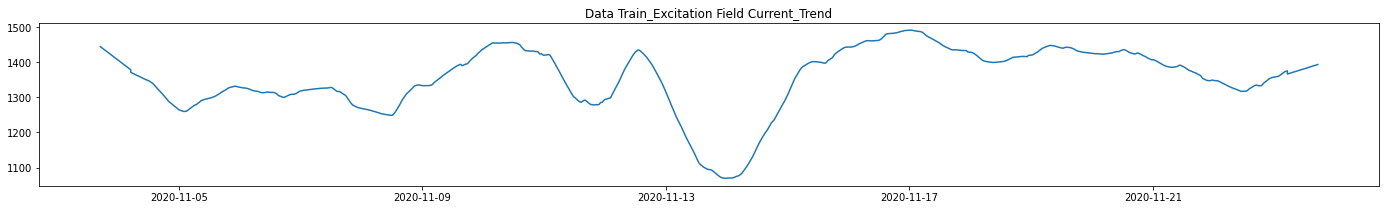

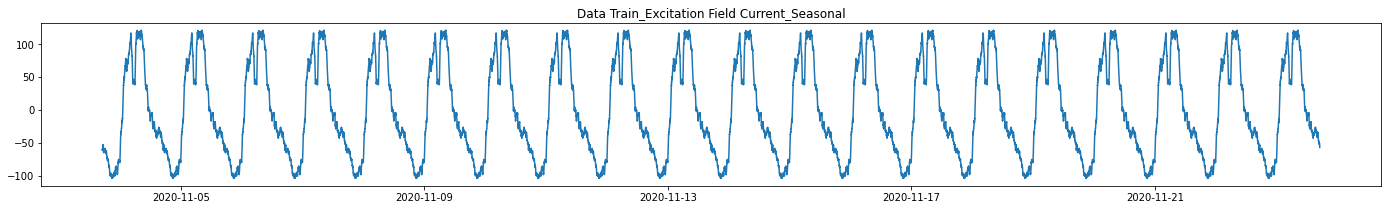

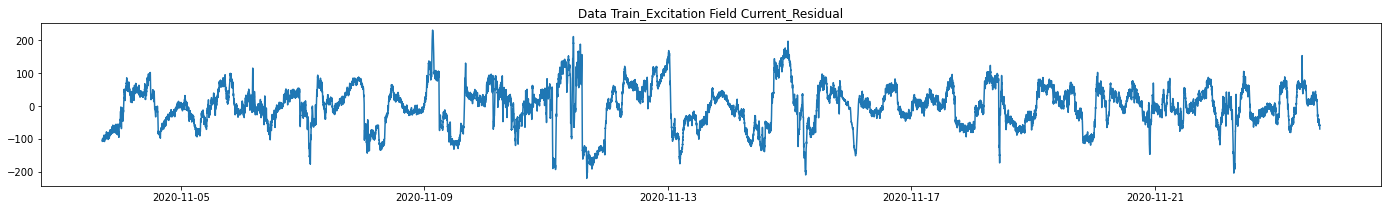

In [ ]:
df_train = df_train_reshape[sensor].copy()
# Split Seasonal
df_train_trend, df_train_seasonal, df_train_residual = SplitSeasonalDecompose(df_train,'Data Train_'+sensor)

### MinMaxScaled

In [ ]:
# MinMaxScaled
df_train_trend_scaled, transform_train_trend = FitScaler(df_train_trend)
df_train_seasonal_scaled, transform_train_seasonal = FitScaler(df_train_seasonal)
df_train_residual_scaled, transform_train_residual = FitScaler(df_train_residual)

### Parameter LSTM

In [ ]:
print('Training Sebsor: ',sensor)
n_repeat = 1

METRIC = 'mean_absolute_error'
training_summary = []

n_epochs = {
    'Trend':[100],
    'Seasonal': [100],
    'Residual':[100],
}

n_batchs = {
    'Trend':[8,16,32,64,128],
    'Seasonal':[8,16,32,64,128],
    'Residual':[8,16,32,64,128],
}
n_units = {
    'Trend':[32,64,128],
    'Seasonal':[32,64,128],
    'Residual':[32,64,128],
}

n_timesteps = {
    'Trend':[1440],
    'Seasonal':[1440],
    'Residual':[1440],
}

Training Sebsor:  Excitation Field Current


### Split data Testing & Validation

In [ ]:
test_size = len(df_train) - int((len(df_train))*0.25)

df_training_trend, df_validation_trend = df_train_trend_scaled[0:test_size], df_train_trend_scaled[test_size:len(df_train_trend_scaled)]
df_training_seasonal, df_validation_seasonal = df_train_seasonal_scaled[0:test_size], df_train_seasonal_scaled[test_size:len(df_train_seasonal_scaled)]
df_training_residual, df_validation_residual = df_train_residual_scaled[0:test_size], df_train_residual_scaled[test_size:len(df_train_residual_scaled)]

## Trend

Training:  Excitation Field Current_Trend_8 32 1440_1L+1S
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_1 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2699/2700 [============================>.] - ETA: 0s - loss: 0.0742

2700/2700 [==============================] - 11s 4ms/step - loss: 0.0742 - val_loss: 0.0564
Epoch 2/100
2700/2700 [==============================] - 13s 5ms/step - loss: 0.0282 - val_loss: 0.0450
Epoch 3/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0161 - val_loss: 0.0380
Epoch 4/100
2700/2700 [==============================] - 7s 2ms/step - loss: 0.0116 - val_loss: 0.0326
Epoch 5/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0092 - val_loss: 0.0260
Epoch 6/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0079 - val_loss: 0.0190
Epoch 7/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0068 - val_loss: 0.0113
Epoch 8/100
2700/2700 [==============================] - 7s 2ms/step - loss: 0.0060 - val_loss: 0.0101
Epoch 9/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0054 - val_loss: 0.0167
Epoch 10/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.005

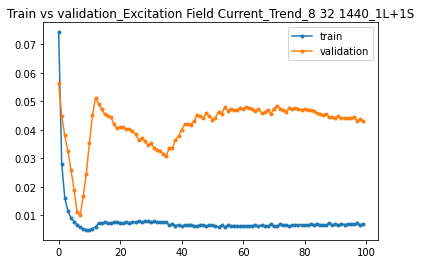

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_8 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_8 64 1440_1L+1S
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_2 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2697/2700 [============================>.] - ETA: 0s - loss: 0.0624

2700/2700 [==============================] - 9s 3ms/step - loss: 0.0624 - val_loss: 0.0571
Epoch 2/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0263 - val_loss: 0.0488
Epoch 3/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0168 - val_loss: 0.0418
Epoch 4/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0124 - val_loss: 0.0359
Epoch 5/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0099 - val_loss: 0.0303
Epoch 6/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0083 - val_loss: 0.0236
Epoch 7/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0071 - val_loss: 0.0158
Epoch 8/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0061 - val_loss: 0.0096
Epoch 9/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0054 - val_loss: 0.0122
Epoch 10/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0051 

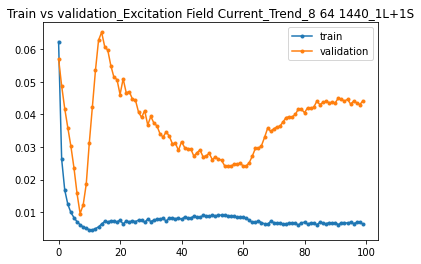

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_8 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_8 128 1440_1L+1S
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1440, 128)         66560     
                                                                 
 dense_3 (Dense)             (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2696/2700 [============================>.] - ETA: 0s - loss: 0.0493

2700/2700 [==============================] - 11s 3ms/step - loss: 0.0492 - val_loss: 0.0601
Epoch 2/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0239 - val_loss: 0.0533
Epoch 3/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0153 - val_loss: 0.0486
Epoch 4/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0123 - val_loss: 0.0451
Epoch 5/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0099 - val_loss: 0.0420
Epoch 6/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0089 - val_loss: 0.0385
Epoch 7/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0077 - val_loss: 0.0342
Epoch 8/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0070 - val_loss: 0.0288
Epoch 9/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0062 - val_loss: 0.0230
Epoch 10/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.005

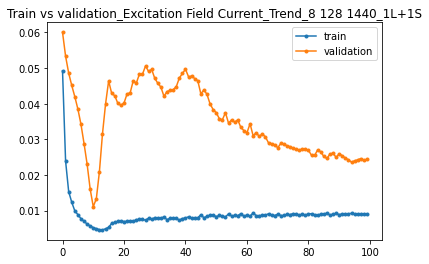

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_8 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_16 32 1440_1L+1S
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_4 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1337/1350 [============================>.] - ETA: 0s - loss: 0.1186

1350/1350 [==============================] - 6s 3ms/step - loss: 0.1176 - val_loss: 0.0568
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0673 - val_loss: 0.0408
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0335 - val_loss: 0.0330
Epoch 4/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0214 - val_loss: 0.0252
Epoch 5/100
1350/1350 [==============================] - 3s 3ms/step - loss: 0.0161 - val_loss: 0.0197
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0133 - val_loss: 0.0159
Epoch 7/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0113 - val_loss: 0.0097
Epoch 8/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0103 - val_loss: 0.0087
Epoch 9/100
1350/1350 [==============================] - 3s 3ms/step - loss: 0.0098 - val_loss: 0.0121
Epoch 10/100
1350/1350 [==============================] - 3s 3ms/step - loss: 0.0112 

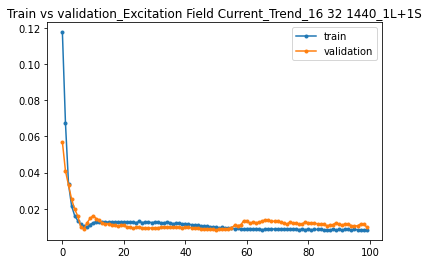

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_16 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_16 64 1440_1L+1S
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_5 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1347/1350 [============================>.] - ETA: 0s - loss: 0.1076

1350/1350 [==============================] - 6s 3ms/step - loss: 0.1074 - val_loss: 0.0565
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0563 - val_loss: 0.0436
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0305 - val_loss: 0.0356
Epoch 4/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0210 - val_loss: 0.0299
Epoch 5/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0165 - val_loss: 0.0275
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0140 - val_loss: 0.0243
Epoch 7/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0122 - val_loss: 0.0215
Epoch 8/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0108 - val_loss: 0.0172
Epoch 9/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0096 - val_loss: 0.0117
Epoch 10/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0088 

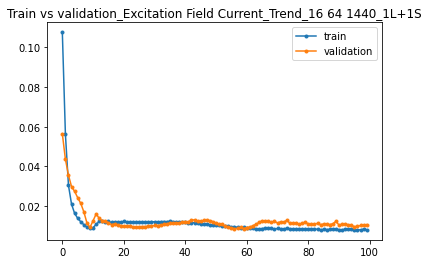

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_16 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_16 128 1440_1L+1S
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1440, 128)         66560     
                                                                 
 dense_6 (Dense)             (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1339/1350 [============================>.] - ETA: 0s - loss: 0.0944

1350/1350 [==============================] - 7s 4ms/step - loss: 0.0937 - val_loss: 0.0566
Epoch 2/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0500 - val_loss: 0.0451
Epoch 3/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0284 - val_loss: 0.0383
Epoch 4/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0213 - val_loss: 0.0344
Epoch 5/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0178 - val_loss: 0.0327
Epoch 6/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0158 - val_loss: 0.0326
Epoch 7/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0144 - val_loss: 0.0315
Epoch 8/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0138 - val_loss: 0.0312
Epoch 9/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0129 - val_loss: 0.0314
Epoch 10/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0124 

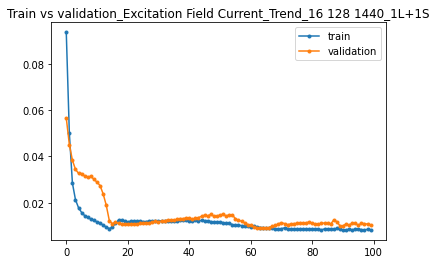

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_16 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_32 32 1440_1L+1S
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_7 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


655/675 [============================>.] - ETA: 0s - loss: 0.1512

675/675 [==============================] - 5s 4ms/step - loss: 0.1476 - val_loss: 0.0643
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1221 - val_loss: 0.0554
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0903 - val_loss: 0.0461
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0546 - val_loss: 0.0416
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0320 - val_loss: 0.0211
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0229 - val_loss: 0.0130
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 0.0083
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0169 - val_loss: 0.0159
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0175 - val_loss: 0.0206
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0185 - val_loss: 0.0203
E

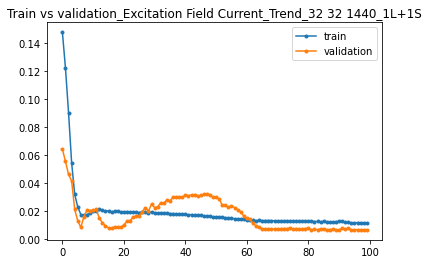

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_32 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_32 64 1440_1L+1S
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_8 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


674/675 [============================>.] - ETA: 0s - loss: 0.1413

675/675 [==============================] - 4s 4ms/step - loss: 0.1411 - val_loss: 0.0614
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1062 - val_loss: 0.0514
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0694 - val_loss: 0.0497
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0394 - val_loss: 0.0256
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0258 - val_loss: 0.0162
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0197 - val_loss: 0.0137
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0164 - val_loss: 0.0161
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0156 - val_loss: 0.0194
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0167 - val_loss: 0.0230
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0176 - val_loss: 0.0248
E

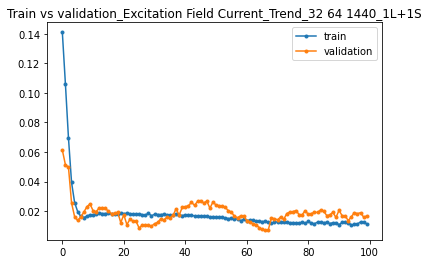

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_32 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_32 128 1440_1L+1S
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1440, 128)         66560     
                                                                 
 dense_9 (Dense)             (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


675/675 [==============================] - ETA: 0s - loss: 0.1344

675/675 [==============================] - 5s 5ms/step - loss: 0.1344 - val_loss: 0.0595
Epoch 2/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0934 - val_loss: 0.0697
Epoch 3/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0540 - val_loss: 0.0312
Epoch 4/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0328 - val_loss: 0.0234
Epoch 5/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0244 - val_loss: 0.0196
Epoch 6/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0201 - val_loss: 0.0158
Epoch 7/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0164 - val_loss: 0.0189
Epoch 8/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0158 - val_loss: 0.0181
Epoch 9/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0152 - val_loss: 0.0134
Epoch 10/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0161 - val_loss: 0.0170
E

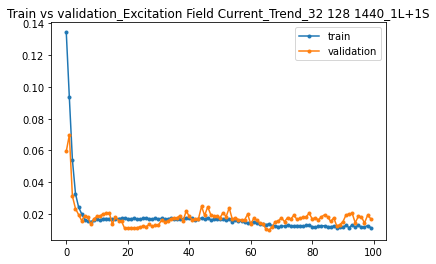

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_32 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_64 32 1440_1L+1S
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_10 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


326/338 [===========================>..] - ETA: 0s - loss: 0.1710

338/338 [==============================] - 4s 5ms/step - loss: 0.1657 - val_loss: 0.0669
Epoch 2/100
338/338 [==============================] - 1s 3ms/step - loss: 0.1585 - val_loss: 0.0629
Epoch 3/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1430 - val_loss: 0.0584
Epoch 4/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1212 - val_loss: 0.0572
Epoch 5/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0948 - val_loss: 0.0452
Epoch 6/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0646 - val_loss: 0.0447
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0420 - val_loss: 0.0566
Epoch 8/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0283 - val_loss: 0.0384
Epoch 9/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0223 - val_loss: 0.0229
Epoch 10/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0217 - val_loss: 0.0154
E

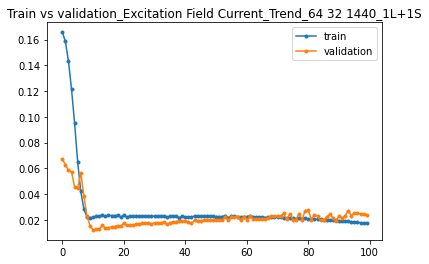

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_64 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_64 64 1440_1L+1S
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_11 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


331/338 [============================>.] - ETA: 0s - loss: 0.1629

338/338 [==============================] - 5s 6ms/step - loss: 0.1602 - val_loss: 0.0674
Epoch 2/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1508 - val_loss: 0.0633
Epoch 3/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1313 - val_loss: 0.0622
Epoch 4/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1068 - val_loss: 0.0510
Epoch 5/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0757 - val_loss: 0.0518
Epoch 6/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0487 - val_loss: 0.0665
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0317 - val_loss: 0.0437
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0227 - val_loss: 0.0295
Epoch 9/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0213 - val_loss: 0.0165
Epoch 10/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0211 - val_loss: 0.0123
E

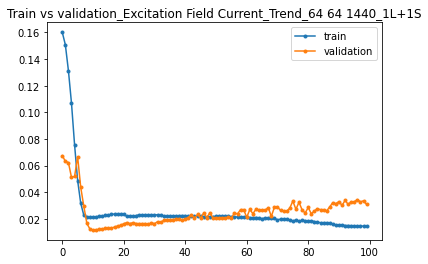

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_64 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_64 128 1440_1L+1S
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_12 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


333/338 [============================>.] - ETA: 0s - loss: 0.1556

338/338 [==============================] - 5s 8ms/step - loss: 0.1542 - val_loss: 0.0729
Epoch 2/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1368 - val_loss: 0.0656
Epoch 3/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1116 - val_loss: 0.0574
Epoch 4/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0802 - val_loss: 0.0659
Epoch 5/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0514 - val_loss: 0.0765
Epoch 6/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0328 - val_loss: 0.0395
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0225 - val_loss: 0.0282
Epoch 8/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0215 - val_loss: 0.0244
Epoch 9/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0216 - val_loss: 0.0158
Epoch 10/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0218 - val_loss: 0.0138
E

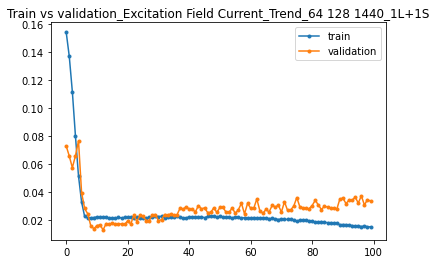

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_64 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_128 32 1440_1L+1S
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_13 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


167/169 [============================>.] - ETA: 0s - loss: 0.1912

169/169 [==============================] - 3s 7ms/step - loss: 0.1909 - val_loss: 0.1301
Epoch 2/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1664 - val_loss: 0.0918
Epoch 3/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1587 - val_loss: 0.0729
Epoch 4/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1553 - val_loss: 0.0656
Epoch 5/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1483 - val_loss: 0.0593
Epoch 6/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1396 - val_loss: 0.0535
Epoch 7/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1268 - val_loss: 0.0486
Epoch 8/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1110 - val_loss: 0.0428
Epoch 9/100
169/169 [==============================] - 1s 4ms/step - loss: 0.0890 - val_loss: 0.0368
Epoch 10/100
169/169 [==============================] - 1s 4ms/step - loss: 0.0620 - val_loss: 0.0369
E

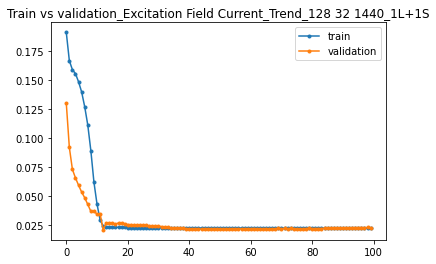

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_128 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_128 64 1440_1L+1S
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_14 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


165/169 [============================>.] - ETA: 0s - loss: 0.1864

169/169 [==============================] - 5s 13ms/step - loss: 0.1849 - val_loss: 0.0988
Epoch 2/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1647 - val_loss: 0.0714
Epoch 3/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1598 - val_loss: 0.0626
Epoch 4/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1517 - val_loss: 0.0573
Epoch 5/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1407 - val_loss: 0.0531
Epoch 6/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1251 - val_loss: 0.0477
Epoch 7/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1012 - val_loss: 0.0433
Epoch 8/100
169/169 [==============================] - 1s 5ms/step - loss: 0.0721 - val_loss: 0.0458
Epoch 9/100
169/169 [==============================] - 1s 5ms/step - loss: 0.0479 - val_loss: 0.0429
Epoch 10/100
169/169 [==============================] - 1s 5ms/step - loss: 0.0294 - val_loss: 0.0580


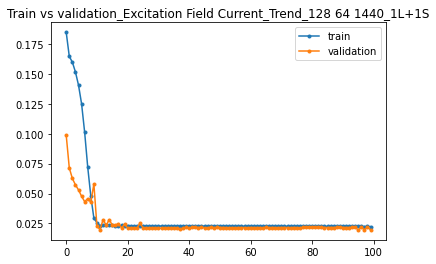

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_128 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_128 128 1440_1L+1S
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_15 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


In [ ]:
training_summary = []
LSTM_Layer = '1L+1S'
season = seasonals[0]

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

Training:  Excitation Field Current_Trend_8 32 1440_1L+1S
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_16 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2695/2700 [============================>.] - ETA: 0s - loss: 0.0707

2700/2700 [==============================] - 10s 3ms/step - loss: 0.0706 - val_loss: 0.0555
Epoch 2/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0283 - val_loss: 0.0443
Epoch 3/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0167 - val_loss: 0.0366
Epoch 4/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0119 - val_loss: 0.0299
Epoch 5/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0094 - val_loss: 0.0225
Epoch 6/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0078 - val_loss: 0.0146
Epoch 7/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0066 - val_loss: 0.0090
Epoch 8/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0058 - val_loss: 0.0126
Epoch 9/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0053 - val_loss: 0.0214
Epoch 10/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0049

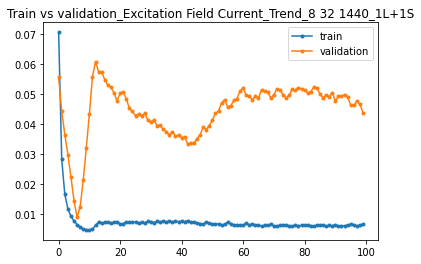

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_8 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_8 64 1440_1L+1S
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_17 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2694/2700 [============================>.] - ETA: 0s - loss: 0.0616

2700/2700 [==============================] - 10s 3ms/step - loss: 0.0615 - val_loss: 0.0576
Epoch 2/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0257 - val_loss: 0.0498
Epoch 3/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0164 - val_loss: 0.0438
Epoch 4/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0123 - val_loss: 0.0389
Epoch 5/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0099 - val_loss: 0.0336
Epoch 6/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0084 - val_loss: 0.0277
Epoch 7/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0072 - val_loss: 0.0207
Epoch 8/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0064 - val_loss: 0.0123
Epoch 9/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0056 - val_loss: 0.0105
Epoch 10/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0051

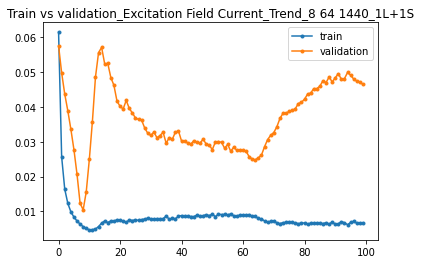

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_8 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_8 128 1440_1L+1S
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_18 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2692/2700 [============================>.] - ETA: 0s - loss: 0.0492

2700/2700 [==============================] - 11s 3ms/step - loss: 0.0490 - val_loss: 0.0588
Epoch 2/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0225 - val_loss: 0.0525
Epoch 3/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0146 - val_loss: 0.0477
Epoch 4/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0116 - val_loss: 0.0439
Epoch 5/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0096 - val_loss: 0.0405
Epoch 6/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0083 - val_loss: 0.0363
Epoch 7/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0074 - val_loss: 0.0317
Epoch 8/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0067 - val_loss: 0.0257
Epoch 9/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0060 - val_loss: 0.0193
Epoch 10/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0056

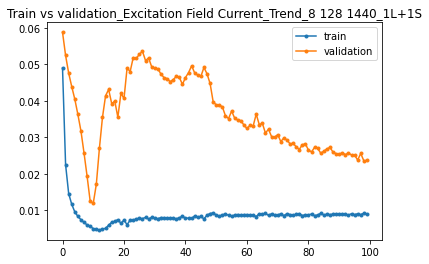

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_8 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_16 32 1440_1L+1S
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_19 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1349/1350 [============================>.] - ETA: 0s - loss: 0.1207

1350/1350 [==============================] - 6s 3ms/step - loss: 0.1206 - val_loss: 0.0580
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0711 - val_loss: 0.0426
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0352 - val_loss: 0.0320
Epoch 4/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0221 - val_loss: 0.0246
Epoch 5/100
1350/1350 [==============================] - 3s 3ms/step - loss: 0.0162 - val_loss: 0.0201
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0131 - val_loss: 0.0148
Epoch 7/100
1350/1350 [==============================] - 3s 3ms/step - loss: 0.0112 - val_loss: 0.0096
Epoch 8/100
1350/1350 [==============================] - 3s 3ms/step - loss: 0.0100 - val_loss: 0.0086
Epoch 9/100
1350/1350 [==============================] - 3s 3ms/step - loss: 0.0096 - val_loss: 0.0143
Epoch 10/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0113 

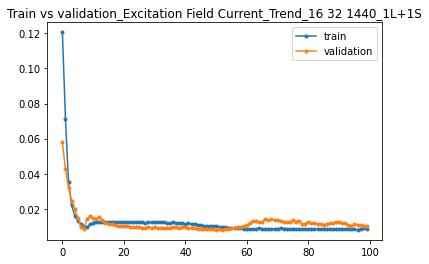

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_16 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_16 64 1440_1L+1S
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_20 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1336/1350 [============================>.] - ETA: 0s - loss: 0.1077

1350/1350 [==============================] - 6s 3ms/step - loss: 0.1068 - val_loss: 0.0561
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0563 - val_loss: 0.0432
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0300 - val_loss: 0.0345
Epoch 4/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0206 - val_loss: 0.0301
Epoch 5/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0165 - val_loss: 0.0264
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0137 - val_loss: 0.0236
Epoch 7/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0119 - val_loss: 0.0205
Epoch 8/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0103 - val_loss: 0.0161
Epoch 9/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0094 - val_loss: 0.0100
Epoch 10/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0087 

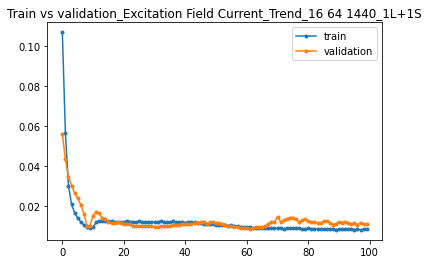

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_16 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_16 128 1440_1L+1S
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_21 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1349/1350 [============================>.] - ETA: 0s - loss: 0.0928

1350/1350 [==============================] - 8s 5ms/step - loss: 0.0927 - val_loss: 0.0569
Epoch 2/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0498 - val_loss: 0.0451
Epoch 3/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0284 - val_loss: 0.0381
Epoch 4/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0211 - val_loss: 0.0345
Epoch 5/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0178 - val_loss: 0.0319
Epoch 6/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0153 - val_loss: 0.0308
Epoch 7/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0141 - val_loss: 0.0306
Epoch 8/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0131 - val_loss: 0.0299
Epoch 9/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0124 - val_loss: 0.0287
Epoch 10/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0116 

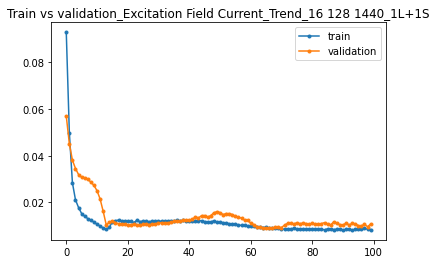

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_16 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_32 32 1440_1L+1S
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_22 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


672/675 [============================>.] - ETA: 0s - loss: 0.1463

675/675 [==============================] - 5s 5ms/step - loss: 0.1457 - val_loss: 0.0637
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1193 - val_loss: 0.0545
Epoch 3/100
675/675 [==============================] - 2s 4ms/step - loss: 0.0852 - val_loss: 0.0469
Epoch 4/100
675/675 [==============================] - 2s 4ms/step - loss: 0.0497 - val_loss: 0.0493
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0304 - val_loss: 0.0207
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0225 - val_loss: 0.0135
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0172 - val_loss: 0.0092
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0171 - val_loss: 0.0175
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0172 - val_loss: 0.0190
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0187 - val_loss: 0.0190
E

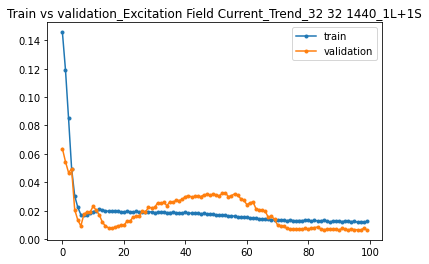

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_32 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_32 64 1440_1L+1S
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_23 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


669/675 [============================>.] - ETA: 0s - loss: 0.1412

675/675 [==============================] - 5s 4ms/step - loss: 0.1401 - val_loss: 0.0609
Epoch 2/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1055 - val_loss: 0.0508
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0683 - val_loss: 0.0442
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0389 - val_loss: 0.0245
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0248 - val_loss: 0.0160
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0197 - val_loss: 0.0139
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0166 - val_loss: 0.0147
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0157 - val_loss: 0.0191
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0162 - val_loss: 0.0204
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0172 - val_loss: 0.0241
E

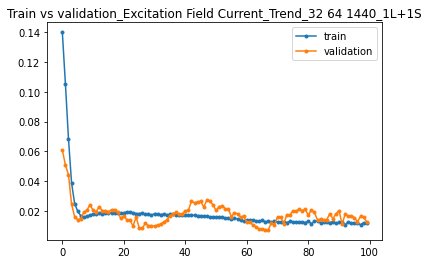

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_32 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_32 128 1440_1L+1S
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_24 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


670/675 [============================>.] - ETA: 0s - loss: 0.1356

675/675 [==============================] - 5s 5ms/step - loss: 0.1347 - val_loss: 0.0593
Epoch 2/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0934 - val_loss: 0.0676
Epoch 3/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0543 - val_loss: 0.0318
Epoch 4/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0334 - val_loss: 0.0234
Epoch 5/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0249 - val_loss: 0.0202
Epoch 6/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0199 - val_loss: 0.0169
Epoch 7/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0166 - val_loss: 0.0150
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0160 - val_loss: 0.0192
Epoch 9/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0150 - val_loss: 0.0184
Epoch 10/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0159 - val_loss: 0.0226
E

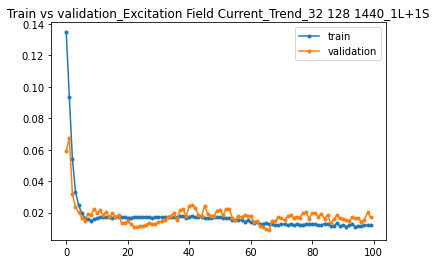

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_32 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_64 32 1440_1L+1S
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_25 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


335/338 [============================>.] - ETA: 0s - loss: 0.1690

338/338 [==============================] - 4s 5ms/step - loss: 0.1679 - val_loss: 0.0665
Epoch 2/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1576 - val_loss: 0.0626
Epoch 3/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1426 - val_loss: 0.0580
Epoch 4/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1203 - val_loss: 0.0562
Epoch 5/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0919 - val_loss: 0.0442
Epoch 6/100
338/338 [==============================] - 1s 3ms/step - loss: 0.0608 - val_loss: 0.0440
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0392 - val_loss: 0.0555
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0268 - val_loss: 0.0354
Epoch 9/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0218 - val_loss: 0.0259
Epoch 10/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0218 - val_loss: 0.0156
E

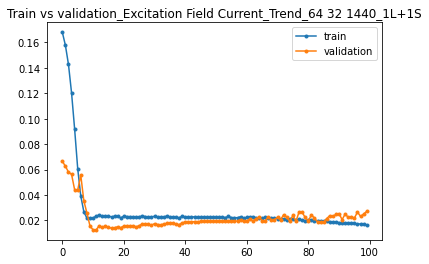

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_64 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_64 64 1440_1L+1S
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_26 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


331/338 [============================>.] - ETA: 0s - loss: 0.1593

338/338 [==============================] - 4s 5ms/step - loss: 0.1567 - val_loss: 0.0673
Epoch 2/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1462 - val_loss: 0.0642
Epoch 3/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1257 - val_loss: 0.0600
Epoch 4/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0978 - val_loss: 0.0502
Epoch 5/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0663 - val_loss: 0.0550
Epoch 6/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0433 - val_loss: 0.0661
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0300 - val_loss: 0.0364
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0220 - val_loss: 0.0327
Epoch 9/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0219 - val_loss: 0.0160
Epoch 10/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0213 - val_loss: 0.0112
E

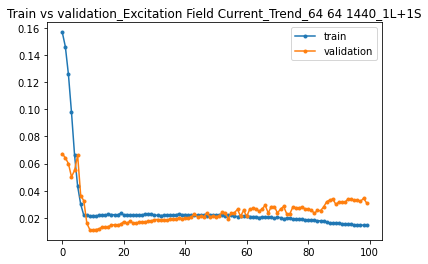

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_64 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_64 128 1440_1L+1S
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_27 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


333/338 [============================>.] - ETA: 0s - loss: 0.1548

338/338 [==============================] - 5s 8ms/step - loss: 0.1534 - val_loss: 0.0737
Epoch 2/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1353 - val_loss: 0.0617
Epoch 3/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1093 - val_loss: 0.0590
Epoch 4/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0773 - val_loss: 0.0680
Epoch 5/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0495 - val_loss: 0.0711
Epoch 6/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0307 - val_loss: 0.0341
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0218 - val_loss: 0.0254
Epoch 8/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0215 - val_loss: 0.0216
Epoch 9/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0217 - val_loss: 0.0134
Epoch 10/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0226 - val_loss: 0.0154
E

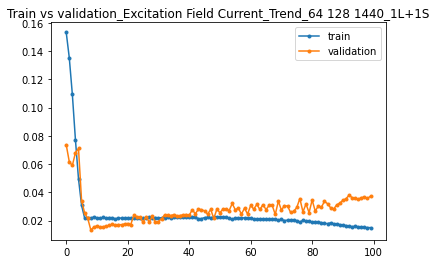

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_64 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_128 32 1440_1L+1S
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_28 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


167/169 [============================>.] - ETA: 0s - loss: 0.1994

169/169 [==============================] - 3s 7ms/step - loss: 0.1992 - val_loss: 0.1464
Epoch 2/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1679 - val_loss: 0.0938
Epoch 3/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1616 - val_loss: 0.0744
Epoch 4/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1581 - val_loss: 0.0671
Epoch 5/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1513 - val_loss: 0.0609
Epoch 6/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1434 - val_loss: 0.0554
Epoch 7/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1336 - val_loss: 0.0507
Epoch 8/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1187 - val_loss: 0.0462
Epoch 9/100
169/169 [==============================] - 1s 3ms/step - loss: 0.1034 - val_loss: 0.0399
Epoch 10/100
169/169 [==============================] - 1s 4ms/step - loss: 0.0770 - val_loss: 0.0366
E

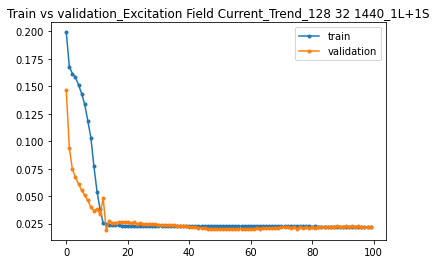

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_128 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_128 64 1440_1L+1S
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_29 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


160/169 [===========================>..] - ETA: 0s - loss: 0.1861

169/169 [==============================] - 3s 8ms/step - loss: 0.1832 - val_loss: 0.0944
Epoch 2/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1653 - val_loss: 0.0711
Epoch 3/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1607 - val_loss: 0.0634
Epoch 4/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1529 - val_loss: 0.0580
Epoch 5/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1432 - val_loss: 0.0540
Epoch 6/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1290 - val_loss: 0.0497
Epoch 7/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1117 - val_loss: 0.0441
Epoch 8/100
169/169 [==============================] - 1s 5ms/step - loss: 0.0849 - val_loss: 0.0451
Epoch 9/100
169/169 [==============================] - 1s 5ms/step - loss: 0.0600 - val_loss: 0.0382
Epoch 10/100
169/169 [==============================] - 1s 5ms/step - loss: 0.0407 - val_loss: 0.0429
E

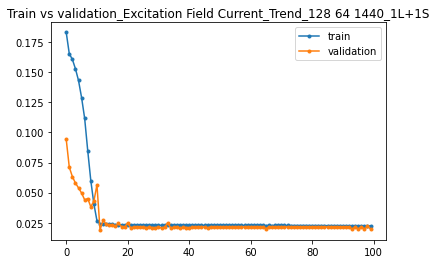

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_128 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Trend_128 128 1440_1L+1S
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_30 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


161/169 [===========================>..] - ETA: 0s - loss: 0.1717

169/169 [==============================] - 4s 14ms/step - loss: 0.1664 - val_loss: 0.0662
Epoch 2/100
169/169 [==============================] - 1s 7ms/step - loss: 0.1646 - val_loss: 0.0625
Epoch 3/100
169/169 [==============================] - 1s 7ms/step - loss: 0.1558 - val_loss: 0.0590
Epoch 4/100
169/169 [==============================] - 1s 7ms/step - loss: 0.1423 - val_loss: 0.0545
Epoch 5/100
169/169 [==============================] - 1s 7ms/step - loss: 0.1241 - val_loss: 0.0501
Epoch 6/100
169/169 [==============================] - 1s 7ms/step - loss: 0.0974 - val_loss: 0.0559
Epoch 7/100
169/169 [==============================] - 1s 7ms/step - loss: 0.0703 - val_loss: 0.0475
Epoch 8/100
169/169 [==============================] - 1s 7ms/step - loss: 0.0469 - val_loss: 0.0553
Epoch 9/100
169/169 [==============================] - 1s 7ms/step - loss: 0.0285 - val_loss: 0.0493
Epoch 10/100
169/169 [==============================] - 1s 7ms/step - loss: 0.0246 - val_loss: 0.0254


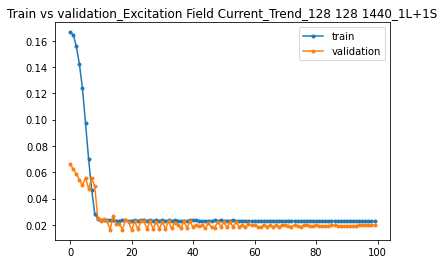

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Trend_128 128 1440_1L+1S.h5"
Export to: /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Training_summary_Excitation Field Current_Trend_1L+1S(2022-11-25_09:57:30).xlsx


In [ ]:
training_summary = []
season = seasonals[0]
LSTM_Layer = '2L'

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

In [ ]:
training_summary = []
season = seasonals[0]
LSTM_Layer = '1L'

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

Training:  Excitation Field Current_Trend_8 32 1440_1L
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2696/2700 [============================>.] - ETA: 0s - loss: 0.2282

2700/2700 [==============================] - 9s 3ms/step - loss: 0.2280 - val_loss: 0.0969
Epoch 2/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.1062 - val_loss: 0.0836
Epoch 3/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0825 - val_loss: 0.0781
Epoch 4/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0756 - val_loss: 0.0759
Epoch 5/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0740 - val_loss: 0.0750
Epoch 6/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0732 - val_loss: 0.0742
Epoch 7/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0731 - val_loss: 0.0738
Epoch 8/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0726 - val_loss: 0.0736
Epoch 9/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0719 - val_loss: 0.0734
Epoch 10/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0711 

KeyboardInterrupt: ignored

## Seasonal

Training:  Excitation Field Current_Seasonal_8 32 1440_
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1440, 32)          4352      
                                                                 
 dense (Dense)               (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2688/2700 [============================>.] - ETA: 0s - loss: 0.0727

2700/2700 [==============================] - 15s 5ms/step - loss: 0.0724 - val_loss: 0.0565
Epoch 2/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0281 - val_loss: 0.0449
Epoch 3/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0168 - val_loss: 0.0375
Epoch 4/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0120 - val_loss: 0.0310
Epoch 5/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0095 - val_loss: 0.0239
Epoch 6/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0079 - val_loss: 0.0161
Epoch 7/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0067 - val_loss: 0.0095
Epoch 8/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0058 - val_loss: 0.0129
Epoch 9/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0053 - val_loss: 0.0215
Epoch 10/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.00

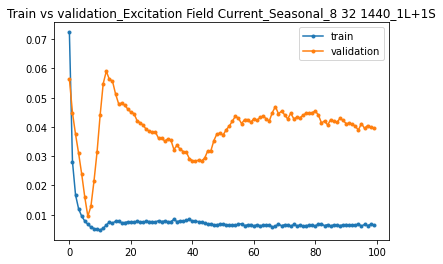

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_8 64 1440_
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_1 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2700/2700 [==============================] - ETA: 0s - loss: 0.0633

2700/2700 [==============================] - 13s 4ms/step - loss: 0.0633 - val_loss: 0.0577
Epoch 2/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0257 - val_loss: 0.0494
Epoch 3/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0164 - val_loss: 0.0429
Epoch 4/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0122 - val_loss: 0.0378
Epoch 5/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0098 - val_loss: 0.0323
Epoch 6/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0083 - val_loss: 0.0261
Epoch 7/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0071 - val_loss: 0.0184
Epoch 8/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0062 - val_loss: 0.0107
Epoch 9/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0054 - val_loss: 0.0109
Epoch 10/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0

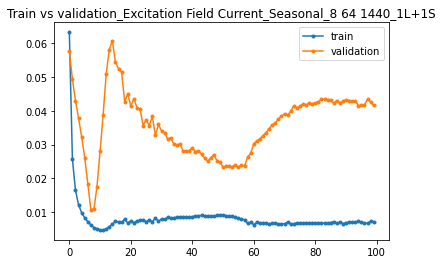

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_8 128 1440_
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1440, 128)         66560     
                                                                 
 dense_2 (Dense)             (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2699/2700 [============================>.] - ETA: 0s - loss: 0.0502

2700/2700 [==============================] - 14s 5ms/step - loss: 0.0502 - val_loss: 0.0587
Epoch 2/100
2700/2700 [==============================] - 12s 5ms/step - loss: 0.0224 - val_loss: 0.0526
Epoch 3/100
2700/2700 [==============================] - 12s 4ms/step - loss: 0.0152 - val_loss: 0.0474
Epoch 4/100
2700/2700 [==============================] - 12s 4ms/step - loss: 0.0117 - val_loss: 0.0438
Epoch 5/100
2700/2700 [==============================] - 12s 5ms/step - loss: 0.0099 - val_loss: 0.0400
Epoch 6/100
2700/2700 [==============================] - 12s 5ms/step - loss: 0.0085 - val_loss: 0.0359
Epoch 7/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0076 - val_loss: 0.0307
Epoch 8/100
2700/2700 [==============================] - 12s 5ms/step - loss: 0.0068 - val_loss: 0.0246
Epoch 9/100
2700/2700 [==============================] - 14s 5ms/step - loss: 0.0060 - val_loss: 0.0182
Epoch 10/100
2700/2700 [==============================] - 12s 4ms/step - los

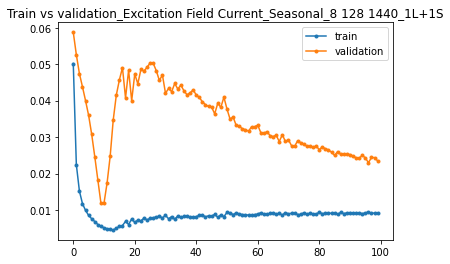

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_16 32 1440_
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_3 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1342/1350 [============================>.] - ETA: 0s - loss: 0.1156

1350/1350 [==============================] - 8s 4ms/step - loss: 0.1150 - val_loss: 0.0560
Epoch 2/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0656 - val_loss: 0.0411
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0333 - val_loss: 0.0315
Epoch 4/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0217 - val_loss: 0.0252
Epoch 5/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0162 - val_loss: 0.0198
Epoch 6/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0130 - val_loss: 0.0145
Epoch 7/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 8/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 9/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0100 - val_loss: 0.0153
Epoch 10/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0114 

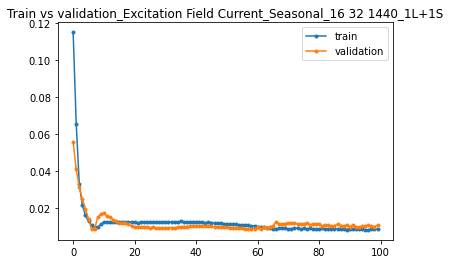

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_16 64 1440_
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_4 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1333/1350 [============================>.] - ETA: 0s - loss: 0.1091

1350/1350 [==============================] - 7s 4ms/step - loss: 0.1079 - val_loss: 0.0548
Epoch 2/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0562 - val_loss: 0.0430
Epoch 3/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0306 - val_loss: 0.0345
Epoch 4/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0210 - val_loss: 0.0288
Epoch 5/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0169 - val_loss: 0.0256
Epoch 6/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0136 - val_loss: 0.0228
Epoch 7/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0119 - val_loss: 0.0191
Epoch 8/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0104 - val_loss: 0.0142
Epoch 9/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 10/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0086 

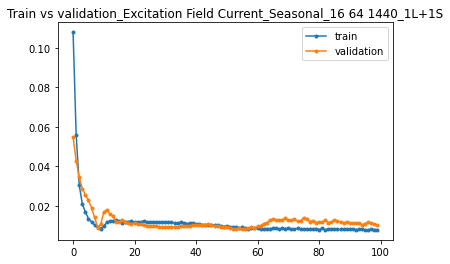

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_16 128 1440_
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1440, 128)         66560     
                                                                 
 dense_5 (Dense)             (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1342/1350 [============================>.] - ETA: 0s - loss: 0.0969

1350/1350 [==============================] - 8s 5ms/step - loss: 0.0963 - val_loss: 0.0578
Epoch 2/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0511 - val_loss: 0.0458
Epoch 3/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0292 - val_loss: 0.0383
Epoch 4/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0214 - val_loss: 0.0344
Epoch 5/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0179 - val_loss: 0.0326
Epoch 6/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0157 - val_loss: 0.0316
Epoch 7/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0145 - val_loss: 0.0310
Epoch 8/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0135 - val_loss: 0.0310
Epoch 9/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0128 - val_loss: 0.0298
Epoch 10/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0122 

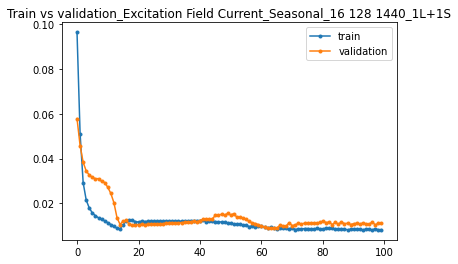

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_32 32 1440_
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_6 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


664/675 [============================>.] - ETA: 0s - loss: 0.1479

675/675 [==============================] - 5s 4ms/step - loss: 0.1458 - val_loss: 0.0636
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1194 - val_loss: 0.0545
Epoch 3/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0861 - val_loss: 0.0463
Epoch 4/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0508 - val_loss: 0.0395
Epoch 5/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0315 - val_loss: 0.0204
Epoch 6/100
675/675 [==============================] - 2s 4ms/step - loss: 0.0227 - val_loss: 0.0130
Epoch 7/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0178 - val_loss: 0.0083
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0168 - val_loss: 0.0150
Epoch 9/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0174 - val_loss: 0.0191
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0186 - val_loss: 0.0204
E

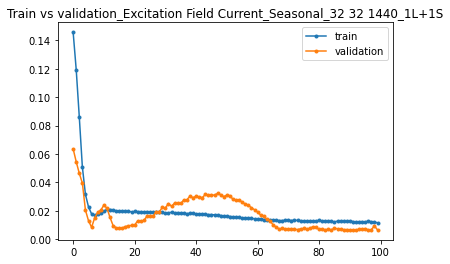

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_32 64 1440_
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1440, 64)          16896     
                                                                 
 dense_7 (Dense)             (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


664/675 [============================>.] - ETA: 0s - loss: 0.1437

675/675 [==============================] - 6s 5ms/step - loss: 0.1417 - val_loss: 0.0616
Epoch 2/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1058 - val_loss: 0.0518
Epoch 3/100
675/675 [==============================] - 2s 4ms/step - loss: 0.0680 - val_loss: 0.0475
Epoch 4/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0383 - val_loss: 0.0254
Epoch 5/100
675/675 [==============================] - 2s 4ms/step - loss: 0.0247 - val_loss: 0.0163
Epoch 6/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0198 - val_loss: 0.0153
Epoch 7/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0161 - val_loss: 0.0195
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0161 - val_loss: 0.0179
Epoch 9/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0165 - val_loss: 0.0231
Epoch 10/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0169 - val_loss: 0.0140
E

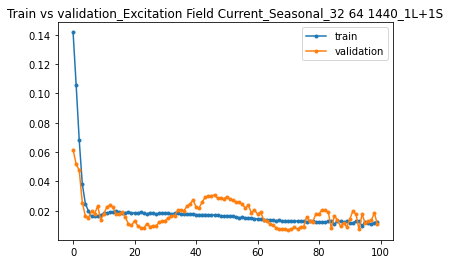

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_32 128 1440_
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1440, 128)         66560     
                                                                 
 dense_8 (Dense)             (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


675/675 [==============================] - ETA: 0s - loss: 0.1368

675/675 [==============================] - 6s 6ms/step - loss: 0.1368 - val_loss: 0.0599
Epoch 2/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0966 - val_loss: 0.0639
Epoch 3/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0576 - val_loss: 0.0312
Epoch 4/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0333 - val_loss: 0.0224
Epoch 5/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0240 - val_loss: 0.0193
Epoch 6/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0198 - val_loss: 0.0159
Epoch 7/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0167 - val_loss: 0.0148
Epoch 8/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0160 - val_loss: 0.0192
Epoch 9/100
675/675 [==============================] - 5s 8ms/step - loss: 0.0157 - val_loss: 0.0216
Epoch 10/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0168 - val_loss: 0.0201
E

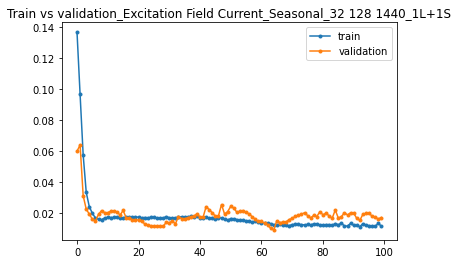

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_64 32 1440_
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1440, 32)          4352      
                                                                 
 dense_9 (Dense)             (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


335/338 [============================>.] - ETA: 0s - loss: 0.1637

338/338 [==============================] - 4s 6ms/step - loss: 0.1626 - val_loss: 0.0668
Epoch 2/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1574 - val_loss: 0.0622
Epoch 3/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1409 - val_loss: 0.0575
Epoch 4/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1192 - val_loss: 0.0563
Epoch 5/100
338/338 [==============================] - 2s 4ms/step - loss: 0.0940 - val_loss: 0.0448
Epoch 6/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0650 - val_loss: 0.0434
Epoch 7/100
338/338 [==============================] - 2s 5ms/step - loss: 0.0423 - val_loss: 0.0555
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0281 - val_loss: 0.0376
Epoch 9/100
338/338 [==============================] - 2s 4ms/step - loss: 0.0219 - val_loss: 0.0225
Epoch 10/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0214 - val_loss: 0.0118
E

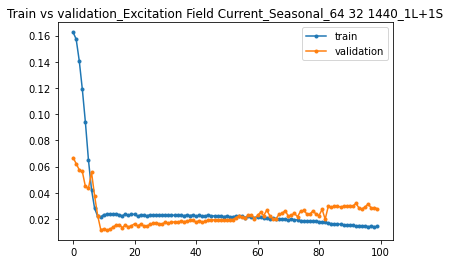

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_64 64 1440_
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_10 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


337/338 [============================>.] - ETA: 0s - loss: 0.1558

338/338 [==============================] - 4s 6ms/step - loss: 0.1556 - val_loss: 0.0671
Epoch 2/100
338/338 [==============================] - 2s 4ms/step - loss: 0.1450 - val_loss: 0.0640
Epoch 3/100
338/338 [==============================] - 2s 4ms/step - loss: 0.1245 - val_loss: 0.0599
Epoch 4/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0975 - val_loss: 0.0504
Epoch 5/100
338/338 [==============================] - 2s 5ms/step - loss: 0.0677 - val_loss: 0.0545
Epoch 6/100
338/338 [==============================] - 2s 5ms/step - loss: 0.0443 - val_loss: 0.0716
Epoch 7/100
338/338 [==============================] - 2s 5ms/step - loss: 0.0302 - val_loss: 0.0336
Epoch 8/100
338/338 [==============================] - 2s 4ms/step - loss: 0.0212 - val_loss: 0.0218
Epoch 9/100
338/338 [==============================] - 2s 5ms/step - loss: 0.0209 - val_loss: 0.0143
Epoch 10/100
338/338 [==============================] - 2s 4ms/step - loss: 0.0216 - val_loss: 0.0124
E

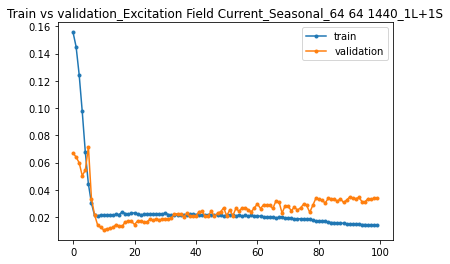

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_64 128 1440_
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_11 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


334/338 [============================>.] - ETA: 0s - loss: 0.1554

338/338 [==============================] - 5s 9ms/step - loss: 0.1542 - val_loss: 0.0727
Epoch 2/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1368 - val_loss: 0.0657
Epoch 3/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1114 - val_loss: 0.0570
Epoch 4/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0803 - val_loss: 0.0650
Epoch 5/100
338/338 [==============================] - 4s 10ms/step - loss: 0.0518 - val_loss: 0.0809
Epoch 6/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0339 - val_loss: 0.0431
Epoch 7/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0239 - val_loss: 0.0263
Epoch 8/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0215 - val_loss: 0.0239
Epoch 9/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0216 - val_loss: 0.0155
Epoch 10/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0217 - val_loss: 0.0140


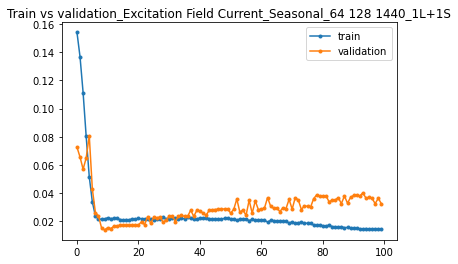

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_128 32 1440_
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_12 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


162/169 [===========================>..] - ETA: 0s - loss: 0.1952

169/169 [==============================] - 4s 8ms/step - loss: 0.1939 - val_loss: 0.1313
Epoch 2/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1681 - val_loss: 0.0925
Epoch 3/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1603 - val_loss: 0.0735
Epoch 4/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1569 - val_loss: 0.0664
Epoch 5/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1501 - val_loss: 0.0603
Epoch 6/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1422 - val_loss: 0.0548
Epoch 7/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1323 - val_loss: 0.0501
Epoch 8/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1176 - val_loss: 0.0456
Epoch 9/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1015 - val_loss: 0.0394
Epoch 10/100
169/169 [==============================] - 1s 5ms/step - loss: 0.0755 - val_loss: 0.0369
E

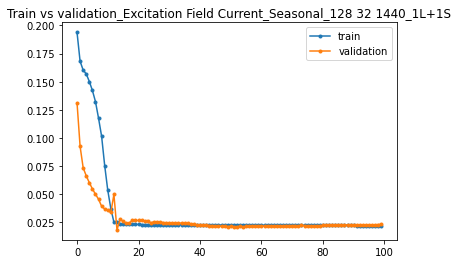

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_128 64 1440_
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_13 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


159/169 [===========================>..] - ETA: 0s - loss: 0.1893

169/169 [==============================] - 4s 10ms/step - loss: 0.1866 - val_loss: 0.0977
Epoch 2/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1659 - val_loss: 0.0710
Epoch 3/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1610 - val_loss: 0.0625
Epoch 4/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1533 - val_loss: 0.0578
Epoch 5/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1431 - val_loss: 0.0537
Epoch 6/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1282 - val_loss: 0.0489
Epoch 7/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1087 - val_loss: 0.0435
Epoch 8/100
169/169 [==============================] - 1s 6ms/step - loss: 0.0808 - val_loss: 0.0465
Epoch 9/100
169/169 [==============================] - 1s 6ms/step - loss: 0.0556 - val_loss: 0.0398
Epoch 10/100
169/169 [==============================] - 1s 6ms/step - loss: 0.0374 - val_loss: 0.0428


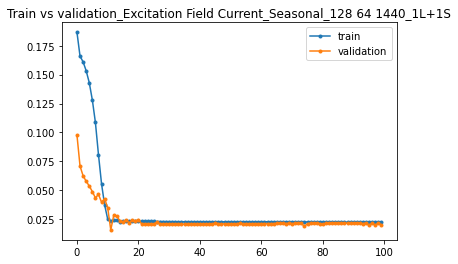

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Seasonal_128 128 1440_
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_14 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


163/169 [===========================>..] - ETA: 0s - loss: 0.1731

169/169 [==============================] - 5s 11ms/step - loss: 0.1689 - val_loss: 0.0668
Epoch 2/100
169/169 [==============================] - 2s 9ms/step - loss: 0.1648 - val_loss: 0.0626
Epoch 3/100
169/169 [==============================] - 2s 9ms/step - loss: 0.1558 - val_loss: 0.0591
Epoch 4/100
169/169 [==============================] - 2s 9ms/step - loss: 0.1423 - val_loss: 0.0544
Epoch 5/100
169/169 [==============================] - 2s 9ms/step - loss: 0.1236 - val_loss: 0.0501
Epoch 6/100
169/169 [==============================] - 1s 8ms/step - loss: 0.0953 - val_loss: 0.0541
Epoch 7/100
169/169 [==============================] - 1s 9ms/step - loss: 0.0655 - val_loss: 0.0477
Epoch 8/100
169/169 [==============================] - 1s 8ms/step - loss: 0.0436 - val_loss: 0.0574
Epoch 9/100
169/169 [==============================] - 1s 8ms/step - loss: 0.0277 - val_loss: 0.0450
Epoch 10/100
169/169 [==============================] - 2s 9ms/step - loss: 0.0250 - val_loss: 0.0201


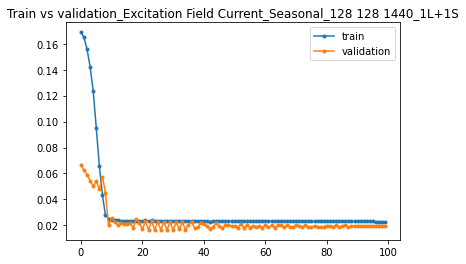

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 128 1440_1L+1S.h5"
Export to: /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Training_summary_Excitation Field Current_Seasonal_1L+1S(2022-11-24_12:28:25).xlsx


In [ ]:
training_summary = []
season = seasonals[1]
LSTM_Layer = '1L+1S'

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

Training:  Excitation Field Current_Seasonal_8 32 1440_2L
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_33 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2697/2700 [============================>.] - ETA: 0s - loss: 0.1016

2700/2700 [==============================] - 14s 4ms/step - loss: 0.1016 - val_loss: 0.0790
Epoch 2/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0744 - val_loss: 0.0788
Epoch 3/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0669 - val_loss: 0.0784
Epoch 4/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0612 - val_loss: 0.0780
Epoch 5/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0571 - val_loss: 0.0775
Epoch 6/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0542 - val_loss: 0.0768
Epoch 7/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0519 - val_loss: 0.0761
Epoch 8/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0504 - val_loss: 0.0750
Epoch 9/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0493 - val_loss: 0.0739
Epoch 10/100
2700/2700 [==============================] - 10s 4ms/step - los

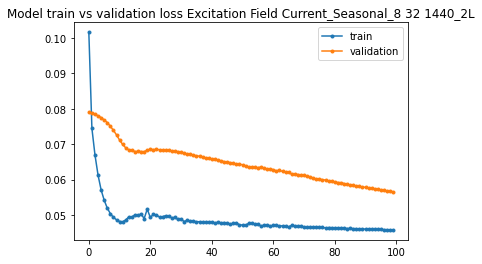

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 32 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_8 64 1440_2L
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_35 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2693/2700 [============================>.] - ETA: 0s - loss: 0.0920

2700/2700 [==============================] - 15s 4ms/step - loss: 0.0919 - val_loss: 0.0794
Epoch 2/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0720 - val_loss: 0.0792
Epoch 3/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0653 - val_loss: 0.0788
Epoch 4/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0602 - val_loss: 0.0785
Epoch 5/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0568 - val_loss: 0.0781
Epoch 6/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0542 - val_loss: 0.0776
Epoch 7/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0521 - val_loss: 0.0771
Epoch 8/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0504 - val_loss: 0.0764
Epoch 9/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0493 - val_loss: 0.0754
Epoch 10/100
2700/2700 [==============================] - 11s 4ms/step - los

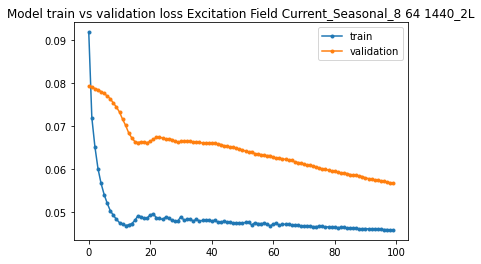

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 64 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_8 128 1440_2L
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_37 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2695/2700 [============================>.] - ETA: 0s - loss: 0.0854

2700/2700 [==============================] - 19s 6ms/step - loss: 0.0853 - val_loss: 0.0796
Epoch 2/100
2700/2700 [==============================] - 16s 6ms/step - loss: 0.0696 - val_loss: 0.0794
Epoch 3/100
2700/2700 [==============================] - 16s 6ms/step - loss: 0.0635 - val_loss: 0.0792
Epoch 4/100
2700/2700 [==============================] - 15s 6ms/step - loss: 0.0593 - val_loss: 0.0789
Epoch 5/100
2700/2700 [==============================] - 15s 5ms/step - loss: 0.0563 - val_loss: 0.0786
Epoch 6/100
2700/2700 [==============================] - 15s 5ms/step - loss: 0.0541 - val_loss: 0.0782
Epoch 7/100
2700/2700 [==============================] - 14s 5ms/step - loss: 0.0522 - val_loss: 0.0779
Epoch 8/100
2700/2700 [==============================] - 15s 5ms/step - loss: 0.0505 - val_loss: 0.0773
Epoch 9/100
2700/2700 [==============================] - 14s 5ms/step - loss: 0.0493 - val_loss: 0.0766
Epoch 10/100
2700/2700 [==============================] - 14s 5ms/step - los

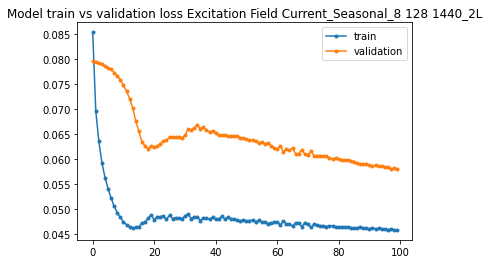

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 128 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_16 32 1440_2L
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_39 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1335/1350 [============================>.] - ETA: 0s - loss: 0.1498

1350/1350 [==============================] - 9s 5ms/step - loss: 0.1487 - val_loss: 0.0774
Epoch 2/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0842 - val_loss: 0.0768
Epoch 3/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0762 - val_loss: 0.0762
Epoch 4/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0706 - val_loss: 0.0758
Epoch 5/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0658 - val_loss: 0.0750
Epoch 6/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0612 - val_loss: 0.0740
Epoch 7/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0582 - val_loss: 0.0729
Epoch 8/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0579 - val_loss: 0.0717
Epoch 9/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0600 - val_loss: 0.0708
Epoch 10/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0598 

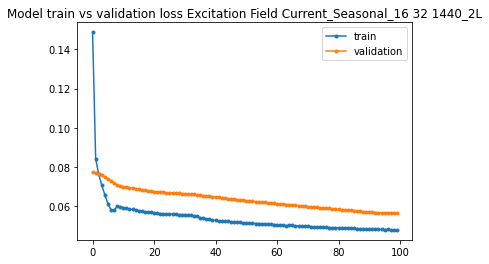

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 32 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_16 64 1440_2L
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_41 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1350/1350 [==============================] - ETA: 0s - loss: 0.1324

1350/1350 [==============================] - 9s 5ms/step - loss: 0.1324 - val_loss: 0.0778
Epoch 2/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0820 - val_loss: 0.0774
Epoch 3/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0751 - val_loss: 0.0769
Epoch 4/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0698 - val_loss: 0.0764
Epoch 5/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0654 - val_loss: 0.0759
Epoch 6/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0609 - val_loss: 0.0752
Epoch 7/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0577 - val_loss: 0.0742
Epoch 8/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0563 - val_loss: 0.0728
Epoch 9/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0565 - val_loss: 0.0717
Epoch 10/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0583 

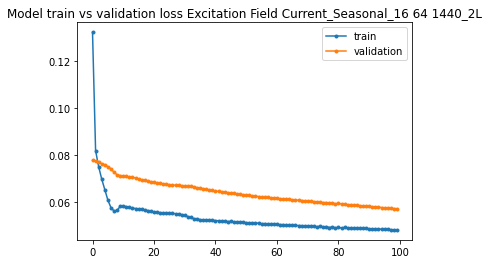

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 64 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_16 128 1440_2L
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_43 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1341/1350 [============================>.] - ETA: 0s - loss: 0.1204

1350/1350 [==============================] - 11s 6ms/step - loss: 0.1199 - val_loss: 0.0784
Epoch 2/100
1350/1350 [==============================] - 7s 6ms/step - loss: 0.0816 - val_loss: 0.0781
Epoch 3/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0749 - val_loss: 0.0778
Epoch 4/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0701 - val_loss: 0.0772
Epoch 5/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0653 - val_loss: 0.0769
Epoch 6/100
1350/1350 [==============================] - 7s 6ms/step - loss: 0.0613 - val_loss: 0.0764
Epoch 7/100
1350/1350 [==============================] - 9s 7ms/step - loss: 0.0580 - val_loss: 0.0759
Epoch 8/100
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0562 - val_loss: 0.0746
Epoch 9/100
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0545 - val_loss: 0.0732
Epoch 10/100
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0546

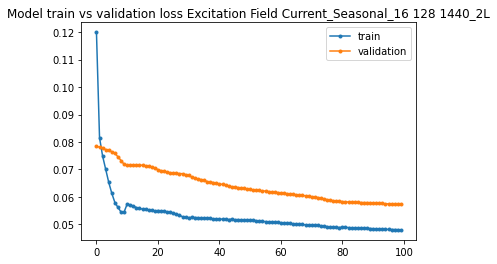

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 128 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_32 32 1440_2L
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_45 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


674/675 [============================>.] - ETA: 0s - loss: 0.2284

675/675 [==============================] - 7s 6ms/step - loss: 0.2282 - val_loss: 0.0780
Epoch 2/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1012 - val_loss: 0.0755
Epoch 3/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0856 - val_loss: 0.0743
Epoch 4/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0774 - val_loss: 0.0732
Epoch 5/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0739 - val_loss: 0.0720
Epoch 6/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0715 - val_loss: 0.0706
Epoch 7/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0693 - val_loss: 0.0699
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0684 - val_loss: 0.0696
Epoch 9/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0676 - val_loss: 0.0694
Epoch 10/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0667 - val_loss: 0.0692
E

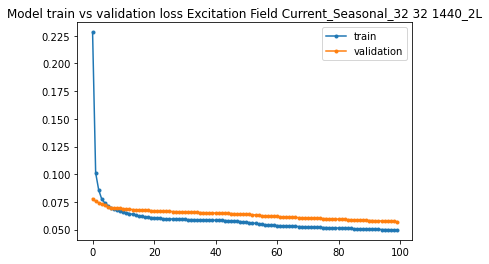

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 32 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_32 64 1440_2L
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_47 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


674/675 [============================>.] - ETA: 0s - loss: 0.1980

675/675 [==============================] - 7s 6ms/step - loss: 0.1979 - val_loss: 0.0765
Epoch 2/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0955 - val_loss: 0.0755
Epoch 3/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0843 - val_loss: 0.0745
Epoch 4/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0768 - val_loss: 0.0737
Epoch 5/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0731 - val_loss: 0.0728
Epoch 6/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0709 - val_loss: 0.0713
Epoch 7/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0683 - val_loss: 0.0702
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0674 - val_loss: 0.0698
Epoch 9/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0663 - val_loss: 0.0696
Epoch 10/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0652 - val_loss: 0.0693
E

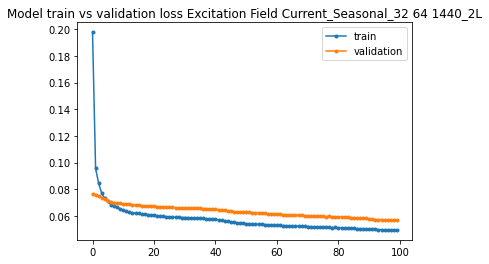

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 64 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_32 128 1440_2L
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_49 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


674/675 [============================>.] - ETA: 0s - loss: 0.1750

675/675 [==============================] - 9s 9ms/step - loss: 0.1748 - val_loss: 0.0767
Epoch 2/100
675/675 [==============================] - 6s 8ms/step - loss: 0.0941 - val_loss: 0.0761
Epoch 3/100
675/675 [==============================] - 6s 8ms/step - loss: 0.0836 - val_loss: 0.0752
Epoch 4/100
675/675 [==============================] - 6s 8ms/step - loss: 0.0767 - val_loss: 0.0747
Epoch 5/100
675/675 [==============================] - 5s 8ms/step - loss: 0.0731 - val_loss: 0.0742
Epoch 6/100
675/675 [==============================] - 6s 8ms/step - loss: 0.0707 - val_loss: 0.0732
Epoch 7/100
675/675 [==============================] - 5s 8ms/step - loss: 0.0678 - val_loss: 0.0720
Epoch 8/100
675/675 [==============================] - 6s 8ms/step - loss: 0.0665 - val_loss: 0.0709
Epoch 9/100
675/675 [==============================] - 6s 8ms/step - loss: 0.0656 - val_loss: 0.0704
Epoch 10/100
675/675 [==============================] - 6s 8ms/step - loss: 0.0645 - val_loss: 0.0700
E

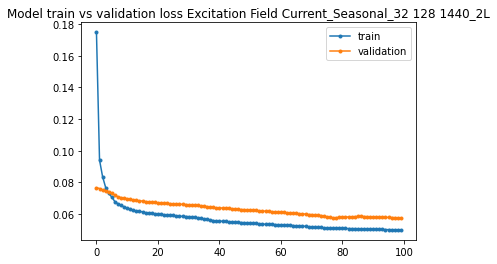

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 128 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_64 32 1440_2L
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_50 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_51 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


335/338 [============================>.] - ETA: 0s - loss: 0.3368

338/338 [==============================] - 6s 9ms/step - loss: 0.3352 - val_loss: 0.0950
Epoch 2/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1302 - val_loss: 0.0862
Epoch 3/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1128 - val_loss: 0.0805
Epoch 4/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0921 - val_loss: 0.0751
Epoch 5/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0831 - val_loss: 0.0734
Epoch 6/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0776 - val_loss: 0.0727
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0745 - val_loss: 0.0718
Epoch 8/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0738 - val_loss: 0.0713
Epoch 9/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0732 - val_loss: 0.0708
Epoch 10/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0723 - val_loss: 0.0704
E

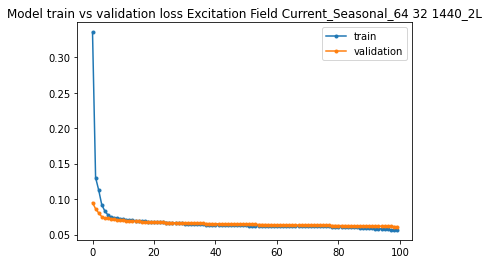

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 32 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_64 64 1440_2L
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_53 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


335/338 [============================>.] - ETA: 0s - loss: 0.2942

338/338 [==============================] - 7s 10ms/step - loss: 0.2927 - val_loss: 0.0827
Epoch 2/100
338/338 [==============================] - 3s 8ms/step - loss: 0.1234 - val_loss: 0.0778
Epoch 3/100
338/338 [==============================] - 3s 8ms/step - loss: 0.1010 - val_loss: 0.0741
Epoch 4/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0866 - val_loss: 0.0726
Epoch 5/100
338/338 [==============================] - 3s 9ms/step - loss: 0.0803 - val_loss: 0.0715
Epoch 6/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0758 - val_loss: 0.0706
Epoch 7/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0737 - val_loss: 0.0702
Epoch 8/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0729 - val_loss: 0.0699
Epoch 9/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0722 - val_loss: 0.0695
Epoch 10/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0716 - val_loss: 0.0692


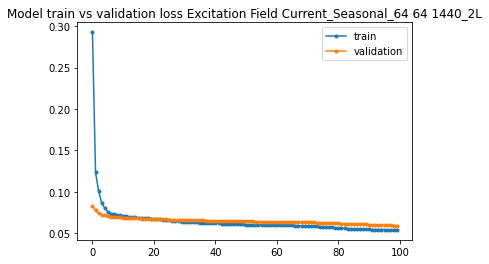

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 64 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_64 128 1440_2L
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_55 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


334/338 [============================>.] - ETA: 0s - loss: 0.2591

338/338 [==============================] - 9s 16ms/step - loss: 0.2571 - val_loss: 0.0776
Epoch 2/100
338/338 [==============================] - 5s 14ms/step - loss: 0.1190 - val_loss: 0.0748
Epoch 3/100
338/338 [==============================] - 5s 14ms/step - loss: 0.0963 - val_loss: 0.0735
Epoch 4/100
338/338 [==============================] - 5s 13ms/step - loss: 0.0860 - val_loss: 0.0723
Epoch 5/100
338/338 [==============================] - 5s 13ms/step - loss: 0.0788 - val_loss: 0.0710
Epoch 6/100
338/338 [==============================] - 5s 14ms/step - loss: 0.0754 - val_loss: 0.0703
Epoch 7/100
338/338 [==============================] - 5s 14ms/step - loss: 0.0744 - val_loss: 0.0700
Epoch 8/100
338/338 [==============================] - 5s 16ms/step - loss: 0.0735 - val_loss: 0.0696
Epoch 9/100
338/338 [==============================] - 5s 15ms/step - loss: 0.0727 - val_loss: 0.0693
Epoch 10/100
338/338 [==============================] - 4s 13ms/step - loss: 0.0719 - val_loss

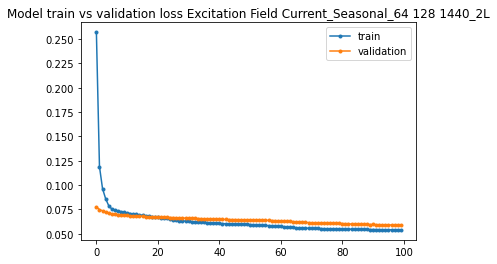

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 128 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_128 32 1440_2L
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_57 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


163/169 [===========================>..] - ETA: 0s - loss: 0.5207

169/169 [==============================] - 6s 15ms/step - loss: 0.5148 - val_loss: 0.3109
Epoch 2/100
169/169 [==============================] - 2s 10ms/step - loss: 0.1557 - val_loss: 0.1078
Epoch 3/100
169/169 [==============================] - 2s 11ms/step - loss: 0.1419 - val_loss: 0.1094
Epoch 4/100
169/169 [==============================] - 2s 11ms/step - loss: 0.1321 - val_loss: 0.1063
Epoch 5/100
169/169 [==============================] - 2s 10ms/step - loss: 0.1224 - val_loss: 0.1025
Epoch 6/100
169/169 [==============================] - 2s 10ms/step - loss: 0.1117 - val_loss: 0.0980
Epoch 7/100
169/169 [==============================] - 2s 10ms/step - loss: 0.1002 - val_loss: 0.0925
Epoch 8/100
169/169 [==============================] - 2s 10ms/step - loss: 0.0882 - val_loss: 0.0843
Epoch 9/100
169/169 [==============================] - 2s 10ms/step - loss: 0.0804 - val_loss: 0.0784
Epoch 10/100
169/169 [==============================] - 2s 10ms/step - loss: 0.0776 - val_loss

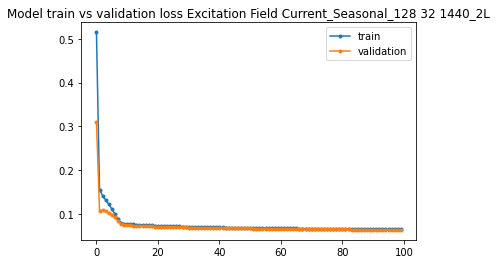

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 32 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_128 64 1440_2L
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_59 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


169/169 [==============================] - ETA: 0s - loss: 0.4493

169/169 [==============================] - 8s 21ms/step - loss: 0.4493 - val_loss: 0.1693
Epoch 2/100
169/169 [==============================] - 3s 16ms/step - loss: 0.1378 - val_loss: 0.1006
Epoch 3/100
169/169 [==============================] - 3s 15ms/step - loss: 0.1318 - val_loss: 0.0980
Epoch 4/100
169/169 [==============================] - 3s 15ms/step - loss: 0.1191 - val_loss: 0.0929
Epoch 5/100
169/169 [==============================] - 3s 15ms/step - loss: 0.1060 - val_loss: 0.0876
Epoch 6/100
169/169 [==============================] - 3s 15ms/step - loss: 0.0919 - val_loss: 0.0804
Epoch 7/100
169/169 [==============================] - 3s 15ms/step - loss: 0.0811 - val_loss: 0.0753
Epoch 8/100
169/169 [==============================] - 3s 15ms/step - loss: 0.0774 - val_loss: 0.0734
Epoch 9/100
169/169 [==============================] - 3s 15ms/step - loss: 0.0764 - val_loss: 0.0725
Epoch 10/100
169/169 [==============================] - 3s 15ms/step - loss: 0.0762 - val_loss

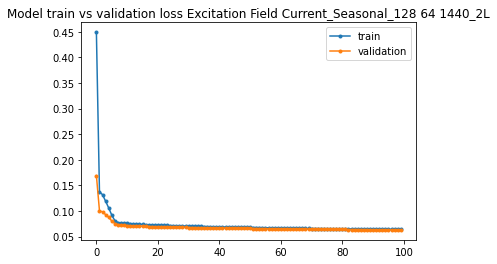

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 64 1440_2L.h5"
Training:  Excitation Field Current_Seasonal_128 128 1440_2L
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_61 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


169/169 [==============================] - ETA: 0s - loss: 0.3937

169/169 [==============================] - 10s 36ms/step - loss: 0.3937 - val_loss: 0.1095
Epoch 2/100
169/169 [==============================] - 5s 30ms/step - loss: 0.1383 - val_loss: 0.0924
Epoch 3/100
169/169 [==============================] - 5s 30ms/step - loss: 0.1256 - val_loss: 0.0870
Epoch 4/100
169/169 [==============================] - 5s 30ms/step - loss: 0.1094 - val_loss: 0.0816
Epoch 5/100
169/169 [==============================] - 5s 30ms/step - loss: 0.0923 - val_loss: 0.0756
Epoch 6/100
169/169 [==============================] - 5s 30ms/step - loss: 0.0814 - val_loss: 0.0727
Epoch 7/100
169/169 [==============================] - 5s 30ms/step - loss: 0.0783 - val_loss: 0.0718
Epoch 8/100
169/169 [==============================] - 5s 30ms/step - loss: 0.0773 - val_loss: 0.0711
Epoch 9/100
169/169 [==============================] - 5s 30ms/step - loss: 0.0767 - val_loss: 0.0707
Epoch 10/100
169/169 [==============================] - 5s 29ms/step - loss: 0.0762 - val_los

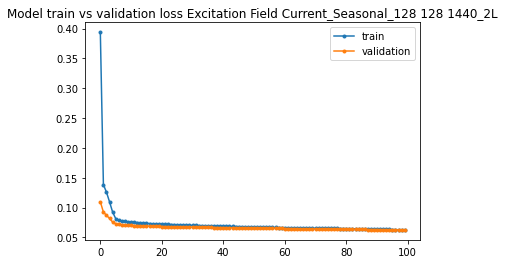

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 128 1440_2L.h5"
Export to: /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Training_summary_Excitation Field Current_Seasonal_2L(2022-11-25_16:56:30).xlsx


In [ ]:
training_summary = []
season = seasonals[1]
LSTM_Layer = '2L'

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

Training:  Excitation Field Current_Seasonal_8 32 1440_1L
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2679/2700 [============================>.] - ETA: 0s - loss: 0.2289

2700/2700 [==============================] - 9s 3ms/step - loss: 0.2280 - val_loss: 0.0972
Epoch 2/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.1054 - val_loss: 0.0835
Epoch 3/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0821 - val_loss: 0.0780
Epoch 4/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0756 - val_loss: 0.0759
Epoch 5/100
2700/2700 [==============================] - 7s 2ms/step - loss: 0.0741 - val_loss: 0.0750
Epoch 6/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0733 - val_loss: 0.0742
Epoch 7/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0731 - val_loss: 0.0739
Epoch 8/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0727 - val_loss: 0.0736
Epoch 9/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0720 - val_loss: 0.0734
Epoch 10/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0712

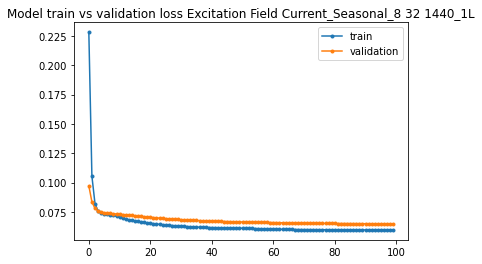

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 32 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_8 64 1440_1L
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2684/2700 [============================>.] - ETA: 0s - loss: 0.2267

2700/2700 [==============================] - 9s 3ms/step - loss: 0.2261 - val_loss: 0.0969
Epoch 2/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.1053 - val_loss: 0.0834
Epoch 3/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0820 - val_loss: 0.0779
Epoch 4/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0755 - val_loss: 0.0758
Epoch 5/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0740 - val_loss: 0.0750
Epoch 6/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0732 - val_loss: 0.0742
Epoch 7/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0731 - val_loss: 0.0738
Epoch 8/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0727 - val_loss: 0.0736
Epoch 9/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0720 - val_loss: 0.0734
Epoch 10/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0711 

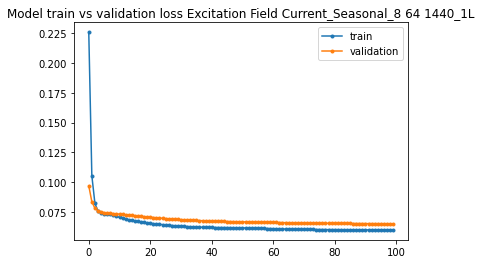

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 64 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_8 128 1440_1L
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2691/2700 [============================>.] - ETA: 0s - loss: 0.2248

2700/2700 [==============================] - 10s 3ms/step - loss: 0.2245 - val_loss: 0.0967
Epoch 2/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.1050 - val_loss: 0.0833
Epoch 3/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0818 - val_loss: 0.0779
Epoch 4/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0754 - val_loss: 0.0758
Epoch 5/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0741 - val_loss: 0.0750
Epoch 6/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0732 - val_loss: 0.0742
Epoch 7/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0732 - val_loss: 0.0738
Epoch 8/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0727 - val_loss: 0.0736
Epoch 9/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0720 - val_loss: 0.0734
Epoch 10/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.071

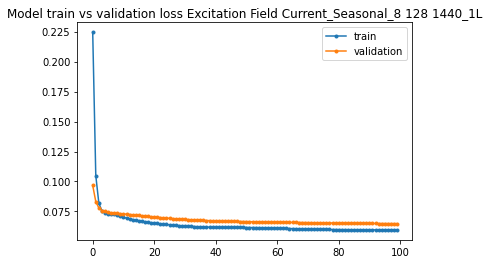

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_8 128 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_16 32 1440_1L
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1339/1350 [============================>.] - ETA: 0s - loss: 0.3242

1350/1350 [==============================] - 6s 3ms/step - loss: 0.3231 - val_loss: 0.1553
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1365 - val_loss: 0.1096
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1234 - val_loss: 0.1030
Epoch 4/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1032 - val_loss: 0.0939
Epoch 5/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0891 - val_loss: 0.0879
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0837 - val_loss: 0.0845
Epoch 7/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0815 - val_loss: 0.0815
Epoch 8/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0811 - val_loss: 0.0803
Epoch 9/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0807 - val_loss: 0.0798
Epoch 10/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0801 

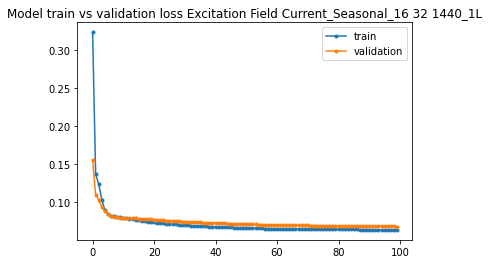

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 32 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_16 64 1440_1L
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1338/1350 [============================>.] - ETA: 0s - loss: 0.3200

1350/1350 [==============================] - 6s 3ms/step - loss: 0.3188 - val_loss: 0.1532
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1362 - val_loss: 0.1094
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1231 - val_loss: 0.1029
Epoch 4/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1025 - val_loss: 0.0936
Epoch 5/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0885 - val_loss: 0.0877
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0835 - val_loss: 0.0844
Epoch 7/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0815 - val_loss: 0.0813
Epoch 8/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0811 - val_loss: 0.0802
Epoch 9/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0807 - val_loss: 0.0798
Epoch 10/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0801 

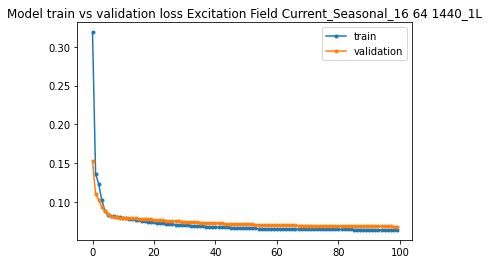

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 64 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_16 128 1440_1L
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1339/1350 [============================>.] - ETA: 0s - loss: 0.3178

1350/1350 [==============================] - 6s 4ms/step - loss: 0.3167 - val_loss: 0.1520
Epoch 2/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.1359 - val_loss: 0.1093
Epoch 3/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.1229 - val_loss: 0.1028
Epoch 4/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.1022 - val_loss: 0.0933
Epoch 5/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0884 - val_loss: 0.0876
Epoch 6/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0834 - val_loss: 0.0844
Epoch 7/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0814 - val_loss: 0.0812
Epoch 8/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0811 - val_loss: 0.0802
Epoch 9/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0807 - val_loss: 0.0798
Epoch 10/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0801 

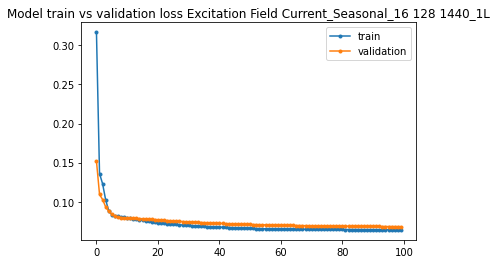

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_16 128 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_32 32 1440_1L
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


659/675 [============================>.] - ETA: 0s - loss: 0.4486

675/675 [==============================] - 4s 3ms/step - loss: 0.4461 - val_loss: 0.3175
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1853 - val_loss: 0.1619
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1425 - val_loss: 0.1272
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1358 - val_loss: 0.1188
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1296 - val_loss: 0.1160
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1216 - val_loss: 0.1142
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1119 - val_loss: 0.1122
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1013 - val_loss: 0.1080
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0932 - val_loss: 0.1012
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0890 - val_loss: 0.0957
E

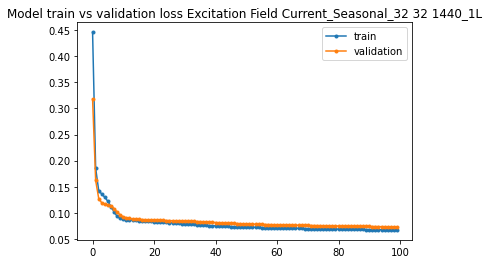

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 32 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_32 64 1440_1L
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


658/675 [============================>.] - ETA: 0s - loss: 0.4494

675/675 [==============================] - 4s 4ms/step - loss: 0.4466 - val_loss: 0.3137
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1837 - val_loss: 0.1606
Epoch 3/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1425 - val_loss: 0.1267
Epoch 4/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1361 - val_loss: 0.1185
Epoch 5/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1303 - val_loss: 0.1157
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1227 - val_loss: 0.1140
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1135 - val_loss: 0.1123
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1029 - val_loss: 0.1093
Epoch 9/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0933 - val_loss: 0.1025
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0886 - val_loss: 0.0957
E

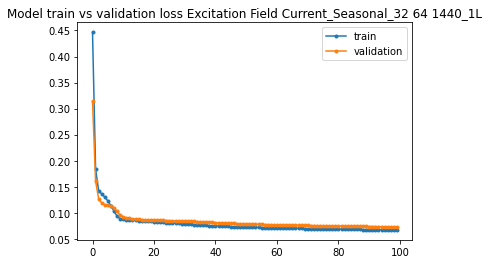

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 64 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_32 128 1440_1L
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


669/675 [============================>.] - ETA: 0s - loss: 0.4435

675/675 [==============================] - 6s 6ms/step - loss: 0.4426 - val_loss: 0.3099
Epoch 2/100
675/675 [==============================] - 3s 5ms/step - loss: 0.1822 - val_loss: 0.1599
Epoch 3/100
675/675 [==============================] - 4s 5ms/step - loss: 0.1421 - val_loss: 0.1264
Epoch 4/100
675/675 [==============================] - 4s 5ms/step - loss: 0.1358 - val_loss: 0.1184
Epoch 5/100
675/675 [==============================] - 4s 5ms/step - loss: 0.1300 - val_loss: 0.1157
Epoch 6/100
675/675 [==============================] - 4s 5ms/step - loss: 0.1223 - val_loss: 0.1139
Epoch 7/100
675/675 [==============================] - 3s 5ms/step - loss: 0.1130 - val_loss: 0.1122
Epoch 8/100
675/675 [==============================] - 4s 5ms/step - loss: 0.1024 - val_loss: 0.1094
Epoch 9/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0925 - val_loss: 0.1022
Epoch 10/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0882 - val_loss: 0.0950
E

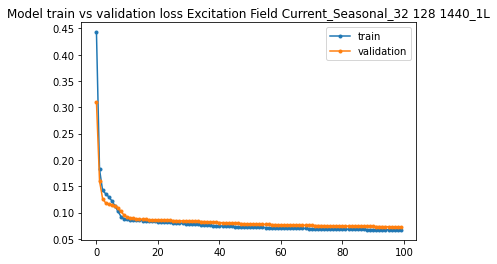

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_32 128 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_64 32 1440_1L
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


334/338 [============================>.] - ETA: 0s - loss: 0.5530

338/338 [==============================] - 4s 6ms/step - loss: 0.5532 - val_loss: 0.5338
Epoch 2/100
338/338 [==============================] - 2s 5ms/step - loss: 0.3407 - val_loss: 0.3171
Epoch 3/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2095 - val_loss: 0.2075
Epoch 4/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1602 - val_loss: 0.1638
Epoch 5/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1462 - val_loss: 0.1415
Epoch 6/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1410 - val_loss: 0.1313
Epoch 7/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1382 - val_loss: 0.1263
Epoch 8/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1355 - val_loss: 0.1235
Epoch 9/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1325 - val_loss: 0.1220
Epoch 10/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1291 - val_loss: 0.1211
E

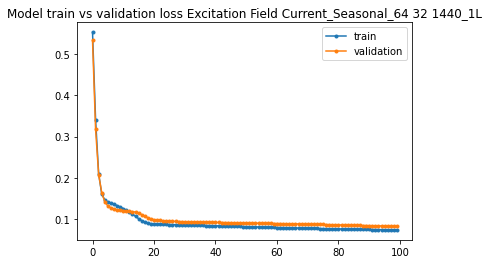

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 32 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_64 64 1440_1L
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


332/338 [============================>.] - ETA: 0s - loss: 0.5534

338/338 [==============================] - 4s 7ms/step - loss: 0.5535 - val_loss: 0.5298
Epoch 2/100
338/338 [==============================] - 3s 8ms/step - loss: 0.3370 - val_loss: 0.3133
Epoch 3/100
338/338 [==============================] - 3s 8ms/step - loss: 0.2071 - val_loss: 0.2050
Epoch 4/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1594 - val_loss: 0.1626
Epoch 5/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1460 - val_loss: 0.1407
Epoch 6/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1411 - val_loss: 0.1309
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1384 - val_loss: 0.1260
Epoch 8/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1358 - val_loss: 0.1234
Epoch 9/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1329 - val_loss: 0.1219
Epoch 10/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1295 - val_loss: 0.1210
E

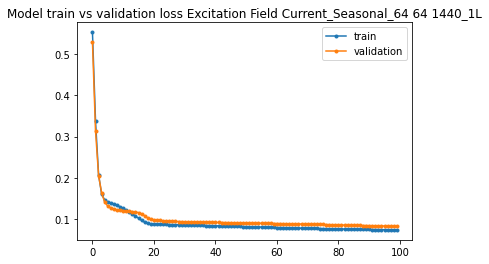

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 64 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_64 128 1440_1L
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


337/338 [============================>.] - ETA: 0s - loss: 0.5522

338/338 [==============================] - 6s 11ms/step - loss: 0.5523 - val_loss: 0.5276
Epoch 2/100
338/338 [==============================] - 4s 11ms/step - loss: 0.3357 - val_loss: 0.3123
Epoch 3/100
338/338 [==============================] - 3s 9ms/step - loss: 0.2066 - val_loss: 0.2046
Epoch 4/100
338/338 [==============================] - 4s 10ms/step - loss: 0.1593 - val_loss: 0.1624
Epoch 5/100
338/338 [==============================] - 3s 10ms/step - loss: 0.1460 - val_loss: 0.1407
Epoch 6/100
338/338 [==============================] - 3s 9ms/step - loss: 0.1411 - val_loss: 0.1309
Epoch 7/100
338/338 [==============================] - 3s 9ms/step - loss: 0.1384 - val_loss: 0.1260
Epoch 8/100
338/338 [==============================] - 3s 10ms/step - loss: 0.1358 - val_loss: 0.1234
Epoch 9/100
338/338 [==============================] - 3s 10ms/step - loss: 0.1329 - val_loss: 0.1219
Epoch 10/100
338/338 [==============================] - 3s 9ms/step - loss: 0.1295 - val_loss: 0.

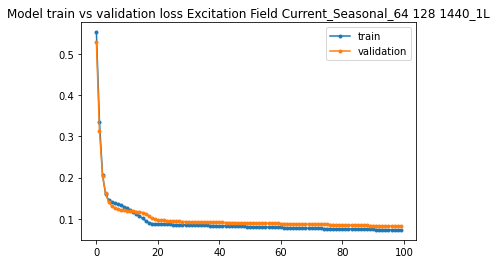

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_64 128 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_128 32 1440_1L
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


163/169 [===========================>..] - ETA: 0s - loss: 0.6027

169/169 [==============================] - 4s 11ms/step - loss: 0.6059 - val_loss: 0.6714
Epoch 2/100
169/169 [==============================] - 1s 8ms/step - loss: 0.5026 - val_loss: 0.5359
Epoch 3/100
169/169 [==============================] - 1s 8ms/step - loss: 0.3864 - val_loss: 0.4089
Epoch 4/100
169/169 [==============================] - 1s 8ms/step - loss: 0.2935 - val_loss: 0.3161
Epoch 5/100
169/169 [==============================] - 1s 8ms/step - loss: 0.2297 - val_loss: 0.2516
Epoch 6/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1882 - val_loss: 0.2082
Epoch 7/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1661 - val_loss: 0.1818
Epoch 8/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1549 - val_loss: 0.1642
Epoch 9/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1486 - val_loss: 0.1517
Epoch 10/100
169/169 [==============================] - 1s 9ms/step - loss: 0.1447 - val_loss: 0.1428


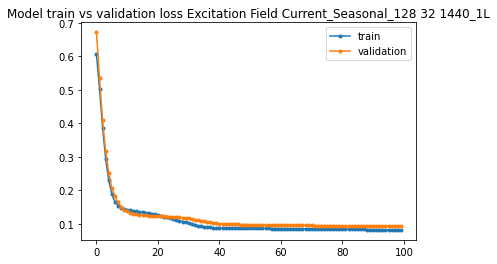

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 32 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_128 64 1440_1L
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


165/169 [============================>.] - ETA: 0s - loss: 0.6004

169/169 [==============================] - 4s 14ms/step - loss: 0.6024 - val_loss: 0.6646
Epoch 2/100
169/169 [==============================] - 2s 12ms/step - loss: 0.4955 - val_loss: 0.5267
Epoch 3/100
169/169 [==============================] - 2s 12ms/step - loss: 0.3793 - val_loss: 0.4015
Epoch 4/100
169/169 [==============================] - 2s 13ms/step - loss: 0.2882 - val_loss: 0.3106
Epoch 5/100
169/169 [==============================] - 2s 12ms/step - loss: 0.2259 - val_loss: 0.2476
Epoch 6/100
169/169 [==============================] - 2s 12ms/step - loss: 0.1856 - val_loss: 0.2054
Epoch 7/100
169/169 [==============================] - 2s 12ms/step - loss: 0.1645 - val_loss: 0.1799
Epoch 8/100
169/169 [==============================] - 2s 12ms/step - loss: 0.1538 - val_loss: 0.1627
Epoch 9/100
169/169 [==============================] - 2s 12ms/step - loss: 0.1478 - val_loss: 0.1506
Epoch 10/100
169/169 [==============================] - 2s 12ms/step - loss: 0.1441 - val_loss

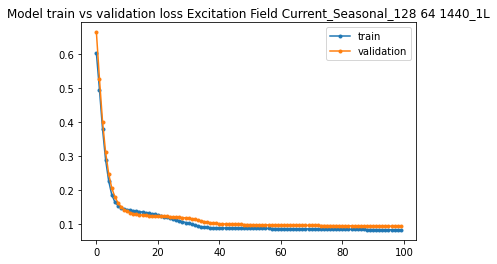

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 64 1440_1L.h5"
Training:  Excitation Field Current_Seasonal_128 128 1440_1L
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


169/169 [==============================] - ETA: 0s - loss: 0.6049

169/169 [==============================] - 7s 27ms/step - loss: 0.6049 - val_loss: 0.6667
Epoch 2/100
169/169 [==============================] - 4s 22ms/step - loss: 0.4960 - val_loss: 0.5263
Epoch 3/100
169/169 [==============================] - 4s 22ms/step - loss: 0.3785 - val_loss: 0.4001
Epoch 4/100
169/169 [==============================] - 4s 21ms/step - loss: 0.2871 - val_loss: 0.3093
Epoch 5/100
169/169 [==============================] - 4s 22ms/step - loss: 0.2250 - val_loss: 0.2464
Epoch 6/100
169/169 [==============================] - 4s 22ms/step - loss: 0.1849 - val_loss: 0.2044
Epoch 7/100
169/169 [==============================] - 4s 22ms/step - loss: 0.1641 - val_loss: 0.1792
Epoch 8/100
169/169 [==============================] - 4s 22ms/step - loss: 0.1536 - val_loss: 0.1621
Epoch 9/100
169/169 [==============================] - 4s 22ms/step - loss: 0.1477 - val_loss: 0.1502
Epoch 10/100
169/169 [==============================] - 4s 21ms/step - loss: 0.1441 - val_loss

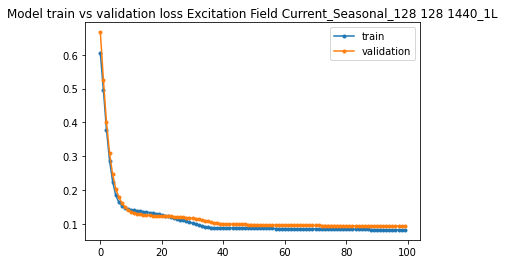

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Seasonal_128 128 1440_1L.h5"
Export to: /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Training_summary_Excitation Field Current_Seasonal_1L(2022-11-26_01:53:19).xlsx


In [ ]:
training_summary = []
season = seasonals[1]
LSTM_Layer = '1L'

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

## Residual

Training:  Excitation Field Current_Residual_8 32 1440_
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_15 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2690/2700 [============================>.] - ETA: 0s - loss: 0.0731

2700/2700 [==============================] - 14s 4ms/step - loss: 0.0729 - val_loss: 0.0566
Epoch 2/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0299 - val_loss: 0.0456
Epoch 3/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0173 - val_loss: 0.0391
Epoch 4/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0122 - val_loss: 0.0342
Epoch 5/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0096 - val_loss: 0.0291
Epoch 6/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0081 - val_loss: 0.0237
Epoch 7/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0071 - val_loss: 0.0174
Epoch 8/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0063 - val_loss: 0.0109
Epoch 9/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.0058 - val_loss: 0.0104
Epoch 10/100
2700/2700 [==============================] - 8s 3ms/step - loss: 0.005

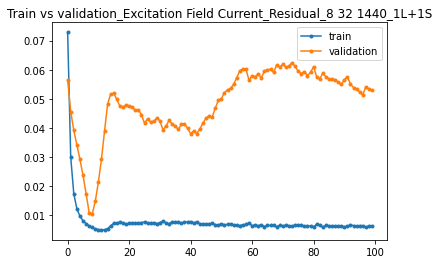

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_8 64 1440_
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_16 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2687/2700 [============================>.] - ETA: 0s - loss: 0.0635

2700/2700 [==============================] - 11s 4ms/step - loss: 0.0632 - val_loss: 0.0579
Epoch 2/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0269 - val_loss: 0.0498
Epoch 3/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0169 - val_loss: 0.0434
Epoch 4/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0127 - val_loss: 0.0383
Epoch 5/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0100 - val_loss: 0.0332
Epoch 6/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0085 - val_loss: 0.0271
Epoch 7/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0074 - val_loss: 0.0204
Epoch 8/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0064 - val_loss: 0.0121
Epoch 9/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0057 - val_loss: 0.0099
Epoch 10/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.

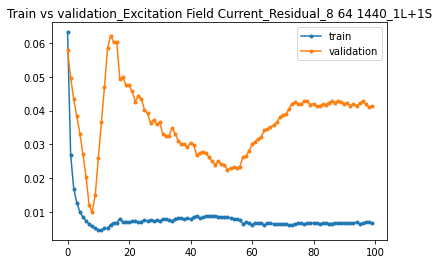

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_8 128 1440_
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_17 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2686/2700 [============================>.] - ETA: 0s - loss: 0.0484

2700/2700 [==============================] - 12s 4ms/step - loss: 0.0482 - val_loss: 0.0595
Epoch 2/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0221 - val_loss: 0.0537
Epoch 3/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0153 - val_loss: 0.0487
Epoch 4/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0120 - val_loss: 0.0452
Epoch 5/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0101 - val_loss: 0.0418
Epoch 6/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0087 - val_loss: 0.0382
Epoch 7/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0078 - val_loss: 0.0334
Epoch 8/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0070 - val_loss: 0.0273
Epoch 9/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0062 - val_loss: 0.0213
Epoch 10/100
2700/2700 [==============================] - 10s 4ms/step - los

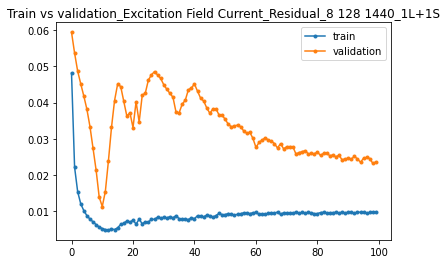

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_16 32 1440_
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_18 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1338/1350 [============================>.] - ETA: 0s - loss: 0.1164

1350/1350 [==============================] - 6s 3ms/step - loss: 0.1154 - val_loss: 0.0559
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0643 - val_loss: 0.0401
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 4/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0210 - val_loss: 0.0245
Epoch 5/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0156 - val_loss: 0.0198
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0130 - val_loss: 0.0151
Epoch 7/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0111 - val_loss: 0.0095
Epoch 8/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0103 - val_loss: 0.0084
Epoch 9/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0099 - val_loss: 0.0122
Epoch 10/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0110 

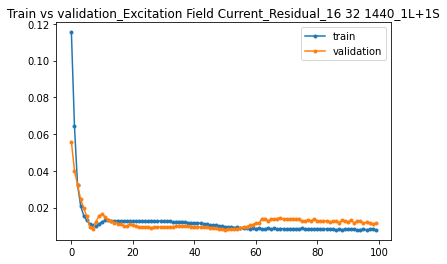

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_16 64 1440_
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_19 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1343/1350 [============================>.] - ETA: 0s - loss: 0.1113

1350/1350 [==============================] - 7s 4ms/step - loss: 0.1108 - val_loss: 0.0559
Epoch 2/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0588 - val_loss: 0.0425
Epoch 3/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0302 - val_loss: 0.0344
Epoch 4/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0208 - val_loss: 0.0283
Epoch 5/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0160 - val_loss: 0.0256
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0137 - val_loss: 0.0223
Epoch 7/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0117 - val_loss: 0.0185
Epoch 8/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0102 - val_loss: 0.0132
Epoch 9/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 10/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0089 

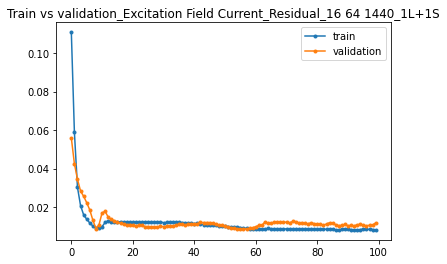

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_16 128 1440_
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_20 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1350/1350 [==============================] - ETA: 0s - loss: 0.0942

1350/1350 [==============================] - 8s 5ms/step - loss: 0.0942 - val_loss: 0.0574
Epoch 2/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0506 - val_loss: 0.0460
Epoch 3/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0292 - val_loss: 0.0387
Epoch 4/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0217 - val_loss: 0.0348
Epoch 5/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0179 - val_loss: 0.0335
Epoch 6/100
1350/1350 [==============================] - 6s 5ms/step - loss: 0.0162 - val_loss: 0.0325
Epoch 7/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0148 - val_loss: 0.0322
Epoch 8/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0138 - val_loss: 0.0320
Epoch 9/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0131 - val_loss: 0.0320
Epoch 10/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0128 

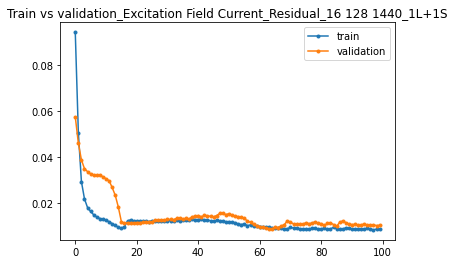

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_32 32 1440_
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_21 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


666/675 [============================>.] - ETA: 0s - loss: 0.1460

675/675 [==============================] - 4s 4ms/step - loss: 0.1443 - val_loss: 0.0631
Epoch 2/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1181 - val_loss: 0.0540
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0847 - val_loss: 0.0461
Epoch 4/100
675/675 [==============================] - 2s 4ms/step - loss: 0.0501 - val_loss: 0.0486
Epoch 5/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0306 - val_loss: 0.0189
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0224 - val_loss: 0.0108
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0174 - val_loss: 0.0078
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0177 - val_loss: 0.0168
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0182 - val_loss: 0.0202
Epoch 10/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0184 - val_loss: 0.0212
E

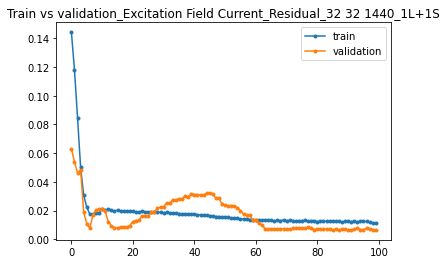

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_32 64 1440_
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_22 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


672/675 [============================>.] - ETA: 0s - loss: 0.1404

675/675 [==============================] - 4s 4ms/step - loss: 0.1398 - val_loss: 0.0610
Epoch 2/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1047 - val_loss: 0.0512
Epoch 3/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0680 - val_loss: 0.0481
Epoch 4/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0389 - val_loss: 0.0264
Epoch 5/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0250 - val_loss: 0.0173
Epoch 6/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0205 - val_loss: 0.0118
Epoch 7/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0165 - val_loss: 0.0134
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0160 - val_loss: 0.0200
Epoch 9/100
675/675 [==============================] - 2s 3ms/step - loss: 0.0168 - val_loss: 0.0211
Epoch 10/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0173 - val_loss: 0.0206
E

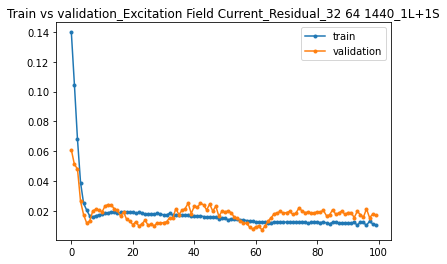

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_32 128 1440_
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_23 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


675/675 [==============================] - ETA: 0s - loss: 0.1356

675/675 [==============================] - 6s 6ms/step - loss: 0.1356 - val_loss: 0.0596
Epoch 2/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0946 - val_loss: 0.0642
Epoch 3/100
675/675 [==============================] - 4s 6ms/step - loss: 0.0568 - val_loss: 0.0318
Epoch 4/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0332 - val_loss: 0.0232
Epoch 5/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0248 - val_loss: 0.0199
Epoch 6/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0201 - val_loss: 0.0171
Epoch 7/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0171 - val_loss: 0.0188
Epoch 8/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0159 - val_loss: 0.0193
Epoch 9/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0161 - val_loss: 0.0186
Epoch 10/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0166 - val_loss: 0.0207
E

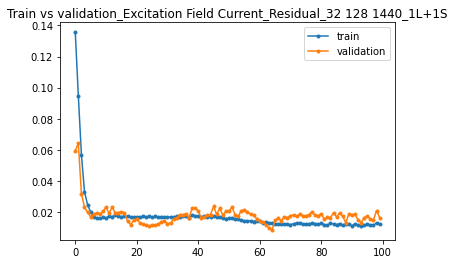

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_64 32 1440_
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_24 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


326/338 [===========================>..] - ETA: 0s - loss: 0.1637

338/338 [==============================] - 4s 5ms/step - loss: 0.1583 - val_loss: 0.0658
Epoch 2/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1531 - val_loss: 0.0612
Epoch 3/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1355 - val_loss: 0.0569
Epoch 4/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1103 - val_loss: 0.0566
Epoch 5/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0818 - val_loss: 0.0426
Epoch 6/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0530 - val_loss: 0.0493
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0330 - val_loss: 0.0613
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0263 - val_loss: 0.0357
Epoch 9/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0218 - val_loss: 0.0240
Epoch 10/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0216 - val_loss: 0.0149
E

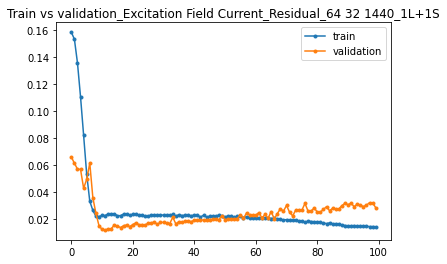

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_64 64 1440_
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_25 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


331/338 [============================>.] - ETA: 0s - loss: 0.1599

338/338 [==============================] - 5s 8ms/step - loss: 0.1573 - val_loss: 0.0674
Epoch 2/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1468 - val_loss: 0.0636
Epoch 3/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1278 - val_loss: 0.0627
Epoch 4/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1035 - val_loss: 0.0498
Epoch 5/100
338/338 [==============================] - 2s 4ms/step - loss: 0.0738 - val_loss: 0.0504
Epoch 6/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0480 - val_loss: 0.0661
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0310 - val_loss: 0.0403
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.0222 - val_loss: 0.0211
Epoch 9/100
338/338 [==============================] - 2s 4ms/step - loss: 0.0208 - val_loss: 0.0149
Epoch 10/100
338/338 [==============================] - 2s 4ms/step - loss: 0.0216 - val_loss: 0.0099
E

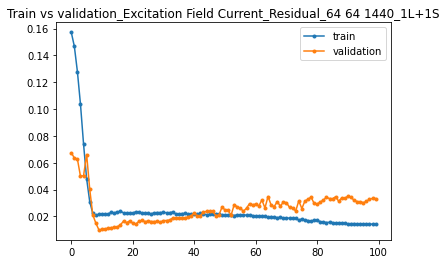

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_64 128 1440_
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_26 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


335/338 [============================>.] - ETA: 0s - loss: 0.1515

338/338 [==============================] - 5s 8ms/step - loss: 0.1507 - val_loss: 0.0746
Epoch 2/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1325 - val_loss: 0.0607
Epoch 3/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1052 - val_loss: 0.0596
Epoch 4/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0724 - val_loss: 0.0732
Epoch 5/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0474 - val_loss: 0.0662
Epoch 6/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0298 - val_loss: 0.0320
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0212 - val_loss: 0.0455
Epoch 8/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0224 - val_loss: 0.0222
Epoch 9/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0219 - val_loss: 0.0261
Epoch 10/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0211 - val_loss: 0.0142
E

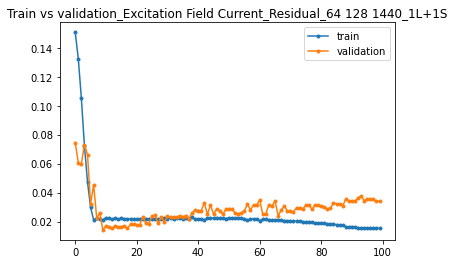

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 128 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_128 32 1440_
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 dense_27 (Dense)            (None, 1440, 1)           33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


156/169 [==========================>...] - ETA: 0s - loss: 0.1902

169/169 [==============================] - 3s 7ms/step - loss: 0.1904 - val_loss: 0.1256
Epoch 2/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1666 - val_loss: 0.0884
Epoch 3/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1592 - val_loss: 0.0711
Epoch 4/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1558 - val_loss: 0.0643
Epoch 5/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1485 - val_loss: 0.0583
Epoch 6/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1396 - val_loss: 0.0531
Epoch 7/100
169/169 [==============================] - 1s 4ms/step - loss: 0.1270 - val_loss: 0.0485
Epoch 8/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1117 - val_loss: 0.0429
Epoch 9/100
169/169 [==============================] - 1s 4ms/step - loss: 0.0908 - val_loss: 0.0371
Epoch 10/100
169/169 [==============================] - 1s 5ms/step - loss: 0.0645 - val_loss: 0.0376
E

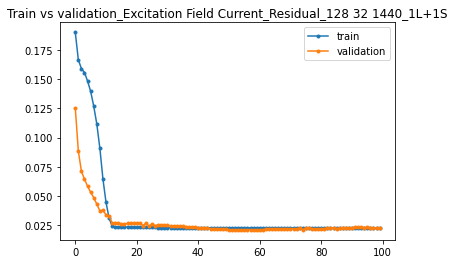

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 32 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_128 64 1440_
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_28 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


161/169 [===========================>..] - ETA: 0s - loss: 0.1806

169/169 [==============================] - 3s 8ms/step - loss: 0.1774 - val_loss: 0.0875
Epoch 2/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1627 - val_loss: 0.0679
Epoch 3/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1583 - val_loss: 0.0611
Epoch 4/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1497 - val_loss: 0.0565
Epoch 5/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1386 - val_loss: 0.0525
Epoch 6/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1238 - val_loss: 0.0474
Epoch 7/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1022 - val_loss: 0.0426
Epoch 8/100
169/169 [==============================] - 1s 6ms/step - loss: 0.0744 - val_loss: 0.0447
Epoch 9/100
169/169 [==============================] - 1s 6ms/step - loss: 0.0509 - val_loss: 0.0402
Epoch 10/100
169/169 [==============================] - 1s 6ms/step - loss: 0.0340 - val_loss: 0.0436
E

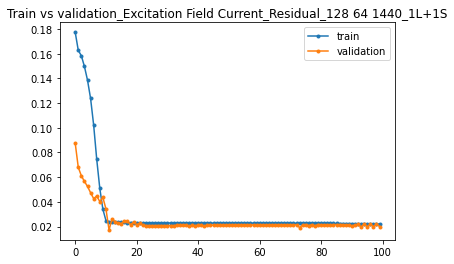

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 64 1440_1L+1S.h5"
Training:  Excitation Field Current_Residual_128 128 1440_
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 dense_29 (Dense)            (None, 1440, 1)           129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


168/169 [============================>.] - ETA: 0s - loss: 0.1689

169/169 [==============================] - 5s 12ms/step - loss: 0.1684 - val_loss: 0.0668
Epoch 2/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1640 - val_loss: 0.0624
Epoch 3/100
169/169 [==============================] - 2s 9ms/step - loss: 0.1558 - val_loss: 0.0589
Epoch 4/100
169/169 [==============================] - 2s 9ms/step - loss: 0.1426 - val_loss: 0.0543
Epoch 5/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1228 - val_loss: 0.0497
Epoch 6/100
169/169 [==============================] - 1s 8ms/step - loss: 0.0940 - val_loss: 0.0539
Epoch 7/100
169/169 [==============================] - 1s 8ms/step - loss: 0.0641 - val_loss: 0.0479
Epoch 8/100
169/169 [==============================] - 2s 9ms/step - loss: 0.0424 - val_loss: 0.0576
Epoch 9/100
169/169 [==============================] - 2s 9ms/step - loss: 0.0272 - val_loss: 0.0415
Epoch 10/100
169/169 [==============================] - 1s 9ms/step - loss: 0.0247 - val_loss: 0.0227


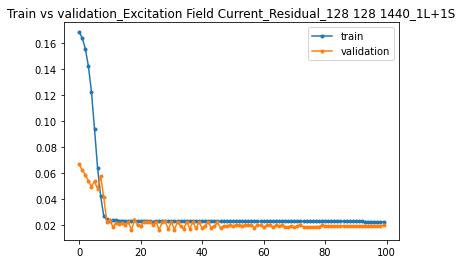

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 128 1440_1L+1S.h5"
Export to: /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Training_summary_Excitation Field Current_Residual_1L+1S(2022-11-24_12:28:25).xlsx


In [ ]:
training_summary = []
season = seasonals[2]
LSTM_Layer = '1L+1S'

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

Training:  Excitation Field Current_Residual_8 32 1440_2L
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_16 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2698/2700 [============================>.] - ETA: 0s - loss: 0.1017

2700/2700 [==============================] - 14s 4ms/step - loss: 0.1017 - val_loss: 0.0790
Epoch 2/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0740 - val_loss: 0.0788
Epoch 3/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0665 - val_loss: 0.0784
Epoch 4/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0608 - val_loss: 0.0780
Epoch 5/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0566 - val_loss: 0.0775
Epoch 6/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0538 - val_loss: 0.0767
Epoch 7/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.0517 - val_loss: 0.0759
Epoch 8/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0500 - val_loss: 0.0748
Epoch 9/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0492 - val_loss: 0.0736
Epoch 10/100
2700/2700 [==============================] - 9s 3ms/step - loss: 0.04

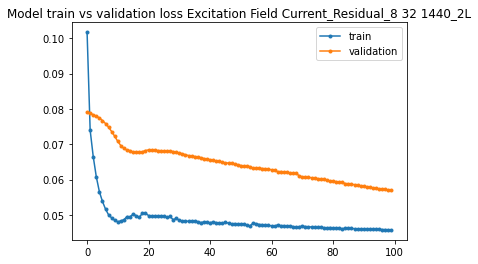

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 32 1440_2L.h5"
Training:  Excitation Field Current_Residual_8 64 1440_2L
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_18 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2694/2700 [============================>.] - ETA: 0s - loss: 0.0915

2700/2700 [==============================] - 15s 5ms/step - loss: 0.0915 - val_loss: 0.0794
Epoch 2/100
2700/2700 [==============================] - 12s 5ms/step - loss: 0.0717 - val_loss: 0.0791
Epoch 3/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0649 - val_loss: 0.0788
Epoch 4/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0600 - val_loss: 0.0785
Epoch 5/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0566 - val_loss: 0.0781
Epoch 6/100
2700/2700 [==============================] - 11s 4ms/step - loss: 0.0540 - val_loss: 0.0777
Epoch 7/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0520 - val_loss: 0.0771
Epoch 8/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0504 - val_loss: 0.0763
Epoch 9/100
2700/2700 [==============================] - 10s 4ms/step - loss: 0.0493 - val_loss: 0.0754
Epoch 10/100
2700/2700 [==============================] - 10s 4ms/step - los

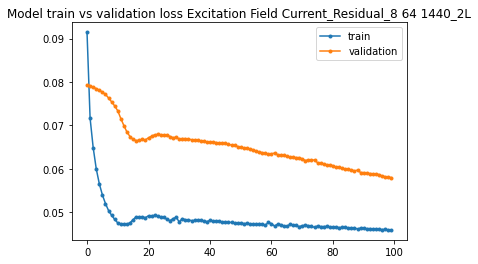

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 64 1440_2L.h5"
Training:  Excitation Field Current_Residual_8 128 1440_2L
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_20 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2699/2700 [============================>.] - ETA: 0s - loss: 0.0854

2700/2700 [==============================] - 16s 5ms/step - loss: 0.0854 - val_loss: 0.0796
Epoch 2/100
2700/2700 [==============================] - 13s 5ms/step - loss: 0.0694 - val_loss: 0.0794
Epoch 3/100
2700/2700 [==============================] - 13s 5ms/step - loss: 0.0634 - val_loss: 0.0792
Epoch 4/100
2700/2700 [==============================] - 14s 5ms/step - loss: 0.0592 - val_loss: 0.0789
Epoch 5/100
2700/2700 [==============================] - 14s 5ms/step - loss: 0.0563 - val_loss: 0.0786
Epoch 6/100
2700/2700 [==============================] - 14s 5ms/step - loss: 0.0540 - val_loss: 0.0782
Epoch 7/100
2700/2700 [==============================] - 14s 5ms/step - loss: 0.0521 - val_loss: 0.0779
Epoch 8/100
2700/2700 [==============================] - 13s 5ms/step - loss: 0.0505 - val_loss: 0.0773
Epoch 9/100
2700/2700 [==============================] - 16s 6ms/step - loss: 0.0493 - val_loss: 0.0765
Epoch 10/100
2700/2700 [==============================] - 13s 5ms/step - los

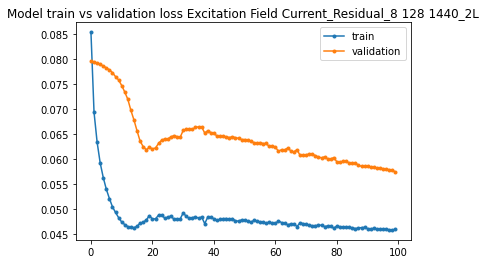

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 128 1440_2L.h5"
Training:  Excitation Field Current_Residual_16 32 1440_2L
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_22 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1344/1350 [============================>.] - ETA: 0s - loss: 0.1511

1350/1350 [==============================] - 9s 4ms/step - loss: 0.1507 - val_loss: 0.0774
Epoch 2/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0842 - val_loss: 0.0768
Epoch 3/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0761 - val_loss: 0.0762
Epoch 4/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0705 - val_loss: 0.0757
Epoch 5/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0657 - val_loss: 0.0751
Epoch 6/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0610 - val_loss: 0.0740
Epoch 7/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0580 - val_loss: 0.0728
Epoch 8/100
1350/1350 [==============================] - 5s 3ms/step - loss: 0.0579 - val_loss: 0.0716
Epoch 9/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0597 - val_loss: 0.0706
Epoch 10/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0597 

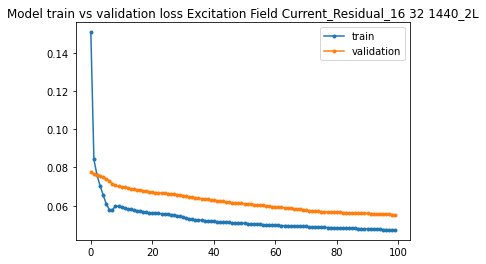

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 32 1440_2L.h5"
Training:  Excitation Field Current_Residual_16 64 1440_2L
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_24 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1340/1350 [============================>.] - ETA: 0s - loss: 0.1332

1350/1350 [==============================] - 9s 5ms/step - loss: 0.1326 - val_loss: 0.0778
Epoch 2/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0821 - val_loss: 0.0774
Epoch 3/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0748 - val_loss: 0.0770
Epoch 4/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0698 - val_loss: 0.0764
Epoch 5/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0652 - val_loss: 0.0760
Epoch 6/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0608 - val_loss: 0.0752
Epoch 7/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0575 - val_loss: 0.0742
Epoch 8/100
1350/1350 [==============================] - 6s 4ms/step - loss: 0.0561 - val_loss: 0.0727
Epoch 9/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0565 - val_loss: 0.0717
Epoch 10/100
1350/1350 [==============================] - 5s 4ms/step - loss: 0.0582 

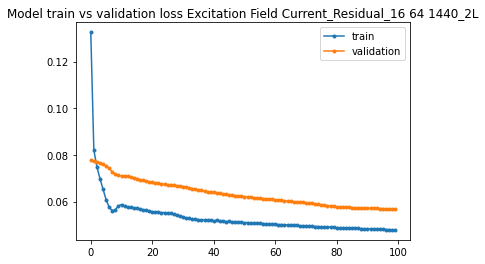

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 64 1440_2L.h5"
Training:  Excitation Field Current_Residual_16 128 1440_2L
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_26 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1349/1350 [============================>.] - ETA: 0s - loss: 0.1207

1350/1350 [==============================] - 13s 7ms/step - loss: 0.1207 - val_loss: 0.0784
Epoch 2/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0813 - val_loss: 0.0782
Epoch 3/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0750 - val_loss: 0.0778
Epoch 4/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0699 - val_loss: 0.0774
Epoch 5/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0648 - val_loss: 0.0771
Epoch 6/100
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0614 - val_loss: 0.0765
Epoch 7/100
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0581 - val_loss: 0.0759
Epoch 8/100
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0561 - val_loss: 0.0748
Epoch 9/100
1350/1350 [==============================] - 7s 5ms/step - loss: 0.0547 - val_loss: 0.0734
Epoch 10/100
1350/1350 [==============================] - 8s 6ms/step - loss: 0.0544

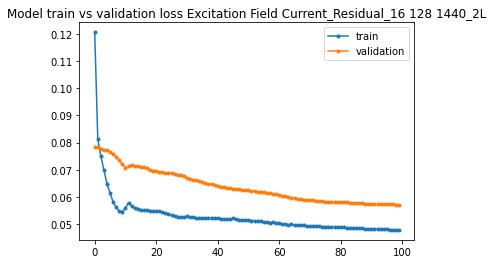

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 128 1440_2L.h5"
Training:  Excitation Field Current_Residual_32 32 1440_2L
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_28 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


671/675 [============================>.] - ETA: 0s - loss: 0.2325

675/675 [==============================] - 7s 5ms/step - loss: 0.2316 - val_loss: 0.0780
Epoch 2/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1009 - val_loss: 0.0755
Epoch 3/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0858 - val_loss: 0.0742
Epoch 4/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0773 - val_loss: 0.0731
Epoch 5/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0739 - val_loss: 0.0718
Epoch 6/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0714 - val_loss: 0.0705
Epoch 7/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0692 - val_loss: 0.0699
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0683 - val_loss: 0.0696
Epoch 9/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0675 - val_loss: 0.0694
Epoch 10/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0666 - val_loss: 0.0691
E

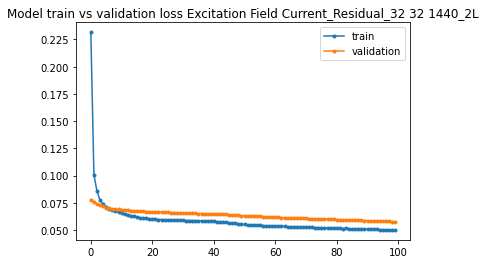

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 32 1440_2L.h5"
Training:  Excitation Field Current_Residual_32 64 1440_2L
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_30 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


668/675 [============================>.] - ETA: 0s - loss: 0.1986

675/675 [==============================] - 7s 6ms/step - loss: 0.1971 - val_loss: 0.0765
Epoch 2/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0955 - val_loss: 0.0755
Epoch 3/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0844 - val_loss: 0.0746
Epoch 4/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0770 - val_loss: 0.0737
Epoch 5/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0730 - val_loss: 0.0729
Epoch 6/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0709 - val_loss: 0.0714
Epoch 7/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0683 - val_loss: 0.0702
Epoch 8/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0675 - val_loss: 0.0698
Epoch 9/100
675/675 [==============================] - 3s 5ms/step - loss: 0.0662 - val_loss: 0.0696
Epoch 10/100
675/675 [==============================] - 4s 5ms/step - loss: 0.0652 - val_loss: 0.0694
E

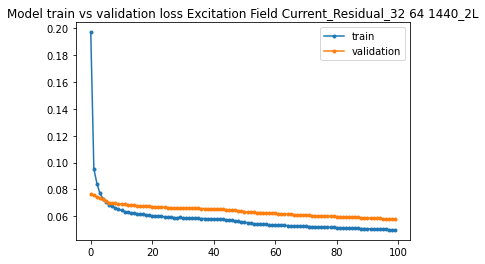

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 64 1440_2L.h5"
Training:  Excitation Field Current_Residual_32 128 1440_2L
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_32 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


675/675 [==============================] - ETA: 0s - loss: 0.1741

675/675 [==============================] - 10s 10ms/step - loss: 0.1741 - val_loss: 0.0767
Epoch 2/100
675/675 [==============================] - 6s 9ms/step - loss: 0.0942 - val_loss: 0.0761
Epoch 3/100
675/675 [==============================] - 7s 10ms/step - loss: 0.0836 - val_loss: 0.0752
Epoch 4/100
675/675 [==============================] - 6s 9ms/step - loss: 0.0768 - val_loss: 0.0747
Epoch 5/100
675/675 [==============================] - 6s 9ms/step - loss: 0.0730 - val_loss: 0.0742
Epoch 6/100
675/675 [==============================] - 6s 9ms/step - loss: 0.0707 - val_loss: 0.0732
Epoch 7/100
675/675 [==============================] - 6s 9ms/step - loss: 0.0678 - val_loss: 0.0720
Epoch 8/100
675/675 [==============================] - 6s 9ms/step - loss: 0.0670 - val_loss: 0.0709
Epoch 9/100
675/675 [==============================] - 6s 9ms/step - loss: 0.0656 - val_loss: 0.0705
Epoch 10/100
675/675 [==============================] - 6s 10ms/step - loss: 0.0646 - val_loss: 0.07

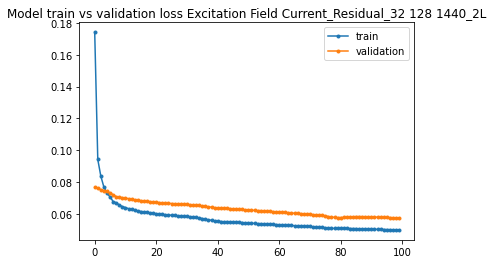

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 128 1440_2L.h5"
Training:  Excitation Field Current_Residual_64 32 1440_2L
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_34 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


332/338 [============================>.] - ETA: 0s - loss: 0.3436

338/338 [==============================] - 7s 9ms/step - loss: 0.3399 - val_loss: 0.0963
Epoch 2/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1334 - val_loss: 0.0871
Epoch 3/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1166 - val_loss: 0.0815
Epoch 4/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0951 - val_loss: 0.0758
Epoch 5/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0840 - val_loss: 0.0736
Epoch 6/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0785 - val_loss: 0.0729
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0749 - val_loss: 0.0720
Epoch 8/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0741 - val_loss: 0.0714
Epoch 9/100
338/338 [==============================] - 2s 6ms/step - loss: 0.0735 - val_loss: 0.0710
Epoch 10/100
338/338 [==============================] - 2s 7ms/step - loss: 0.0726 - val_loss: 0.0705
E

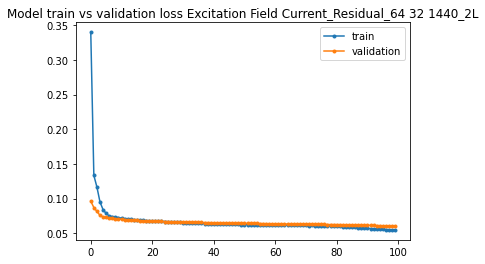

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 32 1440_2L.h5"
Training:  Excitation Field Current_Residual_64 64 1440_2L
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_36 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


337/338 [============================>.] - ETA: 0s - loss: 0.2956

338/338 [==============================] - 7s 12ms/step - loss: 0.2953 - val_loss: 0.0830
Epoch 2/100
338/338 [==============================] - 3s 8ms/step - loss: 0.1251 - val_loss: 0.0781
Epoch 3/100
338/338 [==============================] - 3s 8ms/step - loss: 0.1026 - val_loss: 0.0743
Epoch 4/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0869 - val_loss: 0.0727
Epoch 5/100
338/338 [==============================] - 3s 9ms/step - loss: 0.0805 - val_loss: 0.0716
Epoch 6/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0765 - val_loss: 0.0707
Epoch 7/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0737 - val_loss: 0.0702
Epoch 8/100
338/338 [==============================] - 3s 9ms/step - loss: 0.0730 - val_loss: 0.0699
Epoch 9/100
338/338 [==============================] - 3s 8ms/step - loss: 0.0722 - val_loss: 0.0695
Epoch 10/100
338/338 [==============================] - 3s 9ms/step - loss: 0.0716 - val_loss: 0.0692


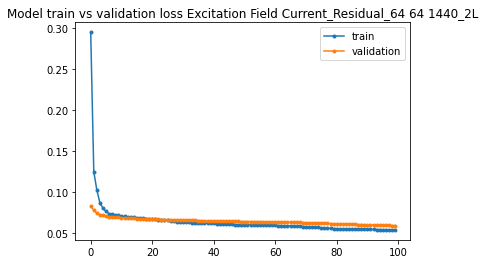

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 64 1440_2L.h5"
Training:  Excitation Field Current_Residual_64 128 1440_2L
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_38 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


337/338 [============================>.] - ETA: 0s - loss: 0.2569

338/338 [==============================] - 9s 17ms/step - loss: 0.2566 - val_loss: 0.0776
Epoch 2/100
338/338 [==============================] - 5s 14ms/step - loss: 0.1190 - val_loss: 0.0748
Epoch 3/100
338/338 [==============================] - 5s 14ms/step - loss: 0.0964 - val_loss: 0.0735
Epoch 4/100
338/338 [==============================] - 5s 14ms/step - loss: 0.0861 - val_loss: 0.0723
Epoch 5/100
338/338 [==============================] - 5s 15ms/step - loss: 0.0788 - val_loss: 0.0710
Epoch 6/100
338/338 [==============================] - 5s 15ms/step - loss: 0.0754 - val_loss: 0.0703
Epoch 7/100
338/338 [==============================] - 6s 17ms/step - loss: 0.0744 - val_loss: 0.0700
Epoch 8/100
338/338 [==============================] - 5s 14ms/step - loss: 0.0735 - val_loss: 0.0696
Epoch 9/100
338/338 [==============================] - 5s 14ms/step - loss: 0.0727 - val_loss: 0.0693
Epoch 10/100
338/338 [==============================] - 5s 15ms/step - loss: 0.0719 - val_loss

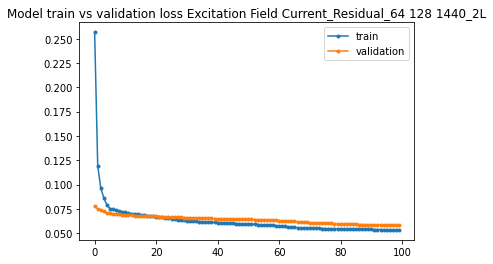

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 128 1440_2L.h5"
Training:  Excitation Field Current_Residual_128 32 1440_2L
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 1440, 32)          4352      
                                                                 
 lstm_40 (LSTM)              (None, 1440, 32)          8320      
                                                                 
Total params: 12,672
Trainable params: 12,672
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


169/169 [==============================] - ETA: 0s - loss: 0.5083

169/169 [==============================] - 7s 22ms/step - loss: 0.5083 - val_loss: 0.2995
Epoch 2/100
169/169 [==============================] - 3s 15ms/step - loss: 0.1527 - val_loss: 0.1076
Epoch 3/100
169/169 [==============================] - 3s 16ms/step - loss: 0.1397 - val_loss: 0.1092
Epoch 4/100
169/169 [==============================] - 3s 16ms/step - loss: 0.1295 - val_loss: 0.1056
Epoch 5/100
169/169 [==============================] - 2s 15ms/step - loss: 0.1196 - val_loss: 0.1016
Epoch 6/100
169/169 [==============================] - 2s 14ms/step - loss: 0.1088 - val_loss: 0.0970
Epoch 7/100
169/169 [==============================] - 3s 15ms/step - loss: 0.0970 - val_loss: 0.0908
Epoch 8/100
169/169 [==============================] - 2s 15ms/step - loss: 0.0856 - val_loss: 0.0824
Epoch 9/100
169/169 [==============================] - 3s 15ms/step - loss: 0.0794 - val_loss: 0.0777
Epoch 10/100
169/169 [==============================] - 3s 15ms/step - loss: 0.0776 - val_loss

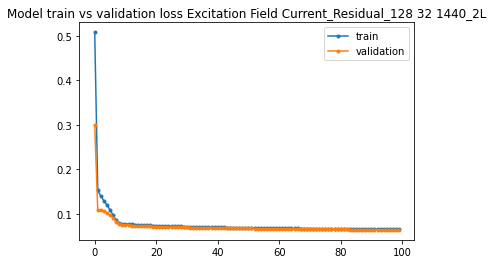

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 32 1440_2L.h5"
Training:  Excitation Field Current_Residual_128 64 1440_2L
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 lstm_42 (LSTM)              (None, 1440, 64)          33024     
                                                                 
Total params: 49,920
Trainable params: 49,920
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


168/169 [============================>.] - ETA: 0s - loss: 0.4504

169/169 [==============================] - 8s 26ms/step - loss: 0.4493 - val_loss: 0.1680
Epoch 2/100
169/169 [==============================] - 3s 20ms/step - loss: 0.1377 - val_loss: 0.1006
Epoch 3/100
169/169 [==============================] - 4s 21ms/step - loss: 0.1318 - val_loss: 0.0980
Epoch 4/100
169/169 [==============================] - 3s 20ms/step - loss: 0.1192 - val_loss: 0.0930
Epoch 5/100
169/169 [==============================] - 3s 20ms/step - loss: 0.1063 - val_loss: 0.0877
Epoch 6/100
169/169 [==============================] - 3s 19ms/step - loss: 0.0923 - val_loss: 0.0806
Epoch 7/100
169/169 [==============================] - 4s 24ms/step - loss: 0.0813 - val_loss: 0.0754
Epoch 8/100
169/169 [==============================] - 4s 25ms/step - loss: 0.0774 - val_loss: 0.0735
Epoch 9/100
169/169 [==============================] - 3s 19ms/step - loss: 0.0763 - val_loss: 0.0725
Epoch 10/100
169/169 [==============================] - 3s 20ms/step - loss: 0.0762 - val_loss

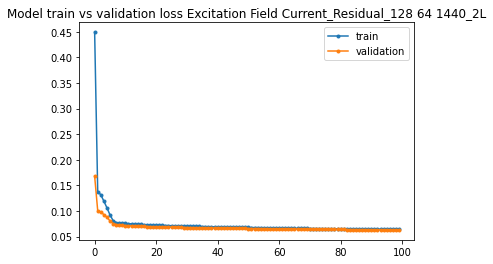

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 64 1440_2L.h5"
Training:  Excitation Field Current_Residual_128 128 1440_2L
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 1440, 128)         66560     
                                                                 
 lstm_44 (LSTM)              (None, 1440, 128)         131584    
                                                                 
Total params: 198,144
Trainable params: 198,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


169/169 [==============================] - ETA: 0s - loss: 0.3949

169/169 [==============================] - 12s 48ms/step - loss: 0.3949 - val_loss: 0.1107
Epoch 2/100
169/169 [==============================] - 7s 40ms/step - loss: 0.1395 - val_loss: 0.0928
Epoch 3/100
169/169 [==============================] - 7s 41ms/step - loss: 0.1272 - val_loss: 0.0875
Epoch 4/100
169/169 [==============================] - 5s 32ms/step - loss: 0.1109 - val_loss: 0.0821
Epoch 5/100
169/169 [==============================] - 6s 36ms/step - loss: 0.0937 - val_loss: 0.0761
Epoch 6/100
169/169 [==============================] - 6s 35ms/step - loss: 0.0818 - val_loss: 0.0728
Epoch 7/100
169/169 [==============================] - 6s 35ms/step - loss: 0.0786 - val_loss: 0.0719
Epoch 8/100
169/169 [==============================] - 6s 38ms/step - loss: 0.0774 - val_loss: 0.0712
Epoch 9/100
169/169 [==============================] - 6s 35ms/step - loss: 0.0768 - val_loss: 0.0708
Epoch 10/100
169/169 [==============================] - 6s 34ms/step - loss: 0.0763 - val_los

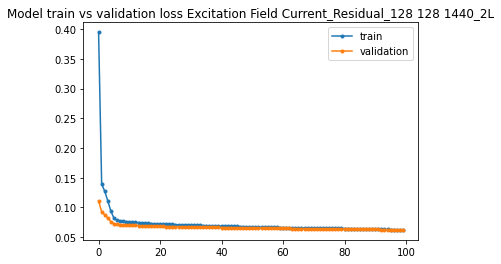

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 128 1440_2L.h5"
Export to: /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Training_summary_Excitation Field Current_Residual_2L(2022-11-26_04:09:51).xlsx


In [ ]:
training_summary = []
season = seasonals[2]
LSTM_Layer = '2L'

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

Training:  Excitation Field Current_Residual_8 32 1440_1L
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2671/2700 [============================>.] - ETA: 0s - loss: 0.2288

2700/2700 [==============================] - 6s 2ms/step - loss: 0.2276 - val_loss: 0.0971
Epoch 2/100
2700/2700 [==============================] - 4s 2ms/step - loss: 0.1056 - val_loss: 0.0835
Epoch 3/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0821 - val_loss: 0.0780
Epoch 4/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0756 - val_loss: 0.0758
Epoch 5/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0741 - val_loss: 0.0750
Epoch 6/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0732 - val_loss: 0.0742
Epoch 7/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0731 - val_loss: 0.0738
Epoch 8/100
2700/2700 [==============================] - 4s 2ms/step - loss: 0.0727 - val_loss: 0.0736
Epoch 9/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0720 - val_loss: 0.0734
Epoch 10/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0712 

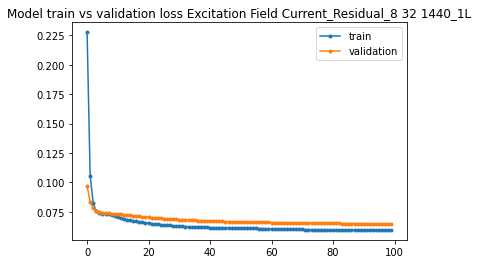

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 32 1440_1L.h5"
Training:  Excitation Field Current_Residual_8 64 1440_1L
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2673/2700 [============================>.] - ETA: 0s - loss: 0.2259

2700/2700 [==============================] - 7s 2ms/step - loss: 0.2248 - val_loss: 0.0969
Epoch 2/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.1047 - val_loss: 0.0832
Epoch 3/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0818 - val_loss: 0.0779
Epoch 4/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0754 - val_loss: 0.0758
Epoch 5/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0740 - val_loss: 0.0750
Epoch 6/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0732 - val_loss: 0.0742
Epoch 7/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0731 - val_loss: 0.0738
Epoch 8/100
2700/2700 [==============================] - 6s 2ms/step - loss: 0.0727 - val_loss: 0.0736
Epoch 9/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0720 - val_loss: 0.0734
Epoch 10/100
2700/2700 [==============================] - 5s 2ms/step - loss: 0.0711 

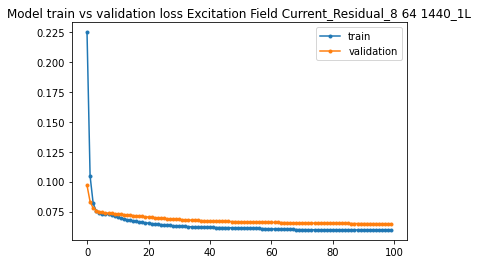

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 64 1440_1L.h5"
Training:  Excitation Field Current_Residual_8 128 1440_1L
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2680/2700 [============================>.] - ETA: 0s - loss: 0.2259

2700/2700 [==============================] - 8s 3ms/step - loss: 0.2251 - val_loss: 0.0967
Epoch 2/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.1053 - val_loss: 0.0833
Epoch 3/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0820 - val_loss: 0.0779
Epoch 4/100
2700/2700 [==============================] - 6s 2ms/step - loss: 0.0755 - val_loss: 0.0758
Epoch 5/100
2700/2700 [==============================] - 6s 2ms/step - loss: 0.0740 - val_loss: 0.0750
Epoch 6/100
2700/2700 [==============================] - 7s 2ms/step - loss: 0.0732 - val_loss: 0.0742
Epoch 7/100
2700/2700 [==============================] - 7s 2ms/step - loss: 0.0731 - val_loss: 0.0738
Epoch 8/100
2700/2700 [==============================] - 6s 2ms/step - loss: 0.0727 - val_loss: 0.0736
Epoch 9/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0720 - val_loss: 0.0734
Epoch 10/100
2700/2700 [==============================] - 7s 3ms/step - loss: 0.0711 

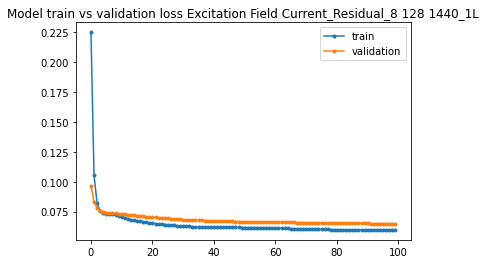

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_8 128 1440_1L.h5"
Training:  Excitation Field Current_Residual_16 32 1440_1L
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1318/1350 [============================>.] - ETA: 0s - loss: 0.3230

1350/1350 [==============================] - 5s 2ms/step - loss: 0.3196 - val_loss: 0.1553
Epoch 2/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.1361 - val_loss: 0.1097
Epoch 3/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.1224 - val_loss: 0.1029
Epoch 4/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.1015 - val_loss: 0.0933
Epoch 5/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0884 - val_loss: 0.0877
Epoch 6/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0835 - val_loss: 0.0842
Epoch 7/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0816 - val_loss: 0.0813
Epoch 8/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0812 - val_loss: 0.0802
Epoch 9/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0807 - val_loss: 0.0798
Epoch 10/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0801 

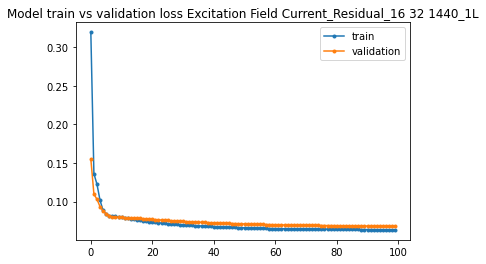

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 32 1440_1L.h5"
Training:  Excitation Field Current_Residual_16 64 1440_1L
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1349/1350 [============================>.] - ETA: 0s - loss: 0.3190

1350/1350 [==============================] - 4s 2ms/step - loss: 0.3189 - val_loss: 0.1532
Epoch 2/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.1361 - val_loss: 0.1094
Epoch 3/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.1231 - val_loss: 0.1029
Epoch 4/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.1025 - val_loss: 0.0935
Epoch 5/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0886 - val_loss: 0.0877
Epoch 6/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0835 - val_loss: 0.0844
Epoch 7/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0815 - val_loss: 0.0813
Epoch 8/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0811 - val_loss: 0.0802
Epoch 9/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0807 - val_loss: 0.0798
Epoch 10/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.0801 

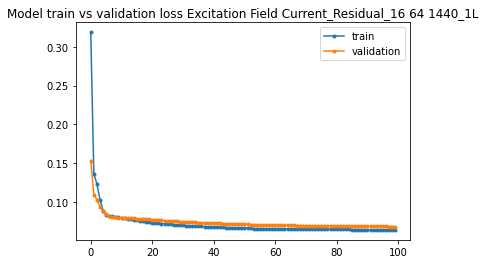

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 64 1440_1L.h5"
Training:  Excitation Field Current_Residual_16 128 1440_1L
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


1350/1350 [==============================] - ETA: 0s - loss: 0.3172

1350/1350 [==============================] - 5s 3ms/step - loss: 0.3172 - val_loss: 0.1515
Epoch 2/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1359 - val_loss: 0.1092
Epoch 3/100
1350/1350 [==============================] - 3s 2ms/step - loss: 0.1232 - val_loss: 0.1028
Epoch 4/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.1028 - val_loss: 0.0936
Epoch 5/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0886 - val_loss: 0.0877
Epoch 6/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0835 - val_loss: 0.0845
Epoch 7/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0814 - val_loss: 0.0813
Epoch 8/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0810 - val_loss: 0.0802
Epoch 9/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0806 - val_loss: 0.0798
Epoch 10/100
1350/1350 [==============================] - 4s 3ms/step - loss: 0.0800 

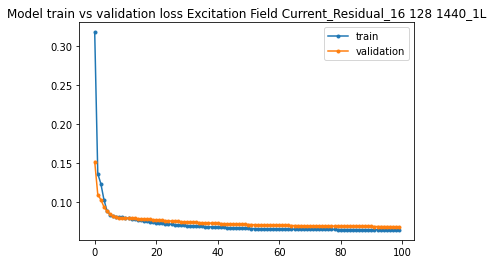

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_16 128 1440_1L.h5"
Training:  Excitation Field Current_Residual_32 32 1440_1L
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


661/675 [============================>.] - ETA: 0s - loss: 0.4578

675/675 [==============================] - 3s 3ms/step - loss: 0.4555 - val_loss: 0.3212
Epoch 2/100
675/675 [==============================] - 1s 2ms/step - loss: 0.1864 - val_loss: 0.1618
Epoch 3/100
675/675 [==============================] - 1s 2ms/step - loss: 0.1431 - val_loss: 0.1270
Epoch 4/100
675/675 [==============================] - 1s 2ms/step - loss: 0.1368 - val_loss: 0.1185
Epoch 5/100
675/675 [==============================] - 2s 2ms/step - loss: 0.1311 - val_loss: 0.1158
Epoch 6/100
675/675 [==============================] - 1s 2ms/step - loss: 0.1238 - val_loss: 0.1141
Epoch 7/100
675/675 [==============================] - 1s 2ms/step - loss: 0.1148 - val_loss: 0.1124
Epoch 8/100
675/675 [==============================] - 1s 2ms/step - loss: 0.1046 - val_loss: 0.1095
Epoch 9/100
675/675 [==============================] - 1s 2ms/step - loss: 0.0952 - val_loss: 0.1035
Epoch 10/100
675/675 [==============================] - 1s 2ms/step - loss: 0.0895 - val_loss: 0.0971
E

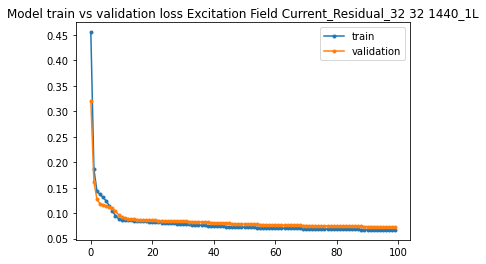

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 32 1440_1L.h5"
Training:  Excitation Field Current_Residual_32 64 1440_1L
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


664/675 [============================>.] - ETA: 0s - loss: 0.4472

675/675 [==============================] - 3s 3ms/step - loss: 0.4455 - val_loss: 0.3129
Epoch 2/100
675/675 [==============================] - 2s 2ms/step - loss: 0.1833 - val_loss: 0.1604
Epoch 3/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1423 - val_loss: 0.1266
Epoch 4/100
675/675 [==============================] - 2s 2ms/step - loss: 0.1359 - val_loss: 0.1184
Epoch 5/100
675/675 [==============================] - 2s 2ms/step - loss: 0.1301 - val_loss: 0.1157
Epoch 6/100
675/675 [==============================] - 2s 2ms/step - loss: 0.1225 - val_loss: 0.1140
Epoch 7/100
675/675 [==============================] - 2s 2ms/step - loss: 0.1132 - val_loss: 0.1122
Epoch 8/100
675/675 [==============================] - 2s 3ms/step - loss: 0.1026 - val_loss: 0.1092
Epoch 9/100
675/675 [==============================] - 2s 2ms/step - loss: 0.0932 - val_loss: 0.1024
Epoch 10/100
675/675 [==============================] - 2s 2ms/step - loss: 0.0885 - val_loss: 0.0955
E

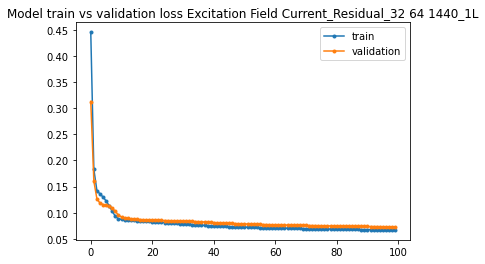

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 64 1440_1L.h5"
Training:  Excitation Field Current_Residual_32 128 1440_1L
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


665/675 [============================>.] - ETA: 0s - loss: 0.4447

675/675 [==============================] - 4s 5ms/step - loss: 0.4431 - val_loss: 0.3100
Epoch 2/100
675/675 [==============================] - 2s 4ms/step - loss: 0.1823 - val_loss: 0.1599
Epoch 3/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1422 - val_loss: 0.1264
Epoch 4/100
675/675 [==============================] - 2s 4ms/step - loss: 0.1360 - val_loss: 0.1183
Epoch 5/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1302 - val_loss: 0.1157
Epoch 6/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1225 - val_loss: 0.1139
Epoch 7/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1133 - val_loss: 0.1123
Epoch 8/100
675/675 [==============================] - 3s 4ms/step - loss: 0.1027 - val_loss: 0.1095
Epoch 9/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0926 - val_loss: 0.1025
Epoch 10/100
675/675 [==============================] - 3s 4ms/step - loss: 0.0882 - val_loss: 0.0950
E

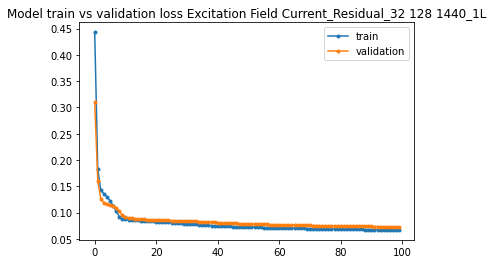

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_32 128 1440_1L.h5"
Training:  Excitation Field Current_Residual_64 32 1440_1L
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


337/338 [============================>.] - ETA: 0s - loss: 0.5562

338/338 [==============================] - 3s 5ms/step - loss: 0.5562 - val_loss: 0.5363
Epoch 2/100
338/338 [==============================] - 1s 4ms/step - loss: 0.3415 - val_loss: 0.3171
Epoch 3/100
338/338 [==============================] - 1s 4ms/step - loss: 0.2093 - val_loss: 0.2070
Epoch 4/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1601 - val_loss: 0.1634
Epoch 5/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1462 - val_loss: 0.1412
Epoch 6/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1411 - val_loss: 0.1312
Epoch 7/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1383 - val_loss: 0.1261
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1357 - val_loss: 0.1234
Epoch 9/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1328 - val_loss: 0.1219
Epoch 10/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1295 - val_loss: 0.1210
E

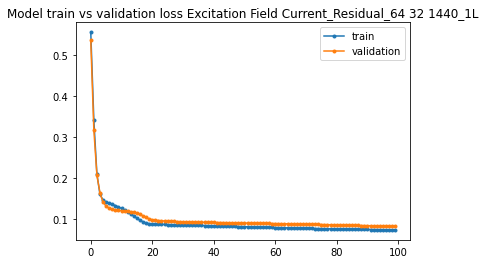

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 32 1440_1L.h5"
Training:  Excitation Field Current_Residual_64 64 1440_1L
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


330/338 [============================>.] - ETA: 0s - loss: 0.5503

338/338 [==============================] - 3s 6ms/step - loss: 0.5504 - val_loss: 0.5276
Epoch 2/100
338/338 [==============================] - 2s 5ms/step - loss: 0.3363 - val_loss: 0.3135
Epoch 3/100
338/338 [==============================] - 2s 5ms/step - loss: 0.2074 - val_loss: 0.2056
Epoch 4/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1595 - val_loss: 0.1630
Epoch 5/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1460 - val_loss: 0.1410
Epoch 6/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1409 - val_loss: 0.1311
Epoch 7/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1381 - val_loss: 0.1261
Epoch 8/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1355 - val_loss: 0.1235
Epoch 9/100
338/338 [==============================] - 1s 4ms/step - loss: 0.1325 - val_loss: 0.1220
Epoch 10/100
338/338 [==============================] - 2s 5ms/step - loss: 0.1291 - val_loss: 0.1211
E

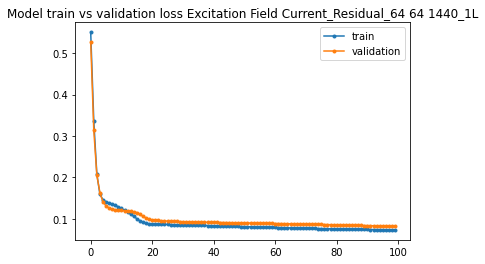

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 64 1440_1L.h5"
Training:  Excitation Field Current_Residual_64 128 1440_1L
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


335/338 [============================>.] - ETA: 0s - loss: 0.5490

338/338 [==============================] - 4s 8ms/step - loss: 0.5491 - val_loss: 0.5234
Epoch 2/100
338/338 [==============================] - 2s 6ms/step - loss: 0.3332 - val_loss: 0.3104
Epoch 3/100
338/338 [==============================] - 2s 7ms/step - loss: 0.2055 - val_loss: 0.2037
Epoch 4/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1588 - val_loss: 0.1620
Epoch 5/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1457 - val_loss: 0.1404
Epoch 6/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1409 - val_loss: 0.1308
Epoch 7/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1381 - val_loss: 0.1259
Epoch 8/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1355 - val_loss: 0.1233
Epoch 9/100
338/338 [==============================] - 2s 6ms/step - loss: 0.1325 - val_loss: 0.1219
Epoch 10/100
338/338 [==============================] - 2s 7ms/step - loss: 0.1291 - val_loss: 0.1210
E

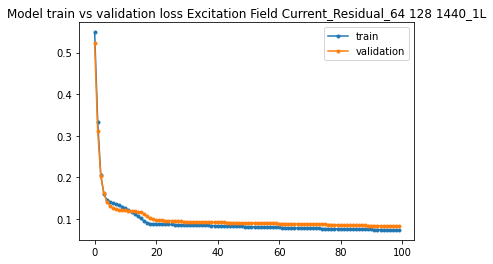

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_64 128 1440_1L.h5"
Training:  Excitation Field Current_Residual_128 32 1440_1L
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1440, 32)          4352      
                                                                 
Total params: 4,352
Trainable params: 4,352
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


164/169 [============================>.] - ETA: 0s - loss: 0.5980

169/169 [==============================] - 3s 8ms/step - loss: 0.6006 - val_loss: 0.6638
Epoch 2/100
169/169 [==============================] - 1s 6ms/step - loss: 0.4964 - val_loss: 0.5293
Epoch 3/100
169/169 [==============================] - 1s 6ms/step - loss: 0.3821 - val_loss: 0.4051
Epoch 4/100
169/169 [==============================] - 1s 6ms/step - loss: 0.2911 - val_loss: 0.3141
Epoch 5/100
169/169 [==============================] - 1s 6ms/step - loss: 0.2285 - val_loss: 0.2506
Epoch 6/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1876 - val_loss: 0.2077
Epoch 7/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1656 - val_loss: 0.1816
Epoch 8/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1545 - val_loss: 0.1641
Epoch 9/100
169/169 [==============================] - 1s 5ms/step - loss: 0.1483 - val_loss: 0.1517
Epoch 10/100
169/169 [==============================] - 1s 6ms/step - loss: 0.1444 - val_loss: 0.1428
E

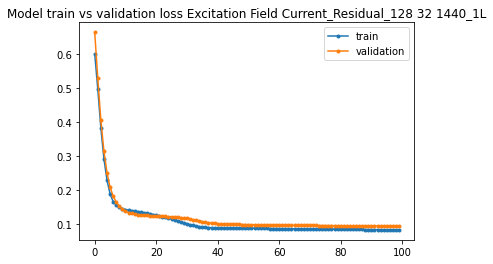

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 32 1440_1L.h5"
Training:  Excitation Field Current_Residual_128 64 1440_1L
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 1440, 64)          16896     
                                                                 
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


168/169 [============================>.] - ETA: 0s - loss: 0.6020

169/169 [==============================] - 3s 12ms/step - loss: 0.6025 - val_loss: 0.6649
Epoch 2/100
169/169 [==============================] - 1s 8ms/step - loss: 0.4958 - val_loss: 0.5274
Epoch 3/100
169/169 [==============================] - 1s 8ms/step - loss: 0.3800 - val_loss: 0.4024
Epoch 4/100
169/169 [==============================] - 1s 8ms/step - loss: 0.2890 - val_loss: 0.3116
Epoch 5/100
169/169 [==============================] - 1s 9ms/step - loss: 0.2267 - val_loss: 0.2484
Epoch 6/100
169/169 [==============================] - 1s 9ms/step - loss: 0.1862 - val_loss: 0.2061
Epoch 7/100
169/169 [==============================] - 2s 10ms/step - loss: 0.1649 - val_loss: 0.1804
Epoch 8/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1541 - val_loss: 0.1631
Epoch 9/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1481 - val_loss: 0.1510
Epoch 10/100
169/169 [==============================] - 1s 8ms/step - loss: 0.1443 - val_loss: 0.1422

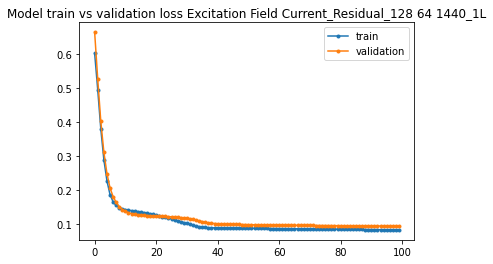

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 64 1440_1L.h5"
Training:  Excitation Field Current_Residual_128 128 1440_1L
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1440, 128)         66560     
                                                                 
Total params: 66,560
Trainable params: 66,560
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


165/169 [============================>.] - ETA: 0s - loss: 0.6011

169/169 [==============================] - 4s 16ms/step - loss: 0.6031 - val_loss: 0.6640
Epoch 2/100
169/169 [==============================] - 2s 14ms/step - loss: 0.4938 - val_loss: 0.5239
Epoch 3/100
169/169 [==============================] - 2s 14ms/step - loss: 0.3769 - val_loss: 0.3986
Epoch 4/100
169/169 [==============================] - 2s 13ms/step - loss: 0.2861 - val_loss: 0.3083
Epoch 5/100
169/169 [==============================] - 2s 14ms/step - loss: 0.2243 - val_loss: 0.2458
Epoch 6/100
169/169 [==============================] - 2s 14ms/step - loss: 0.1845 - val_loss: 0.2040
Epoch 7/100
169/169 [==============================] - 2s 14ms/step - loss: 0.1639 - val_loss: 0.1789
Epoch 8/100
169/169 [==============================] - 2s 14ms/step - loss: 0.1535 - val_loss: 0.1620
Epoch 9/100
169/169 [==============================] - 2s 14ms/step - loss: 0.1476 - val_loss: 0.1501
Epoch 10/100
169/169 [==============================] - 2s 14ms/step - loss: 0.1440 - val_loss

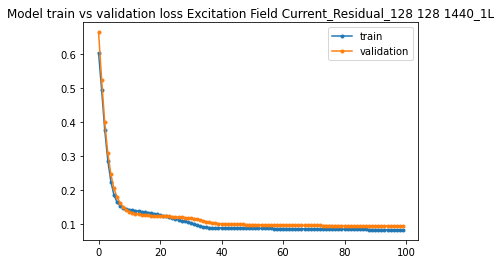

Model saved to: " /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Model Excitation Field Current_Residual_128 128 1440_1L.h5"
Export to: /content/drive/MyDrive/Colab Notebooks/LSTM/log/v6.1/HyperTuning/Training_summary_Excitation Field Current_Residual_1L(2022-11-26_13:18:35).xlsx


In [ ]:
training_summary = []
season = seasonals[2]
LSTM_Layer = '1L'

for n_epoch in n_epochs[season]:
  for n_batch in n_batchs[season]:
    for n_unit in n_units[season]:
      for n_timestep in n_timesteps[season]:
        prefix = str(sensor)+'_'+season+'_'+str(n_batch)+' '+str(n_unit)+' '+str(n_timestep)+'_'+LSTM_Layer

        print('Training: ',prefix)
        print('======================================================================')
        
        if  LSTM_Layer == '1L+1S':
          model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '2L': 
          model, model_log = FitLstm2(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
        elif LSTM_Layer == '1L':
          model, model_log = FitLstm3(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)

        training_summary.append([
        sensor,
        season,
        LSTM_Layer,
        n_batch, 
        n_unit,
        n_timestep,
        n_epoch, 
        model_log.history['loss'][-1],
        model_log.history['val_loss'][-1],
        json.dumps(model_log.history['loss']),
        json.dumps(model_log.history['val_loss'])
      ])

#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'_'+season+'_'+LSTM_Layer+'('+TIMESTAMP+').xlsx')

## Save Summary

In [ ]:
#Save summary
# TIMESTAMP = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss'])
export_summary

NameError: ignored

In [ ]:
TIMESTAMP = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary_'+sensor+'('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary_'+sensor+'('+TIMESTAMP+').xlsx')